In [2]:
import os
import urllib.request
import zipfile
from functools import partial

import pandas as pd
import xarray as xr
import pynncml

from pynncml.datasets.dataset import LinkDataset
from pynncml.datasets.gauge_data import PointSensor
from pynncml.datasets import PointSet
import numpy as np
import netCDF4 as nc

from pynncml.datasets.xarray_processing import xarray2link, LinkSelection

In [3]:
import os
from pathlib import Path

# find the OpenMesh-1 root automatically
root = Path.cwd()

while root.name != "OpenMesh_pynncml":
    root = root.parent

os.chdir(root)
print("Working directory set to:", root)


Working directory set to: /Users/drorjac/OpenMesh_pynncml


Import file

In [7]:
# ============================================
# PATH CONFIGURATION
# ============================================
from pathlib import Path

# Choose user
USER = "dror"  # Options: "user" or "dror"

# Base path (relative to project root - adjust if needed)
BASE_PATH = Path("src/data/openmesh/extracted/dataset")

# All paths built from base path
linkspath = str(BASE_PATH / "links" / "ds_openmesh.nc")
metapath = str(BASE_PATH / "links" / "links_metadata.csv")
gaugespath = str(BASE_PATH / "weather stations" / "pws_opensense_sample_jan.nc")
gaugemetapath = str(BASE_PATH / "weather stations" / "pws_metadata.csv")

# Load data
with xr.open_dataset(linkspath) as ds:
    pass
links_meta = pd.read_csv(metapath)




1. Gauge data to Point Sensors

In [9]:
# ###############################
# DROR'S FUNCTION FOR PWS DATA
# ###############################


def read_netcdf_groups_to_xarray_dict(ds):
    """
    Convert open netCDF4 groups to dict of xarray Datasets.
    """
    print(f"\n{'=' * 70}")
    print("CONVERTING NETCDF GROUPS TO XARRAY DICT")
    print(f"{'=' * 70}\n")

    stations = {}

    for station_id in ds.groups.keys():
        try:
            station_ds = xr.open_dataset(ds.filepath(), group=station_id, engine='netcdf4')
            stations[station_id] = station_ds
            print(f"  ✓ {station_id}: {len(station_ds.time)} records")
        except Exception as e:
            print(f"  ❌ {station_id}: {e}")

    print(f"\n✓ Converted {len(stations)} stations")
    print(f"{'=' * 70}\n")

    return stations

In [68]:
# ############################################
# CONVERTS NYC TIME GAUGE DATA DF TO UTC TIME
# ############################################

def nyc_to_utc(df, col):
    df = df.copy()
    
    # Parse timestamps
    df[col] = pd.to_datetime(df[col])
    
    # Get list of gauge station columns BEFORE any processing
    station_columns = [c for c in df.columns if c != col]
    print(f"Found {len(station_columns)} gauge station columns")
    
    # Localize to NYC timezone
    df['time_nyc'] = df[col].dt.tz_localize(
        'America/New_York',
        ambiguous=False,  # Fall-back: treat as second occurrence (EST)
        nonexistent='NaT'  # Spring-forward: mark as NaT
    )
    
    # Drop non-existent spring times
    print(f"Before dropping NaT: {len(df)} rows")
    df = df.dropna(subset=['time_nyc'])
    print(f"After dropping NaT: {len(df)} rows (dropped {70849 - len(df)})")
    
    # Convert to UTC
    df['time_utc'] = df['time_nyc'].dt.tz_convert('UTC')
    df = df.sort_values('time_utc').reset_index(drop=True)
    
    # Set time_utc as index for resampling
    df = df.set_index('time_utc')
    
    # Create complete 5-minute time range
    start_time = df.index.min()
    end_time = df.index.max()
    complete_index = pd.date_range(start=start_time, end=end_time, freq='5min')
    
    print(f"Expected rows with 5-min intervals: {len(complete_index)}")
    
    # Reindex to fill gaps (NaN will be preserved for missing time periods)
    df = df.reindex(complete_index)
    
    # DO NOT fill NaN values - preserve them to distinguish missing data from zero rainfall
    # df[station_columns] = df[station_columns].fillna(0.0)  # REMOVED: preserves NaN
    
    # Reset index to make time_utc a column again
    df = df.reset_index()
    df = df.rename(columns={'index': 'time_utc'})
    
    print(f"After resampling (NaN preserved for missing data): {len(df)} total rows")
    
    # Verify all intervals are 300s
    time_unix = df['time_utc'].dt.tz_localize(None).astype(np.int64) // 10**9
    intervals = np.diff(time_unix)
    print(f"All intervals 300s? {np.all(intervals == 300)}")
    
    return df

In [129]:
#####################################
# LOAD PWS GAUGE DATA
#####################################


def guage_to_linkset(gaugemetapath, gaugespath):
    # Load gauge metadata
    gauge_metadata = pd.read_csv(gaugemetapath, index_col=0)

    # Load gauge data
    ds_gauge = nc.Dataset(gaugespath, 'r')
    
    gauge = read_netcdf_groups_to_xarray_dict(ds_gauge)
    dfs = []
    for station, ds_gauge_temp in gauge.items():
            
        var_name = list(ds_gauge_temp.data_vars)[0]
        da = ds_gauge_temp[var_name]

        df = da.to_dataframe(name=station).reset_index()
        dfs.append(df[["time", station]])

    from functools import reduce

    # merge sequentially on "time"
    gauge_data = reduce(
        lambda left, right: left.merge(right, on="time", how="outer"),
        dfs
    )
    gauge_data = gauge_data.sort_values("time").reset_index(drop=True)
    
    # Time from NYC to UTC
    #gauge_data = nyc_to_utc(gauge_data, 'time')
    gauge_data = gauge_data.reset_index(drop=True)
    # 'time_utc' column was added with correct utc time

    # timezone-aware → naive → numpy array
    time_array_gauge = gauge_data['time'].dt.tz_localize(None).to_numpy()

    # convert to second resolution
    time_array_gauge = time_array_gauge.astype("datetime64[s]")

    # convert to unix seconds (int64)
    time_array_gauge_unix = time_array_gauge.astype(np.int64)

    # 5-minute sampling
    rain_gauge_time_base = 300  # seconds

    # Create PointSensors from the gauge data 
    gauge_list = []
    for g_id in gauge_data.columns:

        # Iterate only over pws columns
        if g_id in ['time_utc', 'time_nyc', 'Unnamed: 0', 'time']:
            continue

        # Match with metadata by "Station ID"
        i = gauge_metadata.index[gauge_metadata["Station ID"] == g_id].tolist()
        if not i:
            print(f"⚠️ Skipping '{g_id}' (no matching Station ID in metadata)")
            continue
        i = i[0]

        # Get coordinates from metadata
        lon = gauge_metadata.loc[i, "Longitude"]
        lat = gauge_metadata.loc[i, "Latitude"]

        # Extract rainfall data (preserve NaN values - don't convert to zero)
        rain_rate_gauge = gauge_data[g_id].values
        # DO NOT convert NaN to 0 - preserve NaN to distinguish missing data from zero rainfall
        # rain_rate_gauge = np.nan_to_num(rain_rate_gauge, nan=0.0)  # REMOVED: preserves NaN

        # Only build PointSensor if data has at least some valid (non-NaN) values
        if not np.all(np.isnan(rain_rate_gauge)):
            ps = PointSensor(
                rain_rate_gauge,
                time_array_gauge_unix,
                lon=lon,
                lat=lat
            )
            #ps = ps.change_time_base(rain_gauge_time_base)
            gauge_list.append(ps)

    # Combine all into PointSet
    ps = PointSet(gauge_list)
    return ps


In [130]:
# CREATE POINT SENSORS
ps = guage_to_linkset(gaugemetapath, gaugespath)


CONVERTING NETCDF GROUPS TO XARRAY DICT

  ✓ KNYNEWYO1472: 4402 records
  ✓ KNYNEWYO1659: 4606 records
  ✓ KNYNEWYO1288: 3743 records
  ✓ KNYNEWYO1896: 4606 records
  ✓ KNYNEWYO1921: 4605 records
  ✓ KNYNEWYO1931: 4606 records
  ✓ KNYNEWYO1313: 4604 records
  ✓ KNYNEWYO1918: 4604 records
  ✓ KNYNEWYO1298: 4606 records
  ✓ KNYNEWYO1388: 4599 records
  ✓ KNYNEWYO1606: 4606 records
  ✓ KNYNEWYO1943: 290 records
  ✓ KNYNEWYO1348: 4606 records
  ✓ KNYNEWYO1942: 373 records
  ✓ KNYNEWYO1238: 4544 records
  ✓ KNYNEWYO1401: 4587 records
  ✓ KNYNEWYO1824: 4605 records
  ✓ KNYNEWYO343: 4606 records
  ✓ KNYNEWYO1626: 4604 records
  ✓ KNYNEWYO1747: 1171 records
  ✓ KNYNEWYO589: 4605 records
  ✓ KNYNEWYO1591: 4606 records
  ✓ KNYNEWYO638: 3958 records
  ✓ KNYNEWYO1796: 4606 records
  ✓ KNYNEWYO1805: 4534 records
  ✓ KNYNEWYO1622: 4606 records
  ✓ KNYNEWYO1024: 1506 records
  ✓ KNYNEWYO1533: 4580 records
  ✓ KNYNEWYO1651: 1534 records
  ✓ KNYNEWYO1120: 4606 records
  ✓ KNYNEWYO1900: 4605 records
  

In [131]:
ps 

2. From xarray to LinkSet

In [132]:
# *********************************************
# LINK DATA TO LINK SET (WITH NaN HANDLING)
# WITH PATCHED xarray2link AND WITH GAUGE REF
# *********************************************

import numpy as np
from tqdm import tqdm
from pynncml.datasets.link_data import Link
from pynncml.datasets.meta_data import MetaData
from pynncml.datasets.sensors_set import LinkSet
import pandas as pd

def patched_xarray2link_with_gauges(ds, ps, max_distance=5000):
    """
    Convert xarray to LinkSet with gauge references
    Skips links with NaN coordinates or no valid RSL data
    """
    link_list = []
    skipped_coords = 0
    skipped_data = 0
    
    for i in tqdm(range(len(ds.sublink_id)), desc="Processing sublinks"):
        sublink_name = ds.sublink_id.values[i]
        
        # Loop through each cml_id
        for cid in ds.cml_id.values:
            ds_one = ds.sel(cml_id=cid, sublink_id=sublink_name).squeeze(drop=True)
            
            # Extract coordinates
            site_0_lon = float(ds_one.site_0_lon.values)
            site_0_lat = float(ds_one.site_0_lat.values)
            site_1_lon = float(ds_one.site_1_lon.values)
            site_1_lat = float(ds_one.site_1_lat.values)
            
            # Skip if coordinates are NaN
            if (np.isnan(site_0_lat) or np.isnan(site_0_lon) or 
                np.isnan(site_1_lat) or np.isnan(site_1_lon)):
                skipped_coords += 1
                continue
            
            # Extract RSL data
            rsl = np.squeeze(ds_one["rsl"].values)
            
            # Skip if all RSL values are NaN (no valid data)
            if np.all(np.isnan(rsl)):
                skipped_data += 1
                continue
            
            # Extract other metadata
            frequency = float(ds_one.frequency.values)
            length = float(ds_one.length.values)
            polarization = str(ds_one.polarization.values)
            
            # Build metadata
            md = MetaData(
                frequency / 1000,  # MHz to GHz
                "Vertical" in polarization or "v" in polarization.lower(),
                length / 1000,  # meters to km
                height_far=None,
                height_near=None,
                lon_lat_site_zero=[site_0_lon, site_0_lat],
                lon_lat_site_one=[site_1_lon, site_1_lat],
            )
            
            # Add cml_id and sublink_id to metadata
            md.cml_id = str(cid)
            md.sublink_id = str(sublink_name)
            
            # Extract TSL data
            tsl = np.squeeze(ds_one["tsl"].values) if "tsl" in ds_one else np.zeros_like(rsl)
            
            # Find all gauges within max_distance
            distances, gauges = ps.find_near_gauges(md.xy_center(), max_distance)
            gauge_ref = None
            
            # If we have gauges within range, create averaged gauge
            if len(gauges) > 0:
                # Print number of gauges used for averaging
                print(f"  Link cml_id={cid}, sublink_id={sublink_name}: Averaging {len(gauges)} gauge(s) "
                      f"(distances: {[f'{d:.1f}m' for d in distances[:5]]}{'...' if len(distances) > 5 else ''})")
                
                # Extract data arrays from all gauges
                # Assume all gauges have the same time base (they should if from same PointSet)
                data_arrays = [g.data_array for g in gauges]
                
                # Stack arrays for averaging (handle NaN properly)
                stacked_arrays = np.stack(data_arrays, axis=0)
                
                # Average the data arrays using nanmean to properly handle NaN values
                # This ignores NaN when computing the mean, so missing data doesn't affect the average
                averaged_data = np.nanmean(stacked_arrays, axis=0)
                
                # Use the first gauge's time array (all should be the same)
                time_array = gauges[0].time_array
                
                # Calculate average location
                avg_lon = np.mean([g.lon for g in gauges])
                avg_lat = np.mean([g.lat for g in gauges])
                
                # Create averaged PointSensor
                from pynncml.datasets.gauge_data import PointSensor
                averaged_gauge = PointSensor(
                    data_array=averaged_data,
                    time_array=time_array,
                    lon=avg_lon,
                    lat=avg_lat,
                    force_zone_number=gauges[0].force_zone_number,
                    force_zone_letter=gauges[0].force_zone_letter
                )
                
                gauge_ref = [averaged_gauge]
                # Store number of gauges used in metadata for later reference
                md.num_gauges_used = len(gauges)
            else:
                # No gauges found
                md.num_gauges_used = 0
            
            # Create Link
            link = Link(
                link_rsl=rsl,
                time_array=ds_one.time.to_numpy().astype("datetime64[s]").astype("int"),
                meta_data=md,
                link_tsl=tsl
            )
            
            # Add gauge reference to the link
            link.add_reference(gauge_ref=gauge_ref)
            
            link_list.append(link)
    
    # Summary
    print(f"\n{'='*60}")
    print(f"Processing Summary:")
    print(f"  ✅ Valid links created: {len(link_list)}")
    print(f"  ⚠️  Skipped (missing coordinates): {skipped_coords}")
    print(f"  ⚠️  Skipped (no RSL data): {skipped_data}")
    print(f"  📊 Total processed: {skipped_coords + skipped_data + len(link_list)}")
    print(f"{'='*60}\n")
    
    return LinkSet(link_list)


# Create the LinkSet with validation
link_set = patched_xarray2link_with_gauges(ds, ps, max_distance=10000)

print(f"✅ Created LinkSet with {len(link_set)} sublinks")

# Now you can access them like:
# link_set.get_link(0).meta_data.cml_id
# link_set.get_link(0).meta_data.sublink_id

Processing sublinks:   0%|          | 0/3 [00:00<?, ?it/s]/var/folders/9q/vrtjr2_56sjdhy0yx86b5bjr0000gn/T/ipykernel_5876/1934189851.py:91: RuntimeWarning: Mean of empty slice
  averaged_data = np.nanmean(stacked_arrays, axis=0)


  Link cml_id=1, sublink_id=sublink_1: Averaging 11 gauge(s) (distances: ['2350.7m', '2949.4m', '4626.8m', '6767.3m', '7227.0m']...)
  Link cml_id=2, sublink_id=sublink_1: Averaging 10 gauge(s) (distances: ['2078.4m', '2805.2m', '3179.5m', '5720.4m', '6459.0m']...)
  Link cml_id=3, sublink_id=sublink_1: Averaging 12 gauge(s) (distances: ['2089.5m', '3797.4m', '3811.5m', '6274.1m', '6943.9m']...)
  Link cml_id=4, sublink_id=sublink_1: Averaging 7 gauge(s) (distances: ['1467.2m', '5052.7m', '6018.3m', '6347.2m', '6959.8m']...)
  Link cml_id=5, sublink_id=sublink_1: Averaging 13 gauge(s) (distances: ['1236.1m', '1748.8m', '3734.1m', '6418.9m', '6432.5m']...)
  Link cml_id=6, sublink_id=sublink_1: Averaging 14 gauge(s) (distances: ['1059.8m', '2367.5m', '2423.5m', '5810.0m', '5994.6m']...)
  Link cml_id=7, sublink_id=sublink_1: Averaging 13 gauge(s) (distances: ['786.6m', '1804.7m', '4151.4m', '6181.4m', '6896.6m']...)
  Link cml_id=8, sublink_id=sublink_1: Averaging 13 gauge(s) (distances

Processing sublinks:  33%|███▎      | 1/3 [00:00<00:00,  2.70it/s]

  Link cml_id=44, sublink_id=sublink_1: Averaging 9 gauge(s) (distances: ['1289.0m', '1916.8m', '3459.7m', '4005.2m', '5159.2m']...)
  Link cml_id=45, sublink_id=sublink_1: Averaging 12 gauge(s) (distances: ['830.2m', '2121.9m', '2489.0m', '4676.4m', '6627.5m']...)
  Link cml_id=46, sublink_id=sublink_1: Averaging 13 gauge(s) (distances: ['2671.0m', '4699.2m', '5761.6m', '6652.5m', '8385.2m']...)
  Link cml_id=47, sublink_id=sublink_1: Averaging 14 gauge(s) (distances: ['850.3m', '2334.0m', '3556.1m', '5072.8m', '6928.7m']...)
  Link cml_id=48, sublink_id=sublink_1: Averaging 11 gauge(s) (distances: ['2737.7m', '4301.6m', '4350.1m', '5435.4m', '7540.0m']...)
  Link cml_id=49, sublink_id=sublink_1: Averaging 10 gauge(s) (distances: ['3121.2m', '3342.4m', '3712.9m', '3914.8m', '6530.1m']...)
  Link cml_id=50, sublink_id=sublink_1: Averaging 13 gauge(s) (distances: ['2835.6m', '4594.6m', '5596.9m', '6488.3m', '8523.8m']...)
  Link cml_id=51, sublink_id=sublink_1: Averaging 13 gauge(s) (di

Processing sublinks:  67%|██████▋   | 2/3 [00:00<00:00,  3.81it/s]

  Link cml_id=7, sublink_id=sublink_2: Averaging 13 gauge(s) (distances: ['786.6m', '1804.7m', '4151.4m', '6181.4m', '6896.6m']...)
  Link cml_id=8, sublink_id=sublink_2: Averaging 13 gauge(s) (distances: ['2720.6m', '3045.1m', '3125.7m', '6352.8m', '6791.8m']...)
  Link cml_id=9, sublink_id=sublink_2: Averaging 12 gauge(s) (distances: ['1536.6m', '1797.4m', '2720.1m', '5107.5m', '6686.8m']...)
  Link cml_id=10, sublink_id=sublink_2: Averaging 9 gauge(s) (distances: ['2130.7m', '5352.3m', '6381.6m', '6518.0m', '7398.4m']...)
  Link cml_id=11, sublink_id=sublink_2: Averaging 6 gauge(s) (distances: ['1035.1m', '2258.2m', '3481.4m', '5188.5m', '6217.9m']...)
  Link cml_id=12, sublink_id=sublink_2: Averaging 10 gauge(s) (distances: ['2268.4m', '2864.4m', '3580.3m', '4603.1m', '5709.9m']...)
  Link cml_id=13, sublink_id=sublink_2: Averaging 13 gauge(s) (distances: ['3261.3m', '3707.7m', '5238.8m', '6271.9m', '8427.9m']...)
  Link cml_id=14, sublink_id=sublink_2: Averaging 13 gauge(s) (dista

Processing sublinks: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Processing Summary:
  ✅ Valid links created: 103
  ⚠️  Skipped (missing coordinates): 0
  ⚠️  Skipped (no RSL data): 122
  📊 Total processed: 225

✅ Created LinkSet with 103 sublinks


In [109]:
# CHECK FOR CML_IDs AND SUBLINK_IDs

for i in range(len(link_set)):
    print(f'Link {i}:{link_set.get_link(i).meta_data.cml_id} {link_set.get_link(i).meta_data.sublink_id}')

Link 0:1 sublink_1
Link 1:2 sublink_1
Link 2:3 sublink_1
Link 3:4 sublink_1
Link 4:5 sublink_1
Link 5:6 sublink_1
Link 6:7 sublink_1
Link 7:8 sublink_1
Link 8:9 sublink_1
Link 9:10 sublink_1
Link 10:11 sublink_1
Link 11:12 sublink_1
Link 12:13 sublink_1
Link 13:14 sublink_1
Link 14:15 sublink_1
Link 15:16 sublink_1
Link 16:17 sublink_1
Link 17:18 sublink_1
Link 18:19 sublink_1
Link 19:20 sublink_1
Link 20:21 sublink_1
Link 21:22 sublink_1
Link 22:23 sublink_1
Link 23:24 sublink_1
Link 24:25 sublink_1
Link 25:26 sublink_1
Link 26:27 sublink_1
Link 27:28 sublink_1
Link 28:29 sublink_1
Link 29:30 sublink_1
Link 30:31 sublink_1
Link 31:32 sublink_1
Link 32:33 sublink_1
Link 33:34 sublink_1
Link 34:35 sublink_1
Link 35:36 sublink_1
Link 36:37 sublink_1
Link 37:38 sublink_1
Link 38:39 sublink_1
Link 39:40 sublink_1
Link 40:41 sublink_1
Link 41:42 sublink_1
Link 42:43 sublink_1
Link 43:44 sublink_1
Link 44:45 sublink_1
Link 45:46 sublink_1
Link 46:47 sublink_1
Link 47:48 sublink_1
Link 48:49 

    version 1: adapted from data analysis notebook

In [110]:
# *****************************************************
# RAIN DETECTION with Validation + Gauge Plot (FIXED)
# *****************************************************

from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import pynncml as pnc
import matplotlib.pyplot as plt
from pynncml import plot_wet_dry_detection_mark
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch
from scipy.interpolate import interp1d


def classification_plot(link, window, threshold):
    # Part 1: run classification
    swd = pnc.scm.wet_dry.statistics_wet_dry(threshold, window)
    wd_classification, std_vector = swd(link.attenuation())

    # Part 2: Compare to gauge data
    gauge_ref = link.gauge_ref
    if gauge_ref and len(gauge_ref) > 0:
        gauge = gauge_ref[0]
        
        # Get time arrays as datetime64
        link_time = link.time().astype("datetime64[s]")
        gauge_time = gauge.time_array.astype("datetime64[s]")
        
        # Find overlapping time period
        start_time = max(link_time.min(), gauge_time.min())
        end_time = min(link_time.max(), gauge_time.max())
        
        print(f"Overlap period: {start_time} to {end_time}")
        
        # Extract arrays
        wd_array = wd_classification.numpy()[0, :-2]
        std_array = std_vector.numpy()[0, :]
        
        # Trim link_time to match array lengths
        link_time_wd = link_time[:len(wd_array)]
        link_time_std = link_time[:len(std_array)]
        
        # Create masks for overlap period (using datetime comparison, NOT np.isin)
        link_mask_wd = (link_time_wd >= start_time) & (link_time_wd <= end_time)
        link_mask_std = (link_time_std >= start_time) & (link_time_std <= end_time)
        gauge_mask = (gauge_time >= start_time) & (gauge_time <= end_time)
        
        # Apply masks
        wd_filtered = wd_array[link_mask_wd]
        std_filtered = std_array[link_mask_std]
        ref_filtered = gauge.data_array[gauge_mask]
        time_filtered_link_wd = link_time_wd[link_mask_wd]
        time_filtered_link_std = link_time_std[link_mask_std]
        time_filtered_gauge = gauge_time[gauge_mask]
        
        print(f"Link WD data points: {len(wd_filtered)}")
        print(f"Gauge data points: {len(ref_filtered)}")
        
        # Interpolate detection to gauge timestamps for comparison
        link_time_numeric = time_filtered_link_wd.astype('int64')
        gauge_time_numeric = time_filtered_gauge.astype('int64')
        
        # Interpolate using nearest neighbor (appropriate for binary classification)
        interp_func = interp1d(link_time_numeric, wd_filtered, 
                            kind='nearest', bounds_error=False, fill_value=0)
        wd_at_gauge_times = interp_func(gauge_time_numeric)
        
        print(f"Interpolated detection length: {len(wd_at_gauge_times)}")
        
    else:
        print("No gauge reference for this link!")
        ref_filtered = None

    # Part 3: Plot results with 4 subplots (all using consistent indices)
    if ref_filtered is not None and len(ref_filtered) > 0:
        _, ax = plt.subplots(4, 1, figsize=(14, 12))

        # Convert to pandas datetime for plotting
        time_link_wd_plot = pd.to_datetime(time_filtered_link_wd)
        time_link_std_plot = pd.to_datetime(time_filtered_link_std)
        time_gauge_plot = pd.to_datetime(time_filtered_gauge)
        gauge_indices = np.arange(len(ref_filtered))
        
        # Plot 1: Wet/dry classification
        ax[0].plot(time_link_wd_plot, wd_filtered)
        ax[0].set_xlabel('Sample Index')
        ax[0].set_ylabel('Detection (0=Dry, 1=Wet)')
        ax[0].set_title('Wet/Dry Classification from Link')
        ax[0].grid()

        # Plot 2: Standard deviation
        ax[1].plot(time_link_std_plot, std_filtered)
        ax[1].set_xlabel('Sample Index')
        ax[1].set_ylabel(r'$\sigma_n$')
        ax[1].set_title('Standard Deviation of Attenuation')
        ax[1].grid()

        # Plot 3: Gauge rain rate (clean view) - USING INDICES
        ax[2].plot(time_gauge_plot, ref_filtered)
        ax[2].set_xlabel('Sample Index (5-min intervals)')
        ax[2].set_ylabel(r'Rain Rate [mm/hr]')
        ax[2].set_title(f'Gauge Rain Rate (Observed): {start_time} to {end_time}')
        ax[2].grid()
        ax[2].set_ylim(bottom=0)

        # Plot 4: Gauge rain rate WITH detection validation marks - SAME INDICES
        ax[3].plot(time_gauge_plot.astype('datetime64[s]'), ref_filtered)
        plot_wet_dry_detection_mark(ax[3], time_gauge_plot, wd_at_gauge_times, ref_filtered)
        ax[3].legend()
        ax[3].set_xlabel('Sample Index (5-min intervals)')
        ax[3].set_ylabel(r'Rain Rate [mm/hr]')
        ax[3].set_title('Gauge Rain Rate with Detection Validation (Green=Correct, Red=Missed, Blue=False Alarm)')
        ax[3].set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()
        
        # Part 5: Calculate accuracy metrics
        true_positives = np.sum((wd_at_gauge_times == 1) & (ref_filtered > 0))
        true_negatives = np.sum((wd_at_gauge_times == 0) & (ref_filtered == 0))
        false_positives = np.sum((wd_at_gauge_times == 1) & (ref_filtered == 0))
        false_negatives = np.sum((wd_at_gauge_times == 0) & (ref_filtered > 0))
        
        accuracy = (true_positives + true_negatives) / len(ref_filtered)
        
        print(f"\n📊 Detection Performance:")
        print(f"  True Positives (correctly detected rain): {true_positives}")
        print(f"  True Negatives (correctly detected dry): {true_negatives}")
        print(f"  False Positives (false alarms): {false_positives}")
        print(f"  False Negatives (missed rain): {false_negatives}")
        print(f"  Positive detection: {true_positives/(true_positives+false_negatives)}")
        print(f"  Negative detection: {true_negatives/(true_negatives+false_positives)}")
        print(f"  Accuracy: {accuracy:.2%}")
        
    else:
        print("Could not filter data or no gauge available")

    Helper function: Group rain gauge data

In [111]:
# ***********************************
# GROUP FOR 15 MIN REF - with average
# ***********************************

def gauge_to15(gauge):

    import math
    
    gauge_data = gauge.data_array
    gauge_time = gauge.time_array.astype("datetime64[s]")



    # Calculate the number of trios
    n_trios = math.ceil(len(gauge.data_array) / 3)

    # Initialize arrays for averages and time indices
    averages = np.zeros(n_trios)
    time_indices = []

    # Calculate average of every 3 values
    for i in range(n_trios):
        start_idx = i * 3
        end_idx = min(start_idx + 3, len(gauge.data_array))  # Handle last incomplete trio
        
        # Calculate average of the trio
        averages[i] = np.mean(gauge.data_array[start_idx:end_idx])
        
        # Get the time index of the first element in the trio
        time_indices.append(pd.to_datetime(gauge_time[start_idx]))

    # Create DataFrame with time index
    gauge_15 = pd.DataFrame({
        'value': averages
    }, index=pd.DatetimeIndex(time_indices))

    return {'time_array': gauge_15.index, 'gauge_data': gauge_15['value']}

    version 2: from scartch

In [112]:
# *******************************************************************
# RAIN DETECTION FUNCTION (PANDAS OPTIMIZED + GAUGE 15 MIN AVG)
# *******************************************************************

def rain_detection(link, statistics_wet_dry_threshold, statistics_window_size, plot=True, is_min_max=False):
    import numpy as np
    import pandas as pd  # ← NEW: Added pandas
    import pynncml as pnc
    import matplotlib as mpl
    from matplotlib import pyplot as plt
    from matplotlib.patches import Patch
    from pynncml import plot_wet_dry_detection_mark
    
    # rain detection algorithm
    swd = pnc.scm.wet_dry.statistics_wet_dry(statistics_wet_dry_threshold, statistics_window_size)
    wd_classification, std_vector = swd(link.attenuation())

    wd_array = wd_classification.numpy()[0, :-2]
    std_array = std_vector.numpy()[0, :-2]

    # GAUGE DATA (real rain)
    gauge_ref = link.gauge_ref
    if gauge_ref and len(gauge_ref) > 0:
        gauge = gauge_ref[0]

        # Get 15 minute window
        gauge15 = gauge_to15(gauge)
        gauge_time = gauge15['time_array'].astype("datetime64[s]")
    
        # Get time arrays as datetime64
        link_time_full = link.time().astype("datetime64[s]")
        link_time = link_time_full[:-2]
        #gauge_time = gauge.time_array.astype("datetime64[s]")

        # Find overlapping time period
        start_time = max(link_time.min(), gauge_time.min())
        end_time = min(link_time.max(), gauge_time.max())

        # Create masks for overlap period
        link_mask = (link_time >= start_time) & (link_time <= end_time)
        gauge_mask = (gauge_time >= start_time) & (gauge_time <= end_time)

        # Apply masks
        wd_filtered = wd_array[link_mask]
        std_filtered = std_array[link_mask]
        ref_filtered = gauge15['gauge_data'][gauge_mask]
        #ref_filtered = gauge.data_array[gauge_mask]
        time_filtered_link = link_time[link_mask] 
        time_filtered_gauge = gauge_time[gauge_mask]
        
        # Create DataFrame for link predictions
        link_df = pd.DataFrame({
            'prediction': wd_filtered,
            'time': pd.to_datetime(time_filtered_link)
        }).set_index('time')
        
        # Create DataFrame for gauge data
        gauge_df = pd.DataFrame({
            'rainfall': ref_filtered,
            'time': pd.to_datetime(time_filtered_gauge)
        }).set_index('time')
        
        # Resample link data to 5-minute intervals: if ANY prediction in window is 1, result is 1
        link_resampled = link_df.resample('5min', label='left', closed='left').agg({
            'prediction': lambda x: 1 if (len(x) > 0 and x.max() == 1) else 0
        })
        
        # Align the two datasets
        combined = link_resampled.join(gauge_df, how='inner')
        combined = combined.dropna()
        
        # Extract arrays for comparison
        predicted_rain_array = combined['prediction'].values
        rain_threshold = 0  # mm
        actual_rain_array = (combined['rainfall'].values > rain_threshold).astype(int)
        result_times = combined.index.values
        
        # Vectorized comparison (no loop needed!)
        categories = np.zeros(len(predicted_rain_array), dtype=int)
        
        # True Positive: predicted=1, actual=1
        tp_mask = (predicted_rain_array == 1) & (actual_rain_array == 1)
        categories[tp_mask] = 1
        
        # True Negative: predicted=0, actual=0
        tn_mask = (predicted_rain_array == 0) & (actual_rain_array == 0)
        categories[tn_mask] = 0
        
        # False Positive: predicted=1, actual=0
        fp_mask = (predicted_rain_array == 1) & (actual_rain_array == 0)
        categories[fp_mask] = 2
        
        # False Negative: predicted=0, actual=1
        fn_mask = (predicted_rain_array == 0) & (actual_rain_array == 1)
        categories[fn_mask] = 3
        
        # Calculate metrics
        true_positives = np.sum(tp_mask)
        true_negatives = np.sum(tn_mask)
        false_positives = np.sum(fp_mask)
        false_negatives = np.sum(fn_mask)
        correct = true_positives + true_negatives
        total = len(categories)
        
        accuracy = correct / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        # ← OPTIMIZATION END
        
        if plot == True:
            # Create figure with 3 subplots stacked vertically
            fig, (ax_std, ax_gauge, ax_perf) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
            
            # ===== TOP PLOT: STANDARD DEVIATION =====
            ax_std.plot(time_filtered_link, std_filtered, color='blue', linewidth=0.8)
            ax_std.set_ylabel('Standard Deviation', color='blue')
            ax_std.tick_params(axis='y', labelcolor='blue')
            ax_std.grid(True, alpha=0.3)
            ax_std.set_title('Standard Deviation and Gauge Rainfall Over Time')
            
            # ===== MIDDLE PLOT: GAUGE DATA =====
            ax_gauge.plot(time_filtered_gauge, ref_filtered, color='red', linewidth=0.8)
            ax_gauge.set_ylabel('Rainfall (mm)', color='red')
            ax_gauge.tick_params(axis='y', labelcolor='red')
            ax_gauge.grid(True, alpha=0.3)
            
            # ===== BOTTOM PLOT: RAIN DETECTION PERFORMANCE =====
            # Define colors for each category
            colors = {
                0: 'lightgreen',   # True Negative (no rain, no rain)
                1: 'darkgreen',    # True Positive (rain, rain)
                2: 'orange',       # False Positive (predicted rain, no rain)
                3: 'red'           # False Negative (no rain predicted, rain)
            }
            
            labels = {
                0: 'True Negative (Correct: No Rain)',
                1: 'True Positive (Correct: Rain)',
                2: 'False Positive (False Alarm)',
                3: 'False Negative (Missed Rain)'
            }
            
            # Plot colored zones
            for i in range(len(result_times)):
                start = result_times[i]
                if i < len(result_times) - 1:
                    end = result_times[i + 1]
                else:
                    end = start + np.timedelta64(5, 'm')
                
                category = categories[i]
                ax_perf.axvspan(start, end, color=colors[category], alpha=0.7)
            
            # Create legend
            legend_elements = [Patch(facecolor=colors[cat], label=labels[cat], alpha=0.7) 
                            for cat in sorted(colors.keys())]
            ax_perf.legend(handles=legend_elements, loc='upper right')
            
            ax_perf.set_xlabel('Time')
            ax_perf.set_ylabel('Category')
            ax_perf.set_title(f'Rain Detection Performance Over Time (Accuracy: {accuracy*100:.1f}%)')
            ax_perf.set_ylim(-0.5, 1.5)
            ax_perf.set_yticks([])
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        return {
            'accuracy': float(accuracy),
            'positive_acc': float(true_positives / (true_positives + false_negatives)),
            'negative_acc': float(true_negatives / (true_negatives + false_positives)),
            'categories': categories,
            'time_array': result_times,
            'true_positives': int(true_positives),
            'true_negatives': int(true_negatives),
            'false_positives': int(false_positives),
            'false_negatives': int(false_negatives)
        }
    else:
        print("Could not filter data or no gauge available")
        return None

### Rain detection for short periods on high frequency sublinks

Get High frequency sublinks:

In [117]:
highfreq = [
    link
    for link in link_set.link_list
    if link.meta_data.frequency > 68.0
]

highfreqID = []
for i in range(0,len(link_set)):
    if link_set.get_link(i).meta_data.frequency >= 68:
        highfreqID.append(i)

highfreqID

[0, 2, 7, 16, 19, 21, 28, 30, 31, 33, 35, 39, 44, 75, 91, 101]

Check rain gauges:

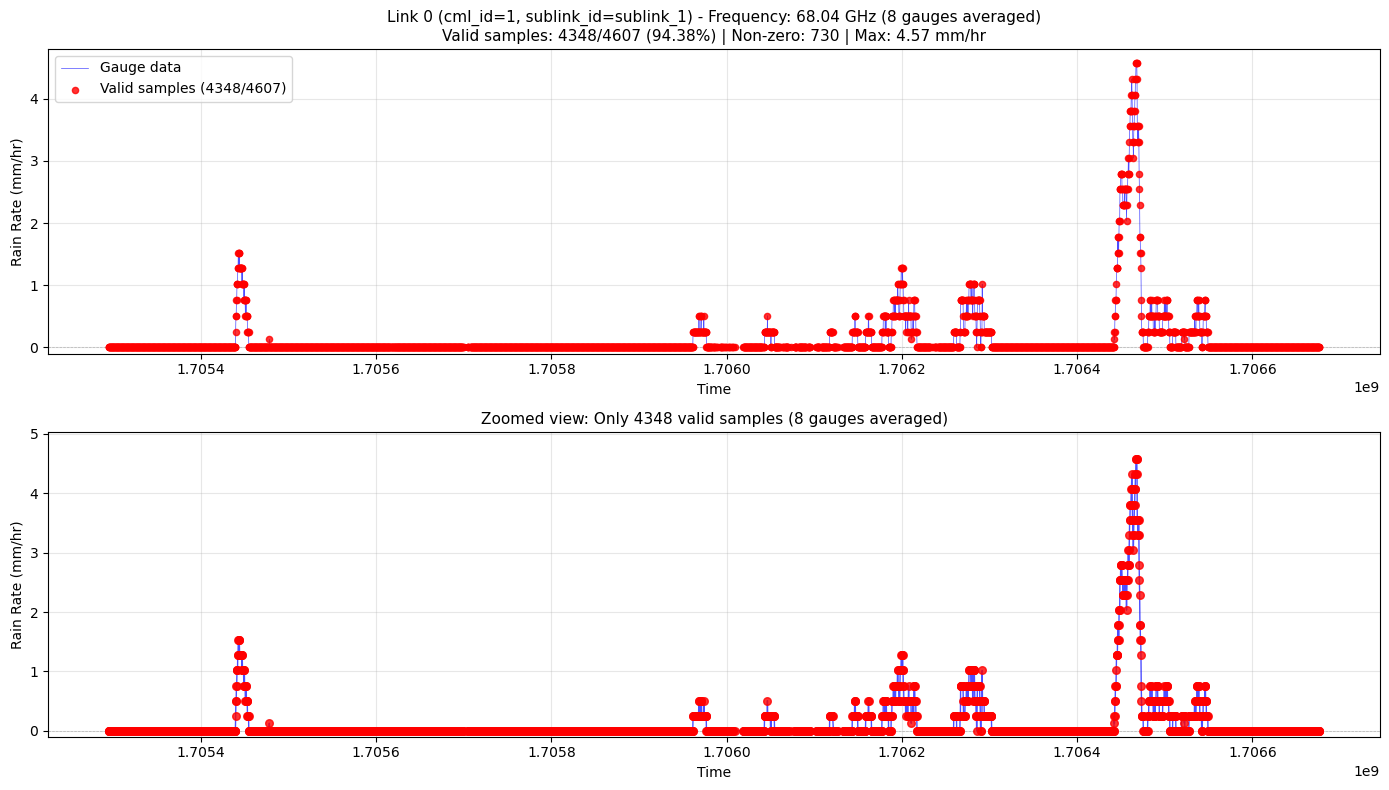

Link 0: 4348/4607 valid (94.38%), non-zero: 730, max: 4.57 mm/hr, gauges used: 8



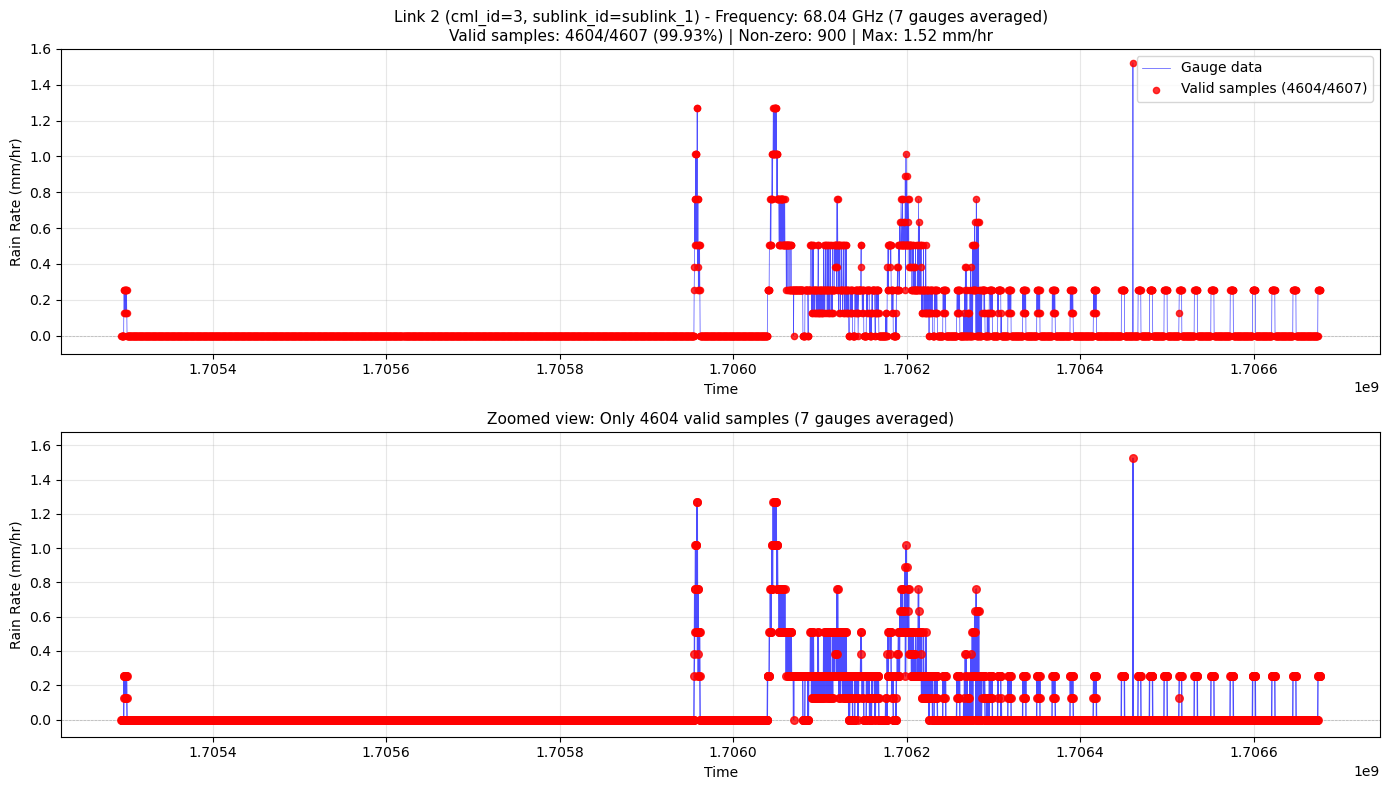

Link 2: 4604/4607 valid (99.93%), non-zero: 900, max: 1.52 mm/hr, gauges used: 7



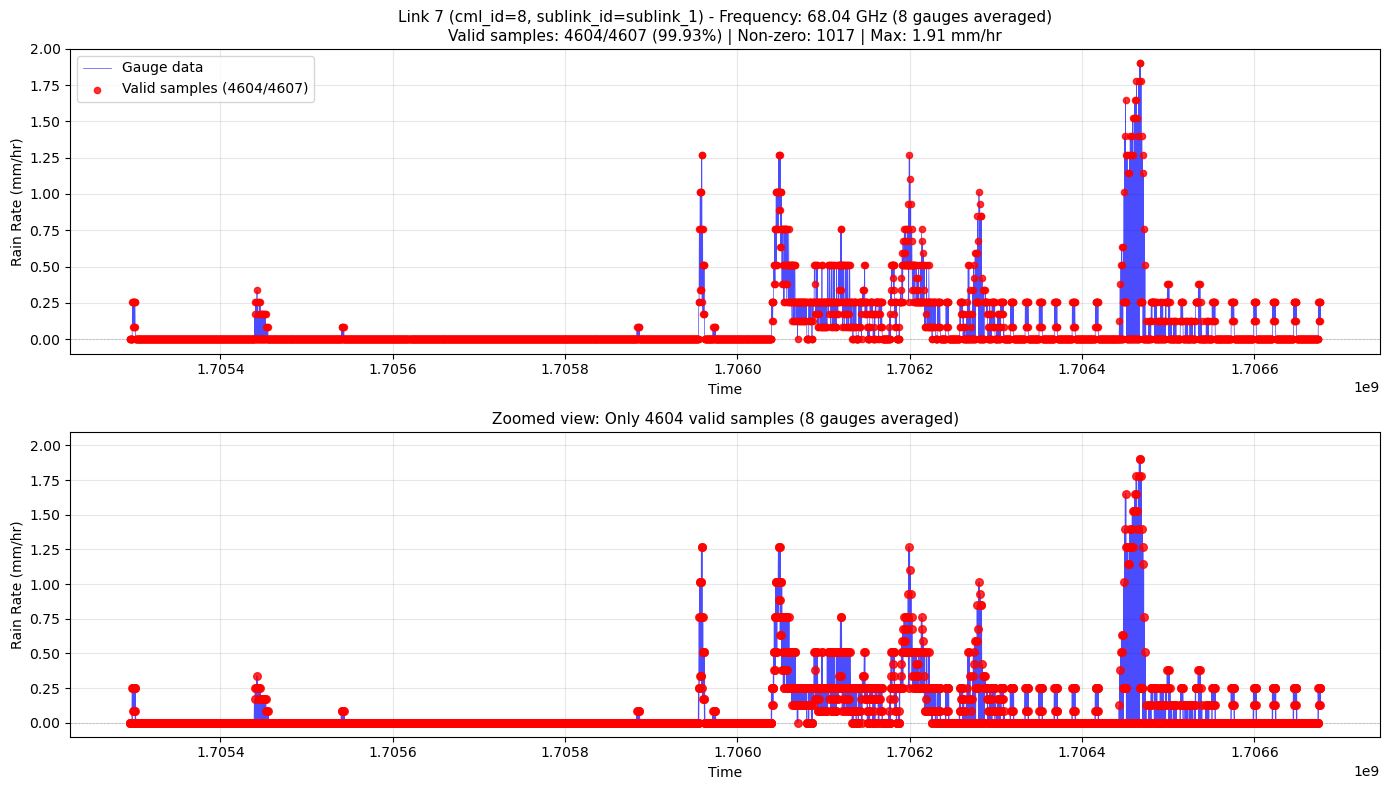

Link 7: 4604/4607 valid (99.93%), non-zero: 1017, max: 1.91 mm/hr, gauges used: 8



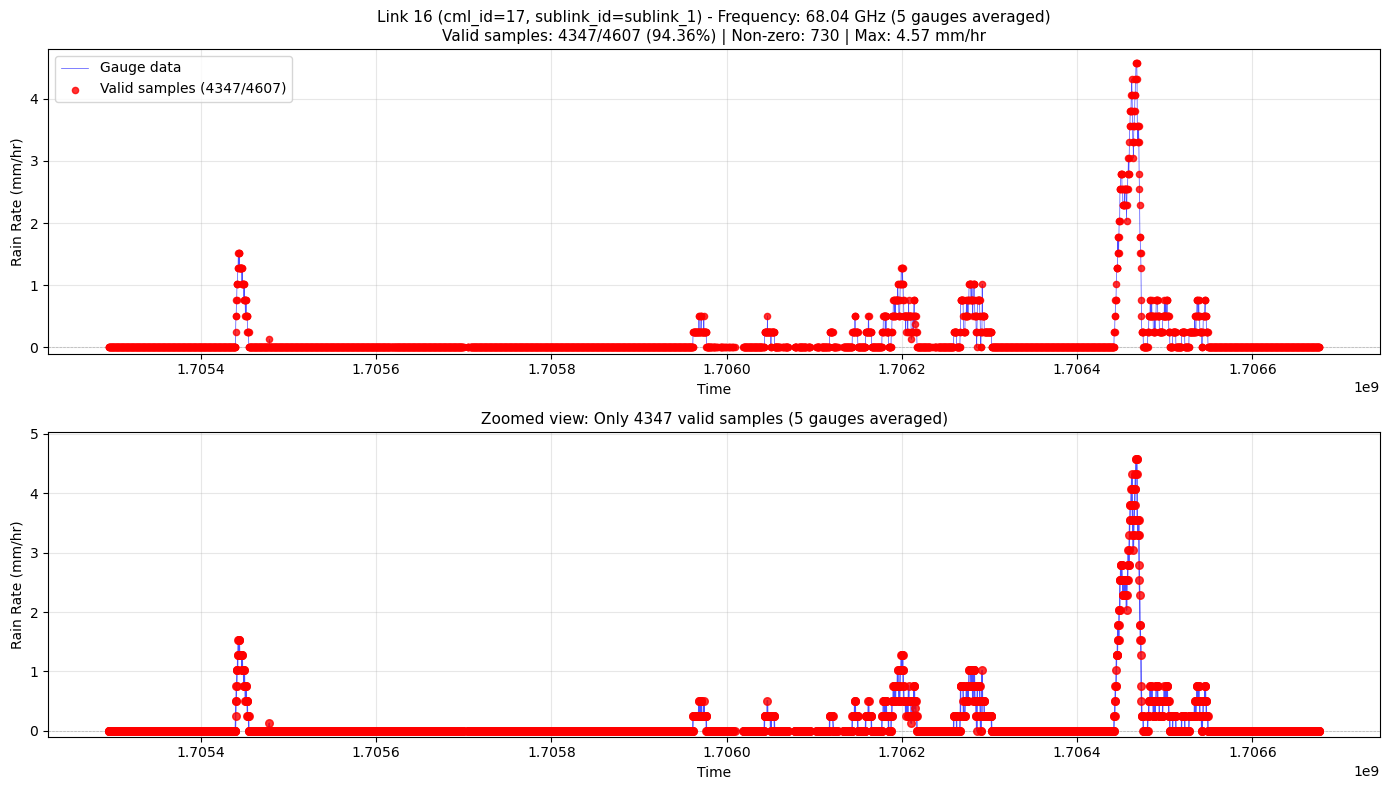

Link 16: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



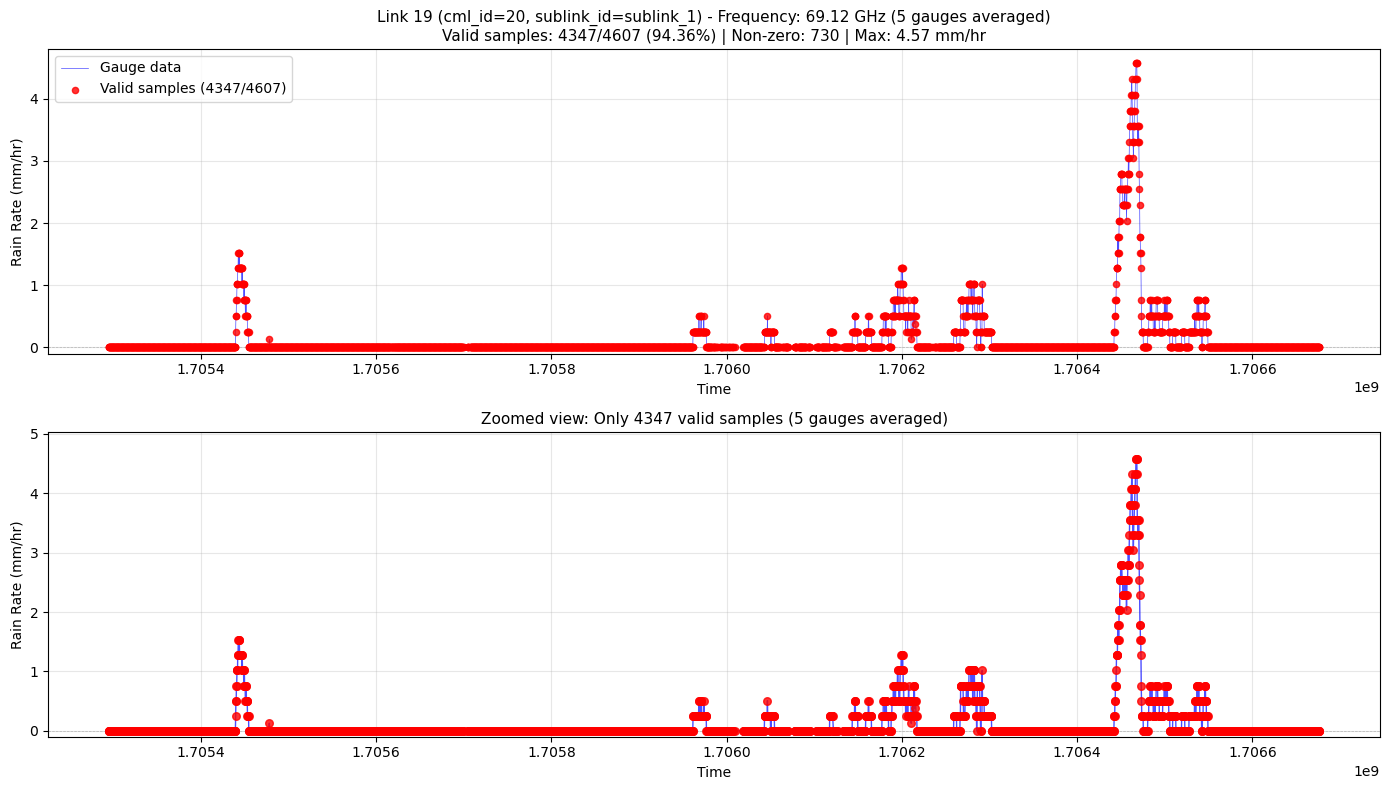

Link 19: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



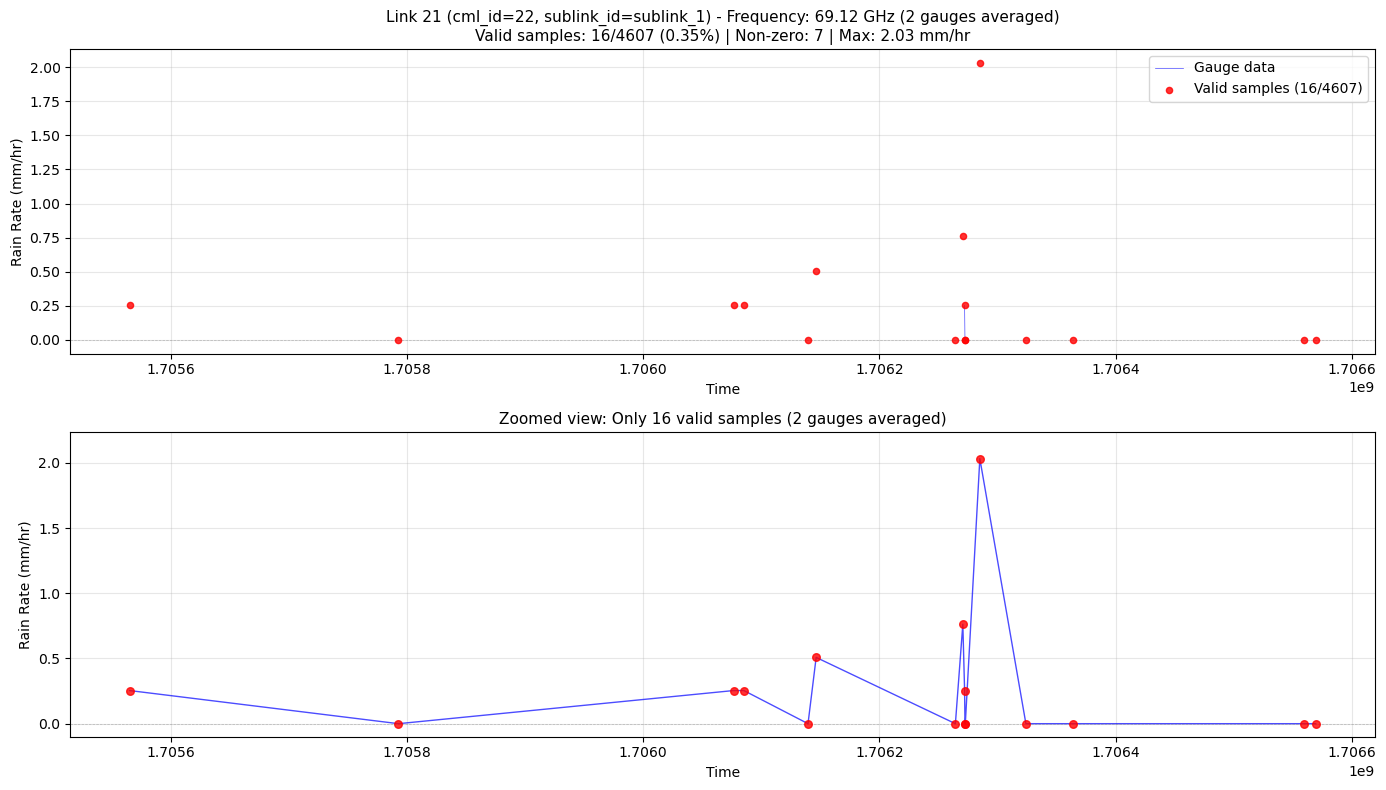

Link 21: 16/4607 valid (0.35%), non-zero: 7, max: 2.03 mm/hr, gauges used: 2



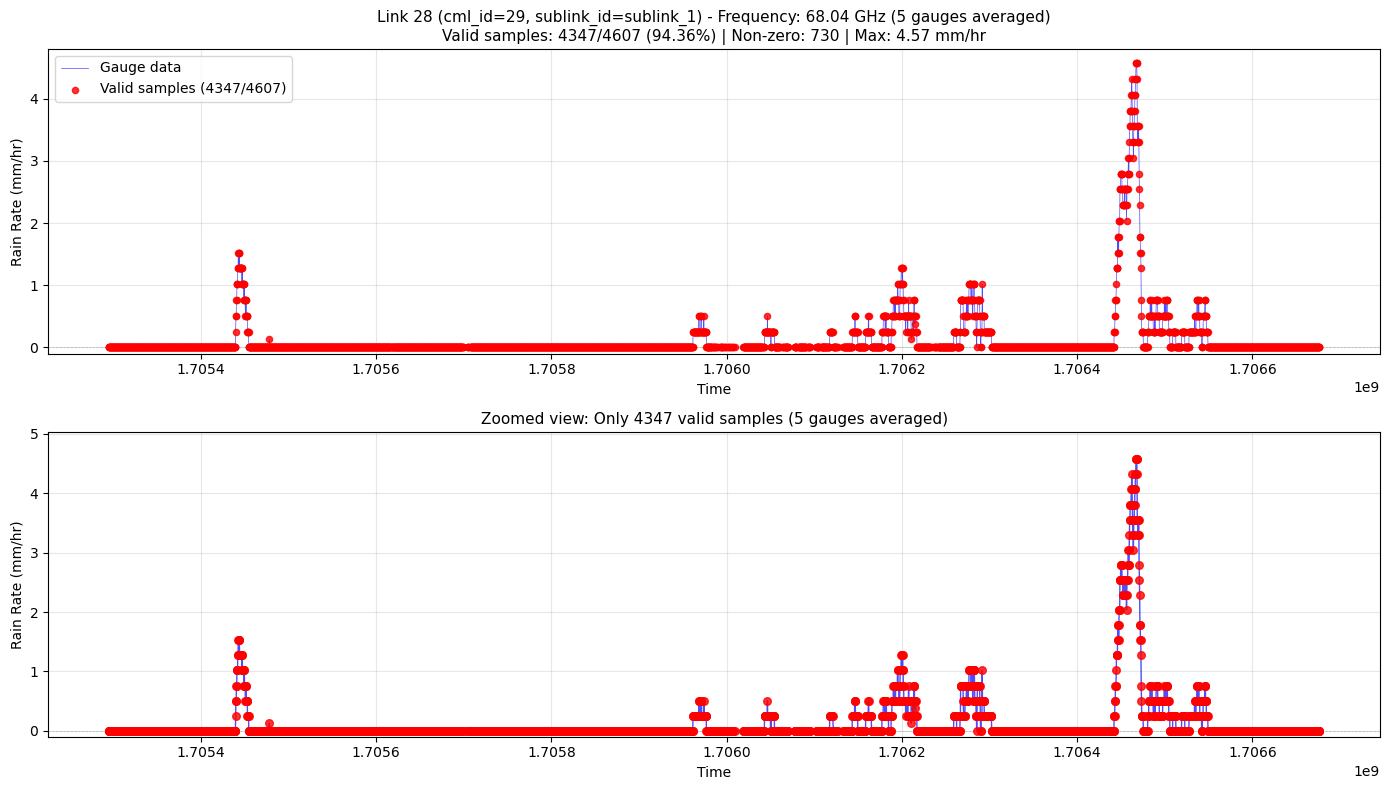

Link 28: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



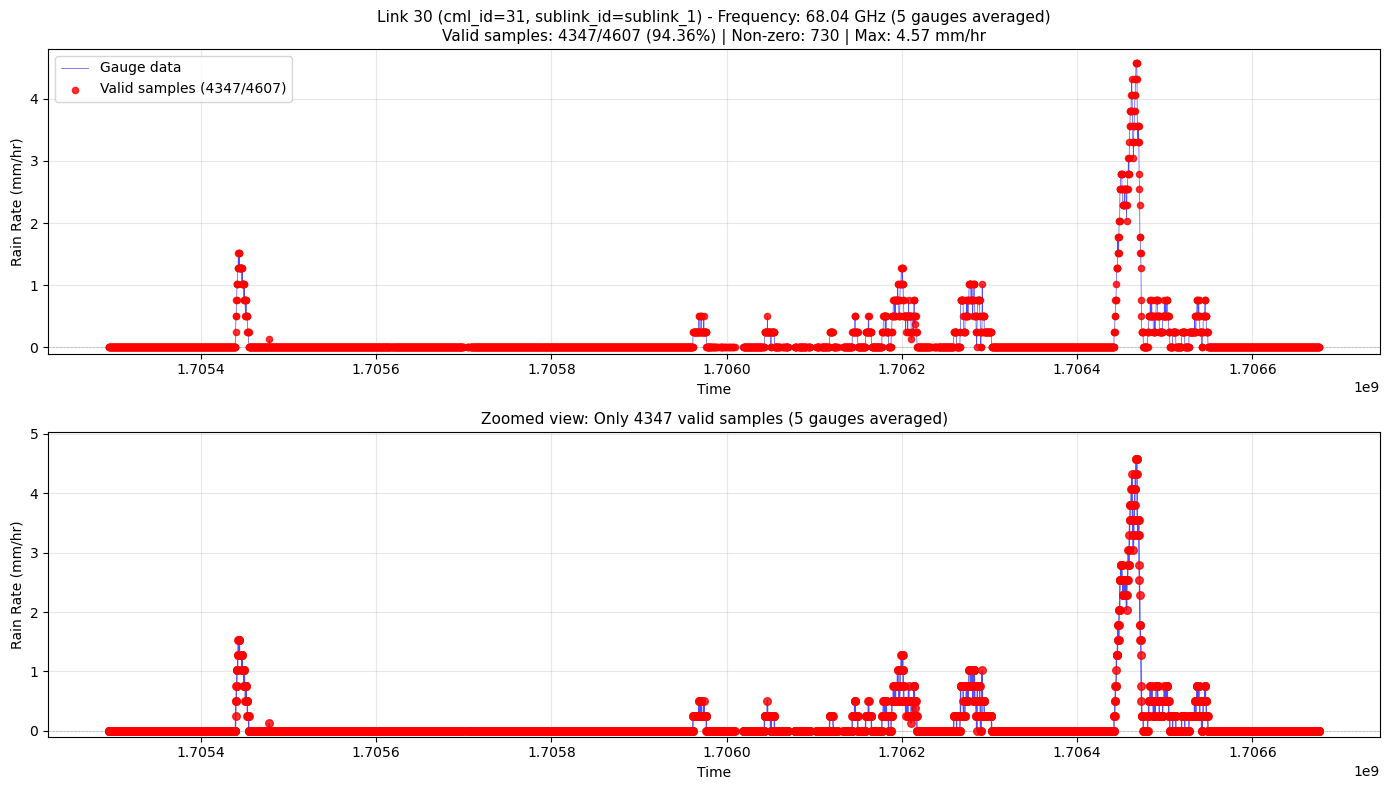

Link 30: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



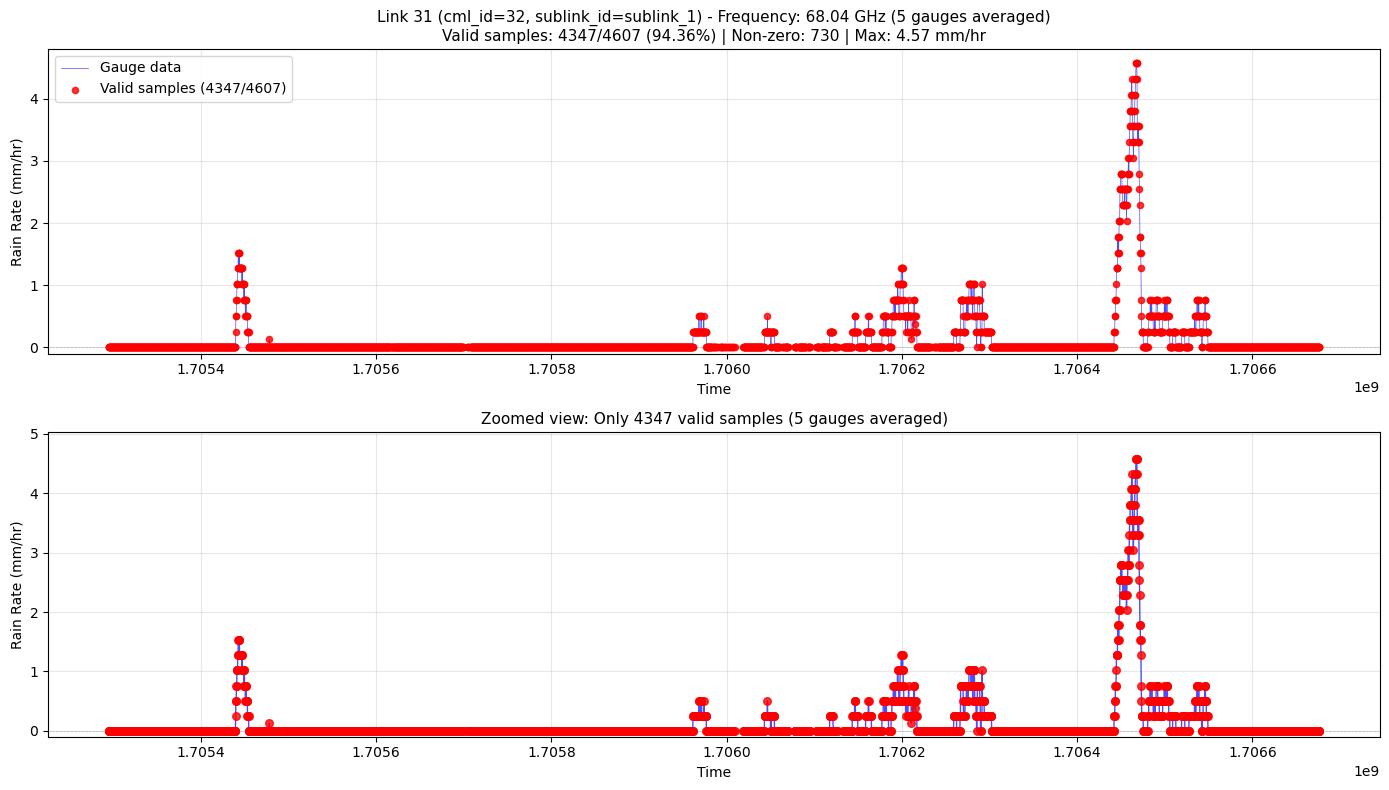

Link 31: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



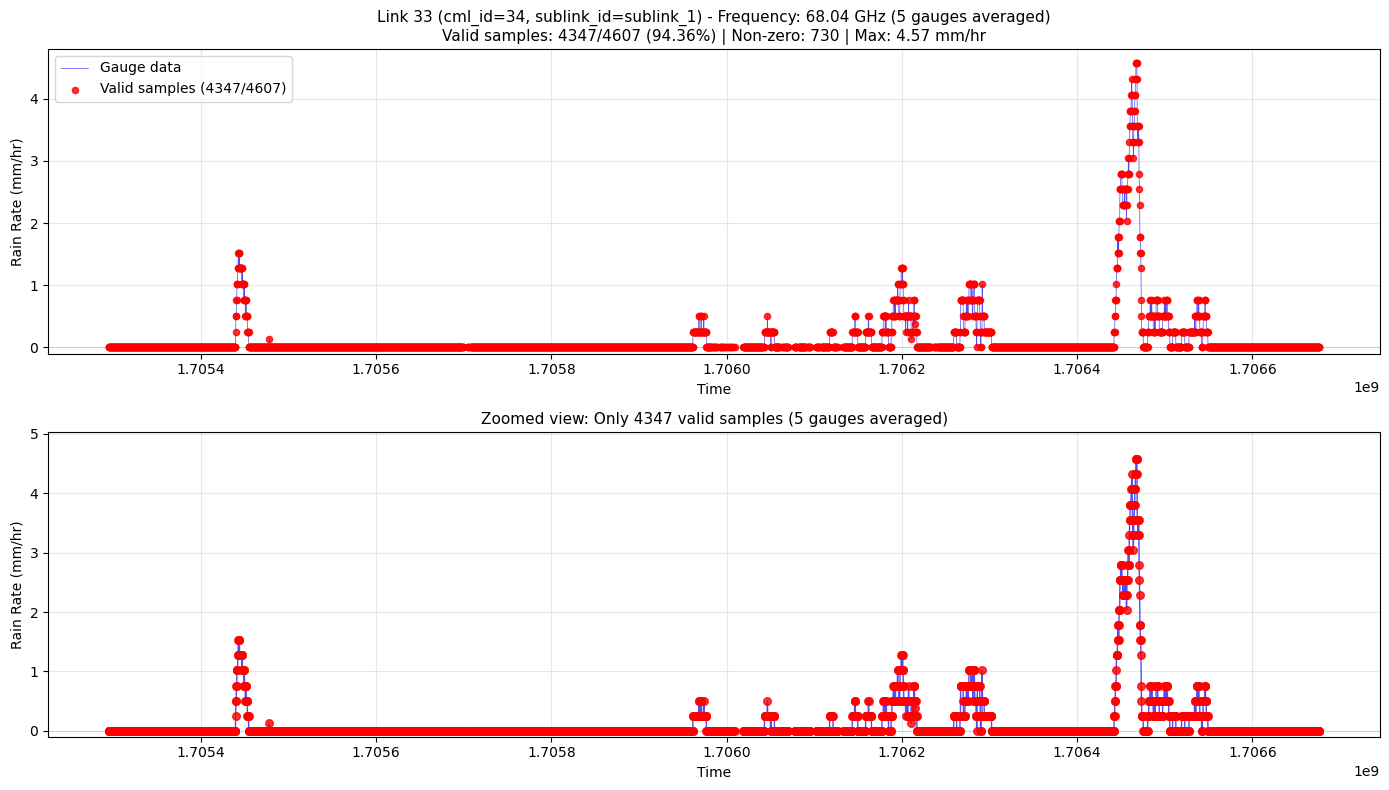

Link 33: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



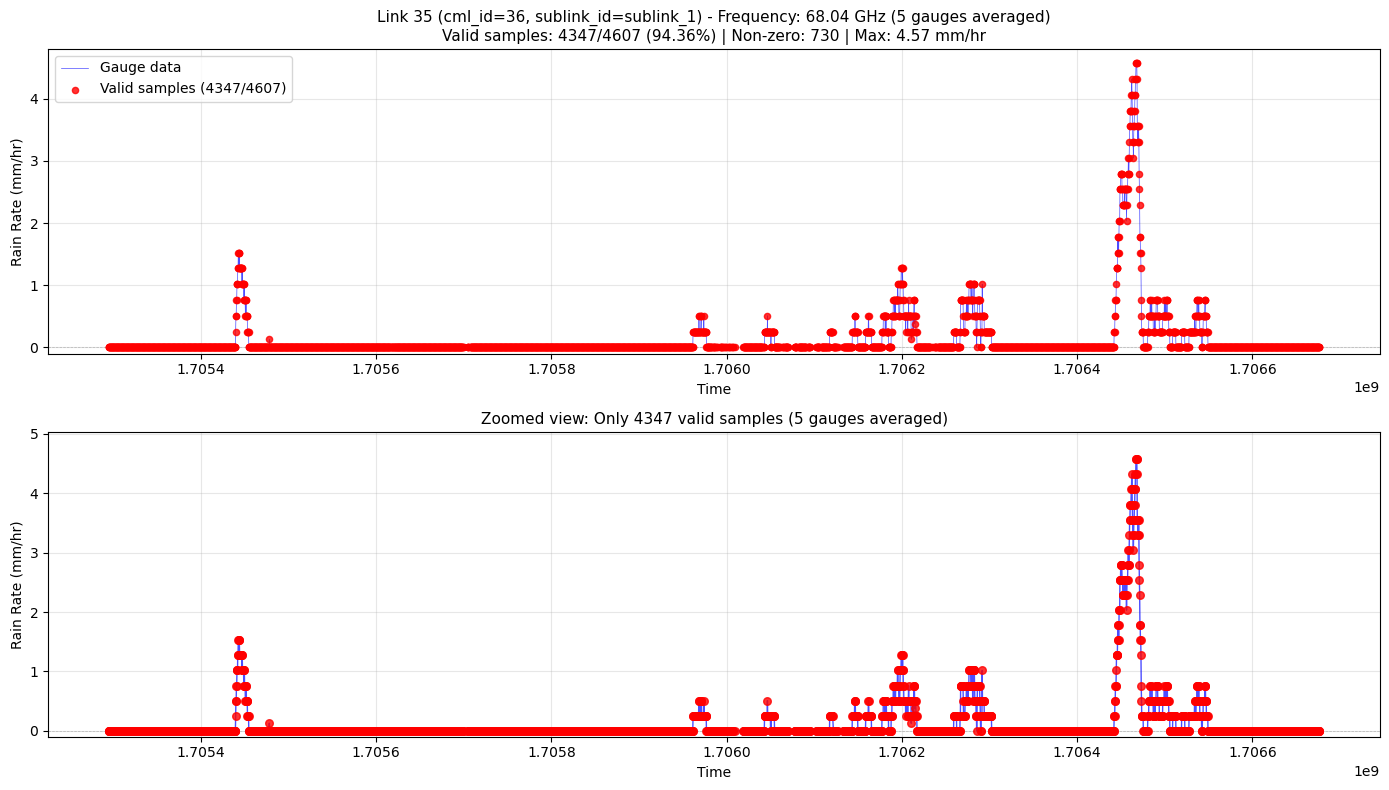

Link 35: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



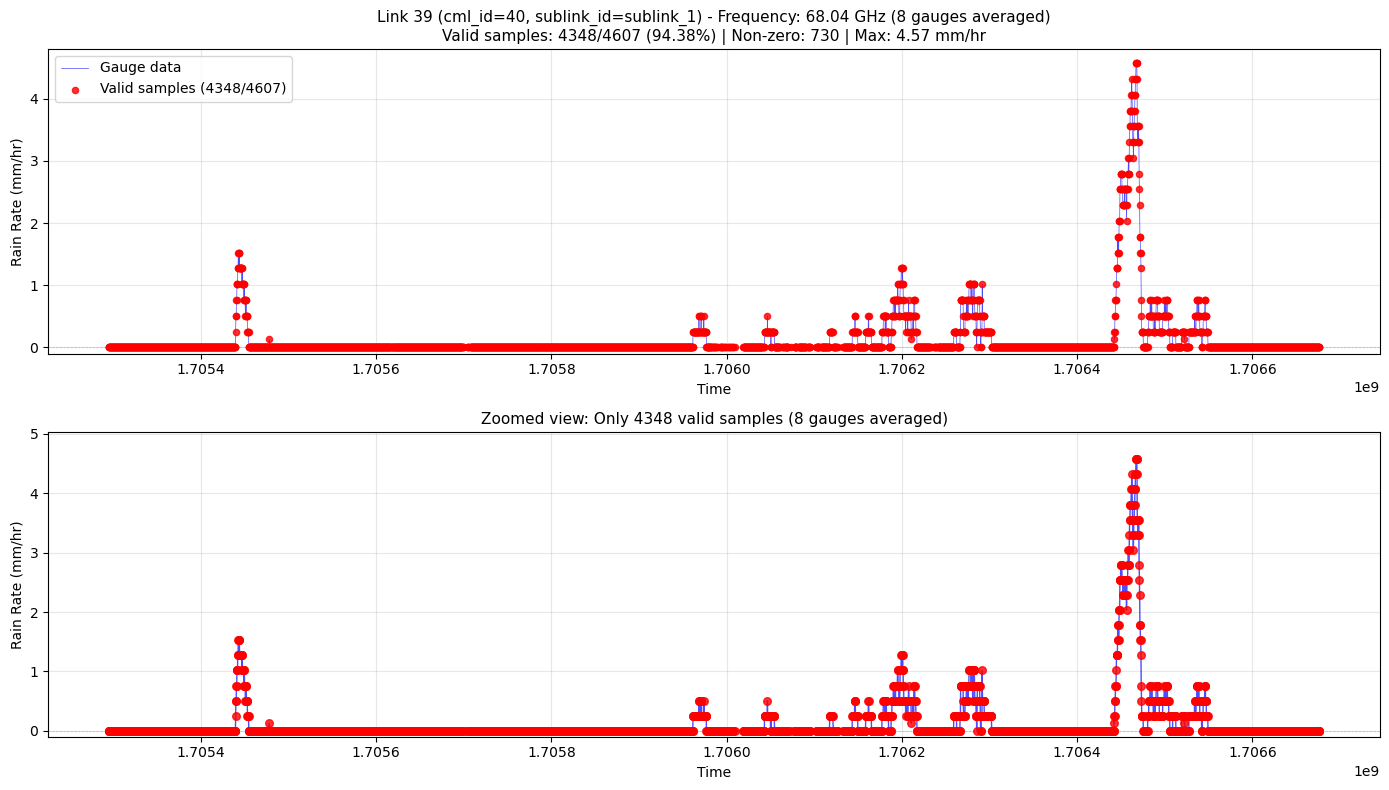

Link 39: 4348/4607 valid (94.38%), non-zero: 730, max: 4.57 mm/hr, gauges used: 8



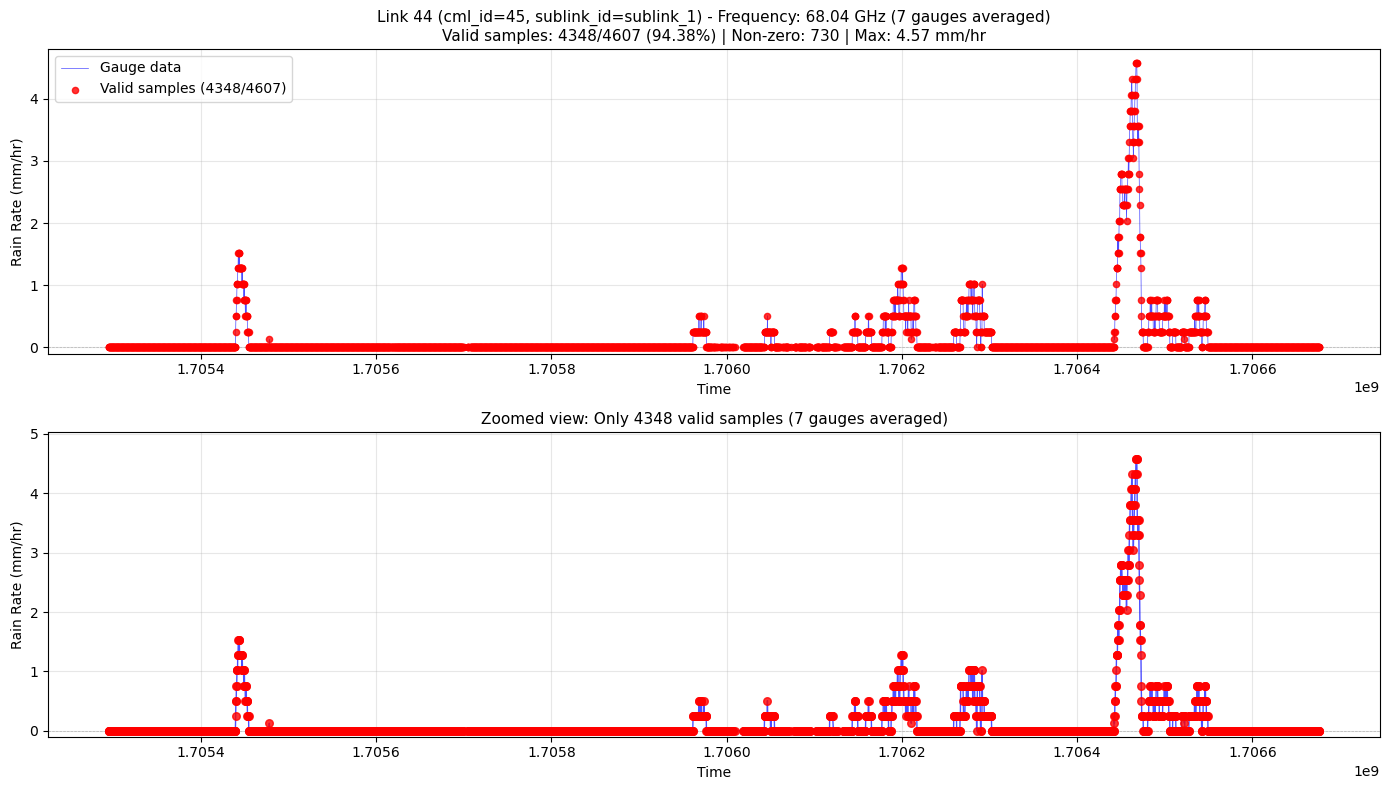

Link 44: 4348/4607 valid (94.38%), non-zero: 730, max: 4.57 mm/hr, gauges used: 7



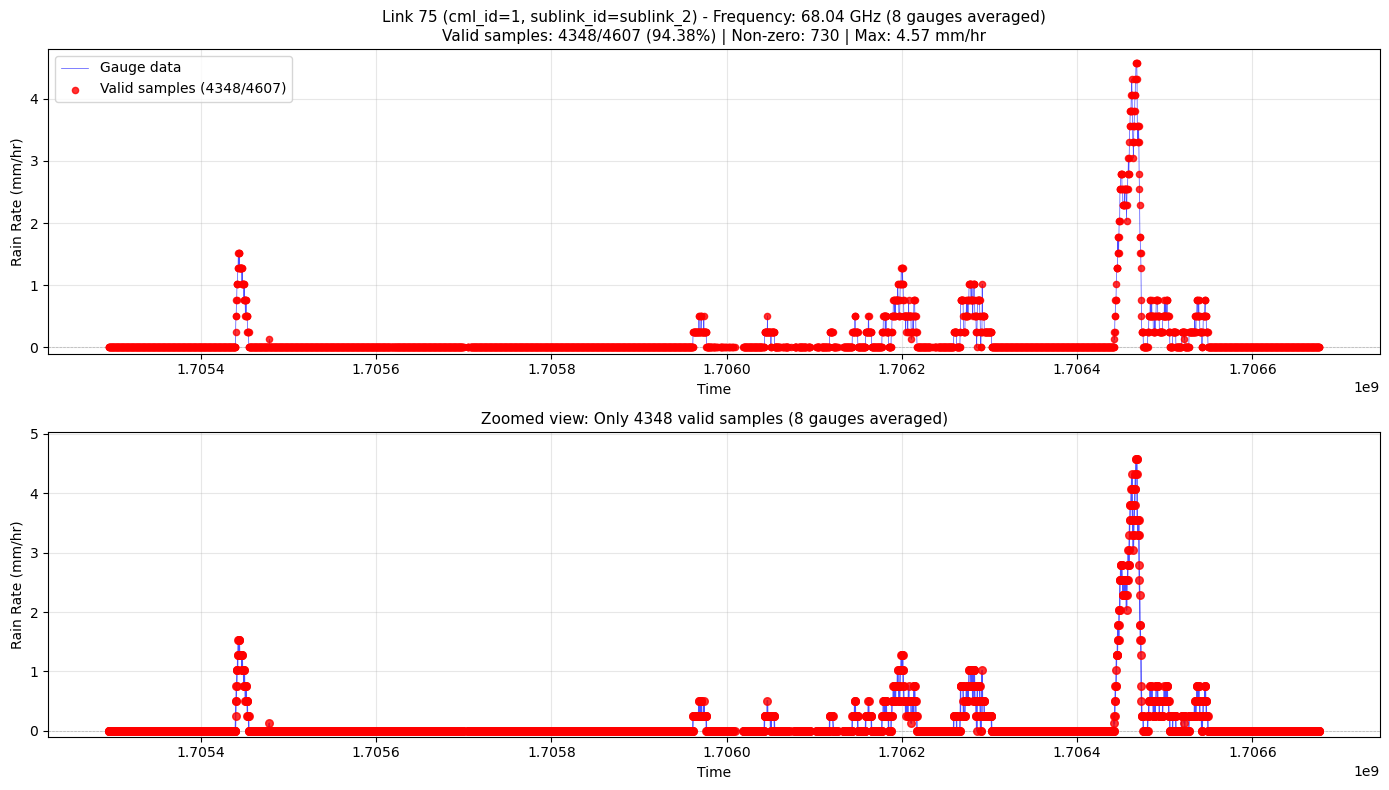

Link 75: 4348/4607 valid (94.38%), non-zero: 730, max: 4.57 mm/hr, gauges used: 8



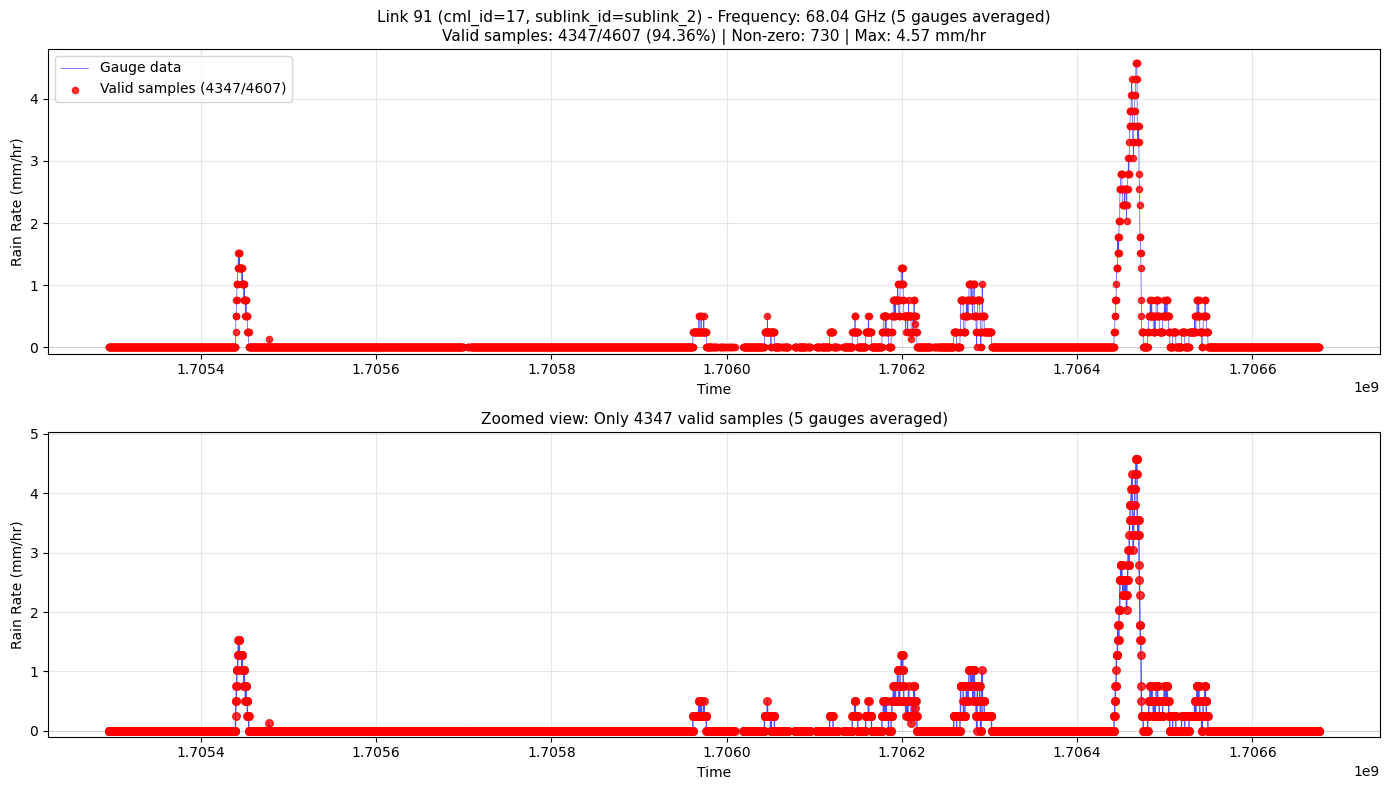

Link 91: 4347/4607 valid (94.36%), non-zero: 730, max: 4.57 mm/hr, gauges used: 5



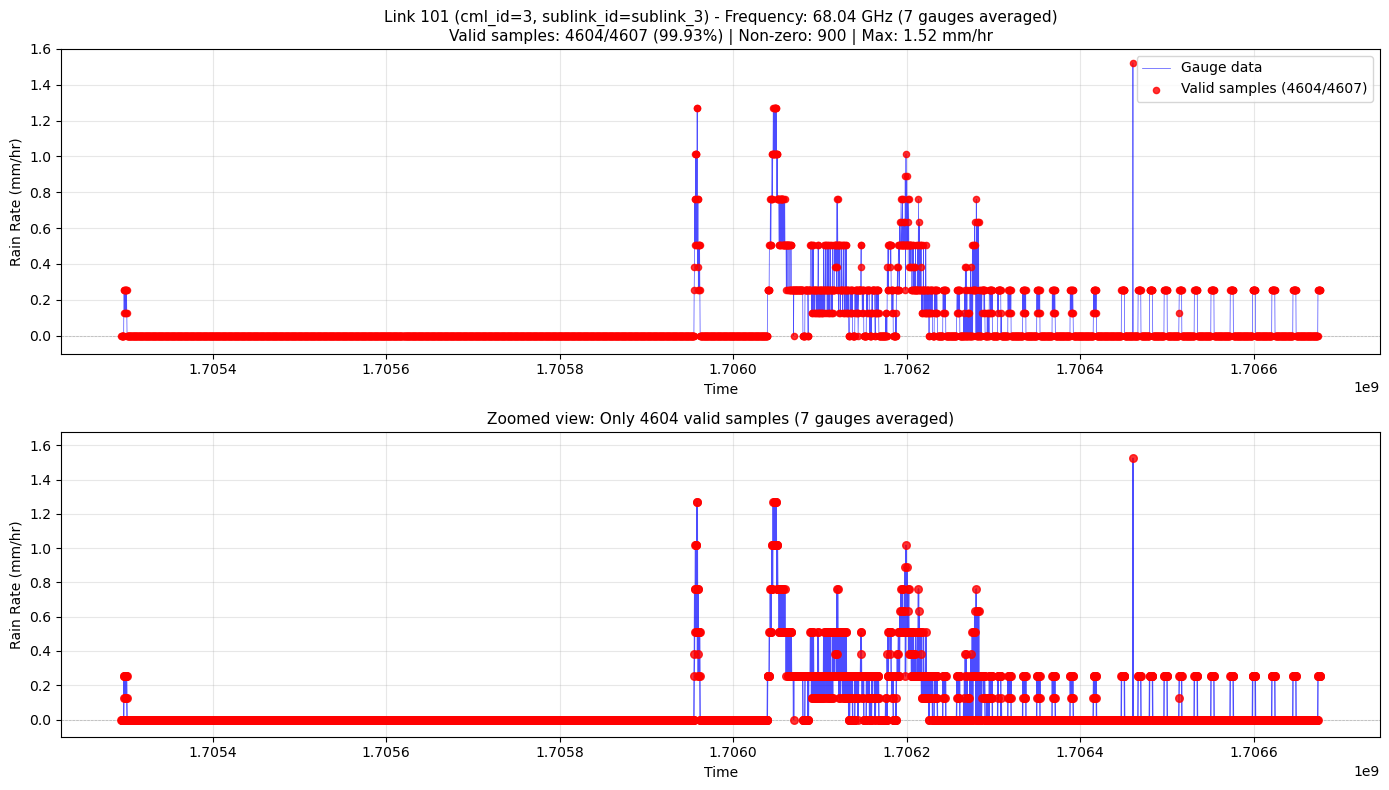

Link 101: 4604/4607 valid (99.93%), non-zero: 900, max: 1.52 mm/hr, gauges used: 7



In [118]:
# Enhanced visualization with statistics
for i in highfreqID:
    link = link_set.get_link(i)
    if link.gauge_ref:
        gauge = link.gauge_ref[0]
        data = gauge.data_array
        time = gauge.time_array
        
        # Calculate statistics
        valid_mask = ~np.isnan(data)
        valid_count = np.sum(valid_mask)
        total_count = len(data)
        valid_ratio = valid_count / total_count if total_count > 0 else 0
        
        # Get number of gauges used for averaging
        num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
        gauge_info = f"({num_gauges_used} gauge{'s' if num_gauges_used != 1 else ''} averaged)" if num_gauges_used > 0 else "(no gauges)"
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Plot 1: Full time series (shows NaN gaps)
        ax1 = axes[0]
        ax1.plot(time, data, 'b-', linewidth=0.5, alpha=0.7, label='Gauge data')
        ax1.scatter(time[valid_mask], data[valid_mask], c='red', s=20, alpha=0.8, 
                   label=f'Valid samples ({valid_count}/{total_count})', zorder=5)
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Rain Rate (mm/hr)')
        ax1.set_title(f'Link {i} (cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id}) - '
                     f'Frequency: {link.meta_data.frequency:.2f} GHz {gauge_info}\n'
                     f'Valid samples: {valid_count}/{total_count} ({valid_ratio*100:.2f}%) | '
                     f'Non-zero: {np.sum((data[valid_mask] > 0))} | '
                     f'Max: {np.nanmax(data):.2f} mm/hr', fontsize=11)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(bottom=-0.1)
        
        # Plot 2: Zoomed view of valid samples only
        ax2 = axes[1]
        if valid_count > 0:
            valid_data = data[valid_mask]
            valid_time = time[valid_mask]
            ax2.plot(valid_time, valid_data, 'b-', linewidth=1, alpha=0.7)
            ax2.scatter(valid_time, valid_data, c='red', s=30, alpha=0.8, zorder=5)
            ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Rain Rate (mm/hr)')
            ax2.set_title(f'Zoomed view: Only {valid_count} valid samples {gauge_info}', fontsize=11)
            ax2.grid(True, alpha=0.3)
            if len(valid_data) > 0:
                y_max = np.max(valid_data) * 1.1 if np.max(valid_data) > 0 else 1.0
                ax2.set_ylim(bottom=-0.1, top=max(y_max, 0.5))
        else:
            ax2.text(0.5, 0.5, 'No valid samples', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=14)
            ax2.set_title('No valid data', fontsize=11)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"Link {i}: {valid_count}/{total_count} valid ({valid_ratio*100:.2f}%), "
              f"non-zero: {np.sum((data[valid_mask] > 0))}, "
              f"max: {np.nanmax(data):.2f} mm/hr, "
              f"gauges used: {num_gauges_used}")
        print()

In [119]:
# ============================================================================
# ANALYSIS: Links with Blank/Empty Average Rain Gauges
# ============================================================================

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import math

print("=" * 70)
print("ANALYZING LINKS WITH BLANK/EMPTY GAUGE REFERENCES")
print("=" * 70)

# Helper function to check if gauge is blank/empty or has very few valid samples
def is_blank_gauge(gauge_ref, min_valid_samples=50):
    """
    Check if gauge reference is blank/empty or has very few valid samples
    
    Parameters:
    -----------
    gauge_ref : list or None
        Gauge reference from link
    min_valid_samples : int
        Minimum number of non-NaN samples to consider gauge as valid (default: 10)
    
    Returns:
    --------
    bool : True if gauge is blank/sparse, False otherwise
    int : Number of valid (non-NaN) samples
    """
    if gauge_ref is None or len(gauge_ref) == 0:
        return True, 0
    
    gauge = gauge_ref[0]
    
    # Check if data is empty
    if len(gauge.data_array) == 0:
        return True, 0
    
    # Count valid (non-NaN) samples
    valid_samples = np.sum(~np.isnan(gauge.data_array))
    total_samples = len(gauge.data_array)
    
    # Check if all values are NaN
    if valid_samples == 0:
        return True, 0
    
    # Check if all values are zero (might also be considered blank)
    if np.nansum(gauge.data_array) == 0:
        return True, valid_samples
    
    # Check if has very few valid samples (sparse data)
    if valid_samples < 50:
        return True, valid_samples
    
    return False, valid_samples

# 1. Identify links with blank gauges (high frequency only)
print("\n1. HIGH FREQUENCY LINKS WITH BLANK/SPARSE GAUGES:")
print("-" * 70)
blank_highfreq = []
blank_highfreq_stats = []  # Store statistics for each blank gauge
all_highfreq_stats = []  # Store stats for ALL high-freq links for comparison
min_valid_samples = 10  # Threshold for considering gauge as sparse

print(f"  Checking {len(highfreqID)} high-frequency links with threshold: {min_valid_samples} valid samples")
print()

for i in highfreqID:
    link = link_set.get_link(i)
    
    # Check if gauge_ref exists
    if not link.gauge_ref or len(link.gauge_ref) == 0:
        blank_highfreq.append(i)
        blank_highfreq_stats.append({
            'link_idx': i,
            'valid_samples': 0,
            'total_samples': 0,
            'valid_ratio': 0
        })
        num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
        print(f"  Link {i}: cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id}, "
              f"freq={link.meta_data.frequency:.2f} GHz - NO GAUGE REF (gauges used: {num_gauges_used})")
        continue
    
    # Get gauge data
    gauge = link.gauge_ref[0]
    data = gauge.data_array
    total_samples = len(data)
    valid_count = np.sum(~np.isnan(data))
    valid_ratio = valid_count / total_samples if total_samples > 0 else 0
    
    # Store stats for all links
    all_highfreq_stats.append({
        'link_idx': i,
        'valid_samples': valid_count,
        'total_samples': total_samples,
        'valid_ratio': valid_ratio
    })
    
    # Check if blank/sparse
    is_blank, valid_count_check = is_blank_gauge(link.gauge_ref, 50)
    
    if is_blank:
        blank_highfreq.append(i)
        blank_highfreq_stats.append({
            'link_idx': i,
            'valid_samples': valid_count,
            'total_samples': total_samples,
            'valid_ratio': valid_ratio
        })
        # Get number of gauges used
        num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
        
        print(f"  Link {i}: cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id}, "
              f"freq={link.meta_data.frequency:.2f} GHz, "
              f"valid samples: {valid_count}/{total_samples} ({valid_ratio*100:.1f}%), "
              f"gauges used: {num_gauges_used}")

print(f"\n  Total: {len(blank_highfreq)} out of {len(highfreqID)} high-frequency links have blank/sparse gauges")

# Show statistics for ALL high-freq links (for debugging)
if all_highfreq_stats:
    valid_counts = [s['valid_samples'] for s in all_highfreq_stats]
    print(f"\n  Statistics for ALL high-frequency links:")
    print(f"    Min valid samples: {np.min(valid_counts)}")
    print(f"    Max valid samples: {np.max(valid_counts)}")
    print(f"    Mean valid samples: {np.mean(valid_counts):.1f}")
    print(f"    Median valid samples: {np.median(valid_counts):.1f}")
    print(f"    Links with < {min_valid_samples} valid samples: {sum(1 for c in valid_counts if c < min_valid_samples)}")

if blank_highfreq_stats:
    avg_valid = np.mean([s['valid_samples'] for s in blank_highfreq_stats])
    print(f"  Average valid samples in blank gauges: {avg_valid:.1f}")

# 2. Identify ALL links with blank gauges (not just high frequency)
print("\n2. ALL LINKS WITH BLANK/SPARSE GAUGES:")
print("-" * 70)
blank_all = []
blank_all_stats = []  # Store statistics for all blank gauges

for i in range(len(link_set)):
    link = link_set.get_link(i)
    is_blank, valid_count = is_blank_gauge(link.gauge_ref, min_valid_samples)
    if is_blank:
        blank_all.append(i)
        total_samples = len(link.gauge_ref[0].data_array) if link.gauge_ref and len(link.gauge_ref) > 0 else 0
        num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
        blank_all_stats.append({
            'link_idx': i,
            'valid_samples': valid_count,
            'total_samples': total_samples,
            'valid_ratio': valid_count / total_samples if total_samples > 0 else 0,
            'num_gauges_used': num_gauges_used
        })

print(f"  Total: {len(blank_all)} out of {len(link_set)} total links have blank/sparse gauges")
print(f"  Blank links: {blank_all[:10]}{'...' if len(blank_all) > 10 else ''}")

# Show statistics about valid samples
if blank_all_stats:
    valid_counts = [s['valid_samples'] for s in blank_all_stats]
    valid_ratios = [s['valid_ratio'] for s in blank_all_stats]
    print(f"\n  Valid sample statistics for blank gauges:")
    print(f"    Min valid samples: {np.min(valid_counts)}")
    print(f"    Max valid samples: {np.max(valid_counts)}")
    print(f"    Mean valid samples: {np.mean(valid_counts):.1f}")
    print(f"    Median valid samples: {np.median(valid_counts):.1f}")
    print(f"    Mean valid ratio: {np.mean(valid_ratios)*100:.2f}%")
    print(f"    Median valid ratio: {np.median(valid_ratios)*100:.2f}%")
    
    # Count by category
    fully_empty = sum(1 for s in blank_all_stats if s['valid_samples'] == 0)
    very_sparse = sum(1 for s in blank_all_stats if 0 < s['valid_samples'] < min_valid_samples)
    print(f"\n  Breakdown:")
    print(f"    Fully empty (0 valid samples): {fully_empty}")
    print(f"    Very sparse (1-{min_valid_samples-1} valid samples): {very_sparse}")
    
    # Show gauge count statistics
    gauge_counts = [s['num_gauges_used'] for s in blank_all_stats]
    print(f"\n  Gauge count statistics for blank/sparse links:")
    print(f"    Min gauges used: {min(gauge_counts) if gauge_counts else 0}")
    print(f"    Max gauges used: {max(gauge_counts) if gauge_counts else 0}")
    print(f"    Mean gauges used: {np.mean(gauge_counts):.1f}" if gauge_counts else "    Mean gauges used: 0.0")
    print(f"    Median gauges used: {np.median(gauge_counts):.1f}" if gauge_counts else "    Median gauges used: 0.0")
    if gauge_counts:
        unique_counts, count_freq = np.unique(gauge_counts, return_counts=True)
        print(f"    Distribution: {dict(zip(unique_counts, count_freq))}")

# 3. Calculate link center coordinates
def get_link_center(link):
    """Get center coordinates of a link"""
    xy = link.meta_data.xy_center()
    return xy[0], xy[1]  # x, y in UTM coordinates

# Get centers for all links
all_link_centers = np.array([get_link_center(link_set.get_link(i)) for i in range(len(link_set))])
blank_link_centers = np.array([get_link_center(link_set.get_link(i)) for i in blank_all])
non_blank_link_centers = np.array([get_link_center(link_set.get_link(i)) 
                                   for i in range(len(link_set)) if i not in blank_all])

# 4. Calculate distances from blank links to other links
print("\n3. SPATIAL DISTRIBUTION ANALYSIS:")
print("-" * 70)

if len(blank_all) > 0 and len(non_blank_link_centers) > 0:
    # Calculate distances from each blank link to all non-blank links
    distances_to_other_links = cdist(blank_link_centers, non_blank_link_centers)
    
    min_distances = np.min(distances_to_other_links, axis=1)
    mean_distances = np.mean(distances_to_other_links, axis=1)
    max_distances = np.max(distances_to_other_links, axis=1)
    
    print(f"\n  Distance statistics (blank links to non-blank links):")
    print(f"    Min distance: {np.min(min_distances):.1f} m")
    print(f"    Max distance: {np.max(min_distances):.1f} m")
    print(f"    Mean min distance: {np.mean(min_distances):.1f} m")
    print(f"    Median min distance: {np.median(min_distances):.1f} m")
    
    # Check if blank links are isolated
    isolation_threshold = 2000  # 2 km
    isolated_links = [blank_all[i] for i in range(len(blank_all)) if min_distances[i] > isolation_threshold]
    print(f"\n  Isolated links (> {isolation_threshold/1000:.1f} km from nearest non-blank link): {len(isolated_links)}")
    if isolated_links:
        print(f"    Isolated link indices: {isolated_links}")

# 5. Find nearby gauge stations for blank links
print("\n4. NEARBY GAUGE STATIONS FOR BLANK LINKS:")
print("-" * 70)

# Get all gauge locations
gauge_locations = np.array([[g.x, g.y] for g in ps.point_set])

if len(blank_all) > 0 and len(gauge_locations) > 0:
    # Calculate distances from blank links to all gauges
    distances_to_gauges = cdist(blank_link_centers, gauge_locations)
    
    # Find nearest gauge for each blank link
    nearest_gauge_distances = np.min(distances_to_gauges, axis=1)
    nearest_gauge_indices = np.argmin(distances_to_gauges, axis=1)
    
    print(f"\n  Nearest gauge distances for blank links:")
    print(f"    Min: {np.min(nearest_gauge_distances):.1f} m")
    print(f"    Max: {np.max(nearest_gauge_distances):.1f} m")
    print(f"    Mean: {np.mean(nearest_gauge_distances):.1f} m")
    print(f"    Median: {np.median(nearest_gauge_distances):.1f} m")
    
    # Check which blank links are far from all gauges
    max_distance_threshold = 5000  # 5 km (same as max_distance used in link creation)
    far_from_gauges = [blank_all[i] for i in range(len(blank_all)) 
                       if nearest_gauge_distances[i] > max_distance_threshold]
    print(f"\n  Links > {max_distance_threshold/1000:.1f} km from nearest gauge: {len(far_from_gauges)}")
    if far_from_gauges:
        print(f"    Far link indices: {far_from_gauges}")
        for link_idx in far_from_gauges[:5]:  # Show first 5
            link = link_set.get_link(link_idx)
            nearest_idx = nearest_gauge_indices[blank_all.index(link_idx)]
            nearest_gauge = ps.point_set[nearest_idx]
            distance = nearest_gauge_distances[blank_all.index(link_idx)]
            print(f"      Link {link_idx} (cml_id={link.meta_data.cml_id}): "
                  f"{distance:.1f} m from gauge at ({nearest_gauge.lat:.4f}, {nearest_gauge.lon:.4f})")
    
    # Show detailed info for high-frequency blank links
    print("\n5. DETAILED INFO FOR HIGH-FREQUENCY BLANK LINKS:")
    print("-" * 70)
    for link_idx in blank_highfreq[:10]:  # Show first 10
        link = link_set.get_link(link_idx)
        center_x, center_y = get_link_center(link)
        
        # Find nearest gauge (link_idx should be in blank_all)
        if link_idx in blank_all:
            blank_idx = blank_all.index(link_idx)
            nearest_gauge_idx = nearest_gauge_indices[blank_idx]
            nearest_gauge = ps.point_set[nearest_gauge_idx]
            distance = nearest_gauge_distances[blank_idx]
            
            # Find all gauges within max_distance
            distances_to_all_gauges = distances_to_gauges[blank_idx]
            nearby_gauges = [(i, d) for i, d in enumerate(distances_to_all_gauges) 
                            if d <= max_distance_threshold]
            nearby_gauges.sort(key=lambda x: x[1])
            
            # Get valid sample info
            is_blank_check, valid_count_check = is_blank_gauge(link.gauge_ref, min_valid_samples)
            total_samples_check = len(link.gauge_ref[0].data_array) if link.gauge_ref and len(link.gauge_ref) > 0 else 0
            
            # Get number of gauges used for averaging
            num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
            
            print(f"\n  Link {link_idx} (cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id}):")
            print(f"    Frequency: {link.meta_data.frequency:.2f} GHz")
            print(f"    Center: ({center_x:.1f}, {center_y:.1f}) UTM")
            print(f"    Gauge data: {valid_count_check}/{total_samples_check} valid samples ({valid_count_check/total_samples_check*100:.1f}%)")
            print(f"    Number of gauges used for average: {num_gauges_used}")
            print(f"    Nearest gauge: {distance:.1f} m away")
            print(f"    Gauges within {max_distance_threshold/1000:.1f} km: {len(nearby_gauges)}")
            if nearby_gauges:
                print(f"      Nearby gauges:")
                for gauge_idx, dist in nearby_gauges[:5]:  # Show first 5
                    gauge = ps.point_set[gauge_idx]
                    print(f"        - Gauge {gauge_idx}: {dist:.1f} m at ({gauge.lat:.4f}, {gauge.lon:.4f})")
            else:
                print(f"      ⚠️  No gauges within {max_distance_threshold/1000:.1f} km!")
        else:
            # This shouldn't happen, but handle it gracefully
            print(f"\n  Link {link_idx}: Warning - not found in blank_all list")

print("\n" + "=" * 70)


ANALYZING LINKS WITH BLANK/EMPTY GAUGE REFERENCES

1. HIGH FREQUENCY LINKS WITH BLANK/SPARSE GAUGES:
----------------------------------------------------------------------
  Checking 16 high-frequency links with threshold: 10 valid samples

  Link 21: cml_id=22, sublink_id=sublink_1, freq=69.12 GHz, valid samples: 16/4607 (0.3%), gauges used: 2

  Total: 1 out of 16 high-frequency links have blank/sparse gauges

  Statistics for ALL high-frequency links:
    Min valid samples: 16
    Max valid samples: 4604
    Mean valid samples: 4124.8
    Median valid samples: 4347.0
    Links with < 10 valid samples: 0
  Average valid samples in blank gauges: 16.0

2. ALL LINKS WITH BLANK/SPARSE GAUGES:
----------------------------------------------------------------------
  Total: 11 out of 103 total links have blank/sparse gauges
  Blank links: [10, 20, 21, 22, 34, 40, 59, 85, 95, 96]...

  Valid sample statistics for blank gauges:
    Min valid samples: 2
    Max valid samples: 42
    Mean valid

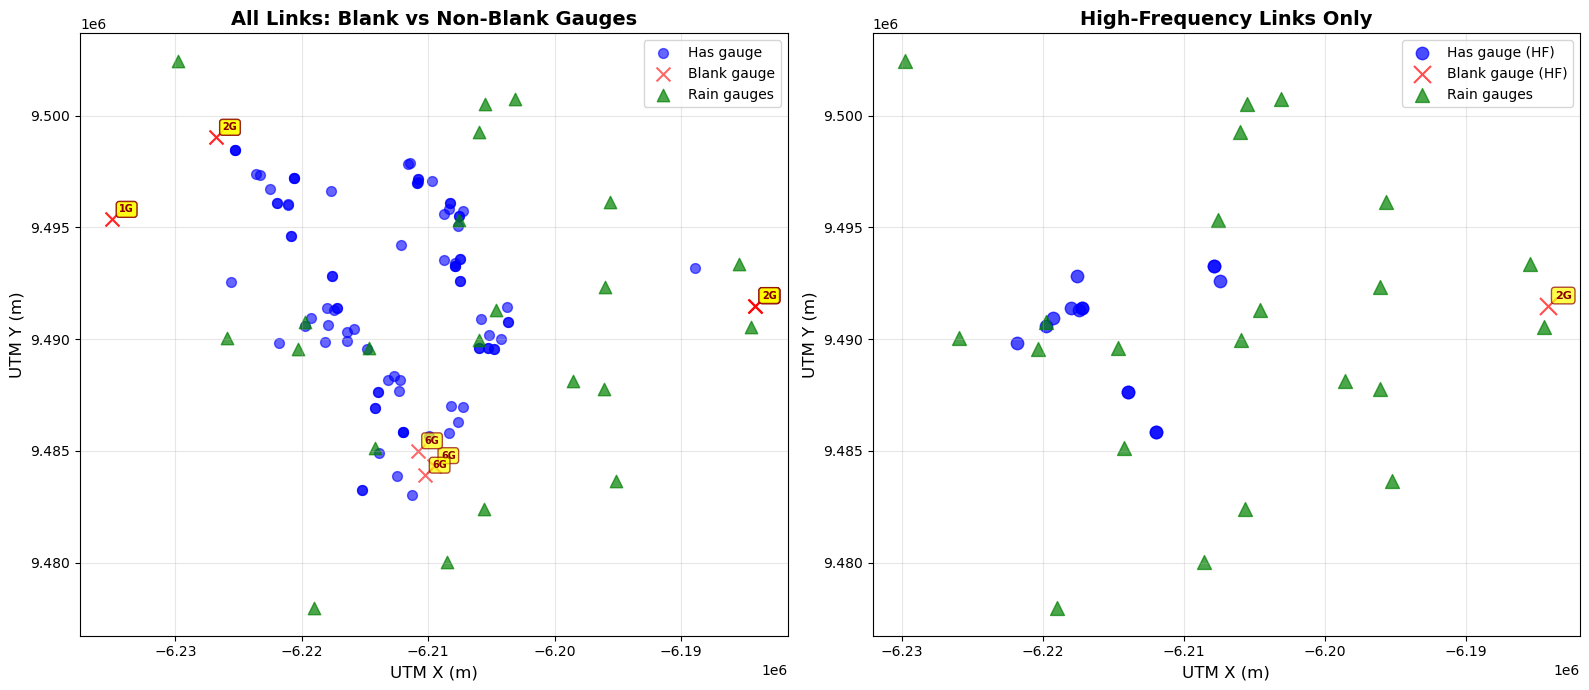


VISUALIZATION SUMMARY

Total links: 103
  - With gauges: 92
  - Blank gauges: 11

High-frequency links: 16
  - With gauges: 15
  - Blank gauges: 1

  Gauge count statistics for sparse links:
    Min gauges used: 2
    Max gauges used: 2
    Mean gauges used: 2.0
    Median gauges used: 2.0
    Distribution: {np.int64(2): np.int64(1)}


In [120]:
# ============================================================================
# VISUALIZATION: Spatial Distribution of Blank Links
# ============================================================================

import matplotlib.pyplot as plt

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All links colored by gauge status (with gauge count for sparse links)
ax1 = axes[0]
for i in range(len(link_set)):
    link = link_set.get_link(i)
    center_x, center_y = get_link_center(link)
    
    # Get number of gauges used (stored in metadata)
    num_gauges = getattr(link.meta_data, 'num_gauges_used', 0)
    
    if i in blank_all:
        color = 'red'
        marker = 'x'
        size = 100
        label = 'Blank gauge' if i == blank_all[0] else ''
        
        # Add annotation showing number of gauges used for sparse links
        if num_gauges > 0:
            ax1.annotate(f'{num_gauges}G', 
                        xy=(center_x, center_y), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=7,
                        color='darkred',
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='darkred'))
    else:
        color = 'blue'
        marker = 'o'
        size = 50
        label = 'Has gauge' if i == 0 else ''
    
    ax1.scatter(center_x, center_y, c=color, marker=marker, s=size, 
                alpha=0.6, label=label if label else '')

# Plot gauge locations
gauge_x = [g.x for g in ps.point_set]
gauge_y = [g.y for g in ps.point_set]
ax1.scatter(gauge_x, gauge_y, c='green', marker='^', s=80, alpha=0.7, label='Rain gauges')

ax1.set_xlabel('UTM X (m)', fontsize=12)
ax1.set_ylabel('UTM Y (m)', fontsize=12)
ax1.set_title('All Links: Blank vs Non-Blank Gauges', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: High-frequency links only (with gauge count annotation for sparse links)
ax2 = axes[1]
for i in highfreqID:
    link = link_set.get_link(i)
    center_x, center_y = get_link_center(link)
    
    # Get number of gauges used (stored in metadata)
    num_gauges = getattr(link.meta_data, 'num_gauges_used', 0)
    
    if i in blank_highfreq:
        color = 'red'
        marker = 'x'
        size = 150
        label = 'Blank gauge (HF)' if i == blank_highfreq[0] else ''
        
        # Add annotation showing number of gauges used for sparse links
        if num_gauges > 0:
            ax2.annotate(f'{num_gauges}G', 
                        xy=(center_x, center_y), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8,
                        color='darkred',
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='darkred'))
    else:
        color = 'blue'
        marker = 'o'
        size = 80
        label = 'Has gauge (HF)' if i == highfreqID[0] else ''
    
    ax2.scatter(center_x, center_y, c=color, marker=marker, s=size, 
                alpha=0.7, label=label if label else '')

# Plot gauge locations
ax2.scatter(gauge_x, gauge_y, c='green', marker='^', s=100, alpha=0.7, label='Rain gauges')

ax2.set_xlabel('UTM X (m)', fontsize=12)
ax2.set_ylabel('UTM Y (m)', fontsize=12)
ax2.set_title('High-Frequency Links Only', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("VISUALIZATION SUMMARY")
print("=" * 70)
print(f"\nTotal links: {len(link_set)}")
print(f"  - With gauges: {len(link_set) - len(blank_all)}")
print(f"  - Blank gauges: {len(blank_all)}")
print(f"\nHigh-frequency links: {len(highfreqID)}")
print(f"  - With gauges: {len(highfreqID) - len(blank_highfreq)}")
print(f"  - Blank gauges: {len(blank_highfreq)}")

# Show gauge count statistics for sparse links
if blank_highfreq:
    gauge_counts = []
    for i in blank_highfreq:
        link = link_set.get_link(i)
        num_gauges = getattr(link.meta_data, 'num_gauges_used', 0)
        if num_gauges > 0:
            gauge_counts.append(num_gauges)
    
    if gauge_counts:
        print(f"\n  Gauge count statistics for sparse links:")
        print(f"    Min gauges used: {min(gauge_counts)}")
        print(f"    Max gauges used: {max(gauge_counts)}")
        print(f"    Mean gauges used: {np.mean(gauge_counts):.1f}")
        print(f"    Median gauges used: {np.median(gauge_counts):.1f}")
        print(f"    Distribution: {dict(zip(*np.unique(gauge_counts, return_counts=True)))}")

print("=" * 70)


PLOTTING INDIVIDUAL GAUGES FOR SPARSE HIGH-FREQUENCY LINKS

Link 21 (cml_id=22, sublink_id=sublink_1)
Frequency: 69.12 GHz
Number of gauges used: 2


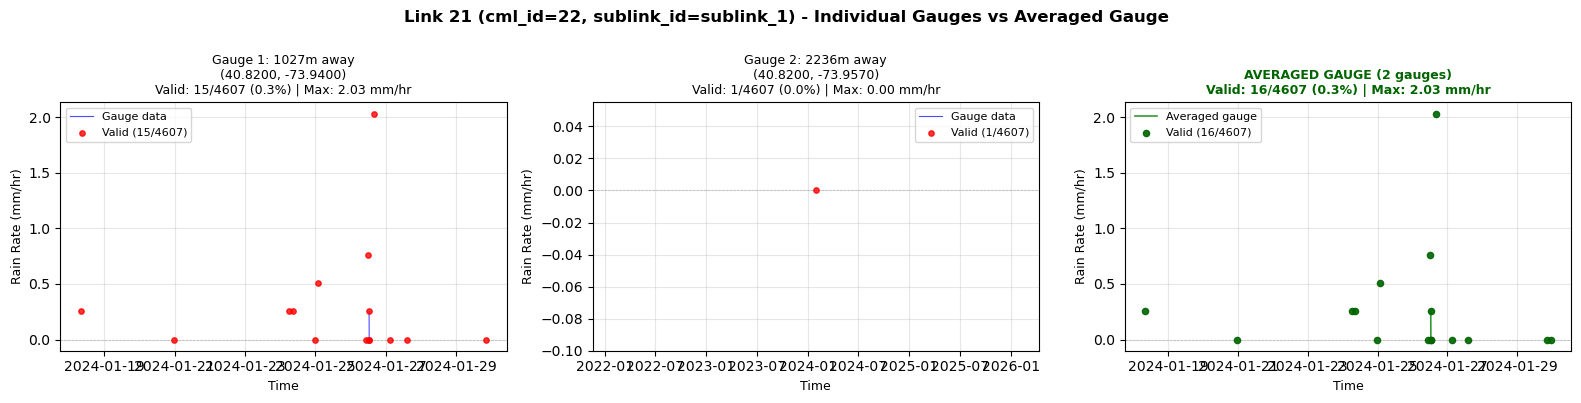


  Summary:
    Individual gauges: 2
      Gauge 1: 1027m away, 15/4607 valid samples
      Gauge 2: 2236m away, 1/4607 valid samples
    Averaged gauge: 16/4607 valid samples



In [121]:
# ============================================================================
# PLOT INDIVIDUAL GAUGES FOR SPARSE HIGH-FREQUENCY LINKS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 70)
print("PLOTTING INDIVIDUAL GAUGES FOR SPARSE HIGH-FREQUENCY LINKS")
print("=" * 70)

# Use the same max_distance that was used when creating the links
max_distance = 8000  # Same as used in patched_xarray2link_with_gauges

for link_idx in blank_highfreq:
    link = link_set.get_link(link_idx)
    num_gauges_used = getattr(link.meta_data, 'num_gauges_used', 0)
    
    if num_gauges_used == 0:
        print(f"\nLink {link_idx}: No gauges were used (skipping)")
        continue
    
    print(f"\n{'='*70}")
    print(f"Link {link_idx} (cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id})")
    print(f"Frequency: {link.meta_data.frequency:.2f} GHz")
    print(f"Number of gauges used: {num_gauges_used}")
    print(f"{'='*70}")
    
    # Find the gauges that were used for this link
    link_center = link.meta_data.xy_center()
    distances, gauges = ps.find_near_gauges(link_center, max_distance)
    
    if len(gauges) == 0:
        print(f"  ⚠️  No gauges found within {max_distance/1000:.1f} km (this shouldn't happen!)")
        continue
    
    # Get the averaged gauge_ref for comparison
    averaged_gauge = link.gauge_ref[0] if link.gauge_ref and len(link.gauge_ref) > 0 else None
    
    # Create figure with subplots: one for each gauge + one for the average
    n_gauges = len(gauges)
    n_cols = min(3, n_gauges + 1)  # Max 3 columns
    n_rows = (n_gauges + 1 + n_cols - 1) // n_cols  # +1 for averaged plot
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_gauges > 1 else [axes]
    axes = axes.flatten()
    
    # Plot each individual gauge
    for i, (gauge, distance) in enumerate(zip(gauges, distances)):
        ax = axes[i]
        data = gauge.data_array
        time = gauge.time_array.astype("datetime64[s]")
        
        # Calculate statistics
        valid_mask = ~np.isnan(data)
        valid_count = np.sum(valid_mask)
        total_count = len(data)
        valid_ratio = valid_count / total_count if total_count > 0 else 0
        
        # Plot the data
        ax.plot(time, data, 'b-', linewidth=0.8, alpha=0.7, label='Gauge data')
        ax.scatter(time[valid_mask], data[valid_mask], c='red', s=15, alpha=0.8, 
                  label=f'Valid ({valid_count}/{total_count})', zorder=5)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        
        ax.set_xlabel('Time', fontsize=9)
        ax.set_ylabel('Rain Rate (mm/hr)', fontsize=9)
        ax.set_title(f'Gauge {i+1}: {distance:.0f}m away\n'
                    f'({gauge.lat:.4f}, {gauge.lon:.4f})\n'
                    f'Valid: {valid_count}/{total_count} ({valid_ratio*100:.1f}%) | '
                    f'Max: {np.nanmax(data):.2f} mm/hr', 
                    fontsize=9)
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=-0.1)
    
    # Plot the averaged gauge (last subplot)
    if averaged_gauge:
        ax_avg = axes[n_gauges]
        avg_data = averaged_gauge.data_array
        avg_time = averaged_gauge.time_array.astype("datetime64[s]")
        
        # Calculate statistics for averaged gauge
        avg_valid_mask = ~np.isnan(avg_data)
        avg_valid_count = np.sum(avg_valid_mask)
        avg_total_count = len(avg_data)
        avg_valid_ratio = avg_valid_count / avg_total_count if avg_total_count > 0 else 0
        
        # Plot averaged data
        ax_avg.plot(avg_time, avg_data, 'g-', linewidth=1.2, alpha=0.8, label='Averaged gauge')
        ax_avg.scatter(avg_time[avg_valid_mask], avg_data[avg_valid_mask], c='darkgreen', s=20, 
                      alpha=0.9, label=f'Valid ({avg_valid_count}/{avg_total_count})', zorder=5)
        ax_avg.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        
        ax_avg.set_xlabel('Time', fontsize=9)
        ax_avg.set_ylabel('Rain Rate (mm/hr)', fontsize=9)
        ax_avg.set_title(f'AVERAGED GAUGE ({num_gauges_used} gauges)\n'
                         f'Valid: {avg_valid_count}/{avg_total_count} ({avg_valid_ratio*100:.1f}%) | '
                         f'Max: {np.nanmax(avg_data):.2f} mm/hr',
                         fontsize=9, fontweight='bold', color='darkgreen')
        ax_avg.legend(loc='best', fontsize=8)
        ax_avg.grid(True, alpha=0.3)
        ax_avg.set_ylim(bottom=-0.1)
    
    # Hide unused subplots
    for i in range(n_gauges + 1, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Link {link_idx} (cml_id={link.meta_data.cml_id}, sublink_id={link.meta_data.sublink_id}) - '
                 f'Individual Gauges vs Averaged Gauge',
                 fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n  Summary:")
    print(f"    Individual gauges: {n_gauges}")
    for i, (gauge, distance) in enumerate(zip(gauges, distances)):
        valid_count = np.sum(~np.isnan(gauge.data_array))
        total_count = len(gauge.data_array)
        print(f"      Gauge {i+1}: {distance:.0f}m away, {valid_count}/{total_count} valid samples")
    if averaged_gauge:
        avg_valid = np.sum(~np.isnan(averaged_gauge.data_array))
        avg_total = len(averaged_gauge.data_array)
        print(f"    Averaged gauge: {avg_valid}/{avg_total} valid samples")

print("\n" + "=" * 70)


In [124]:
link_set.get_link(highfreqID[0]).gauge_ref[0].data_array


array([0., 0., 0., ..., 0., 0., 0.], shape=(4607,))

Rain detection:

Overlap period: 2024-01-15T00:00:00 to 2024-01-30T23:59:00
Link WD data points: 23040
Gauge data points: 13134
Interpolated detection length: 13134


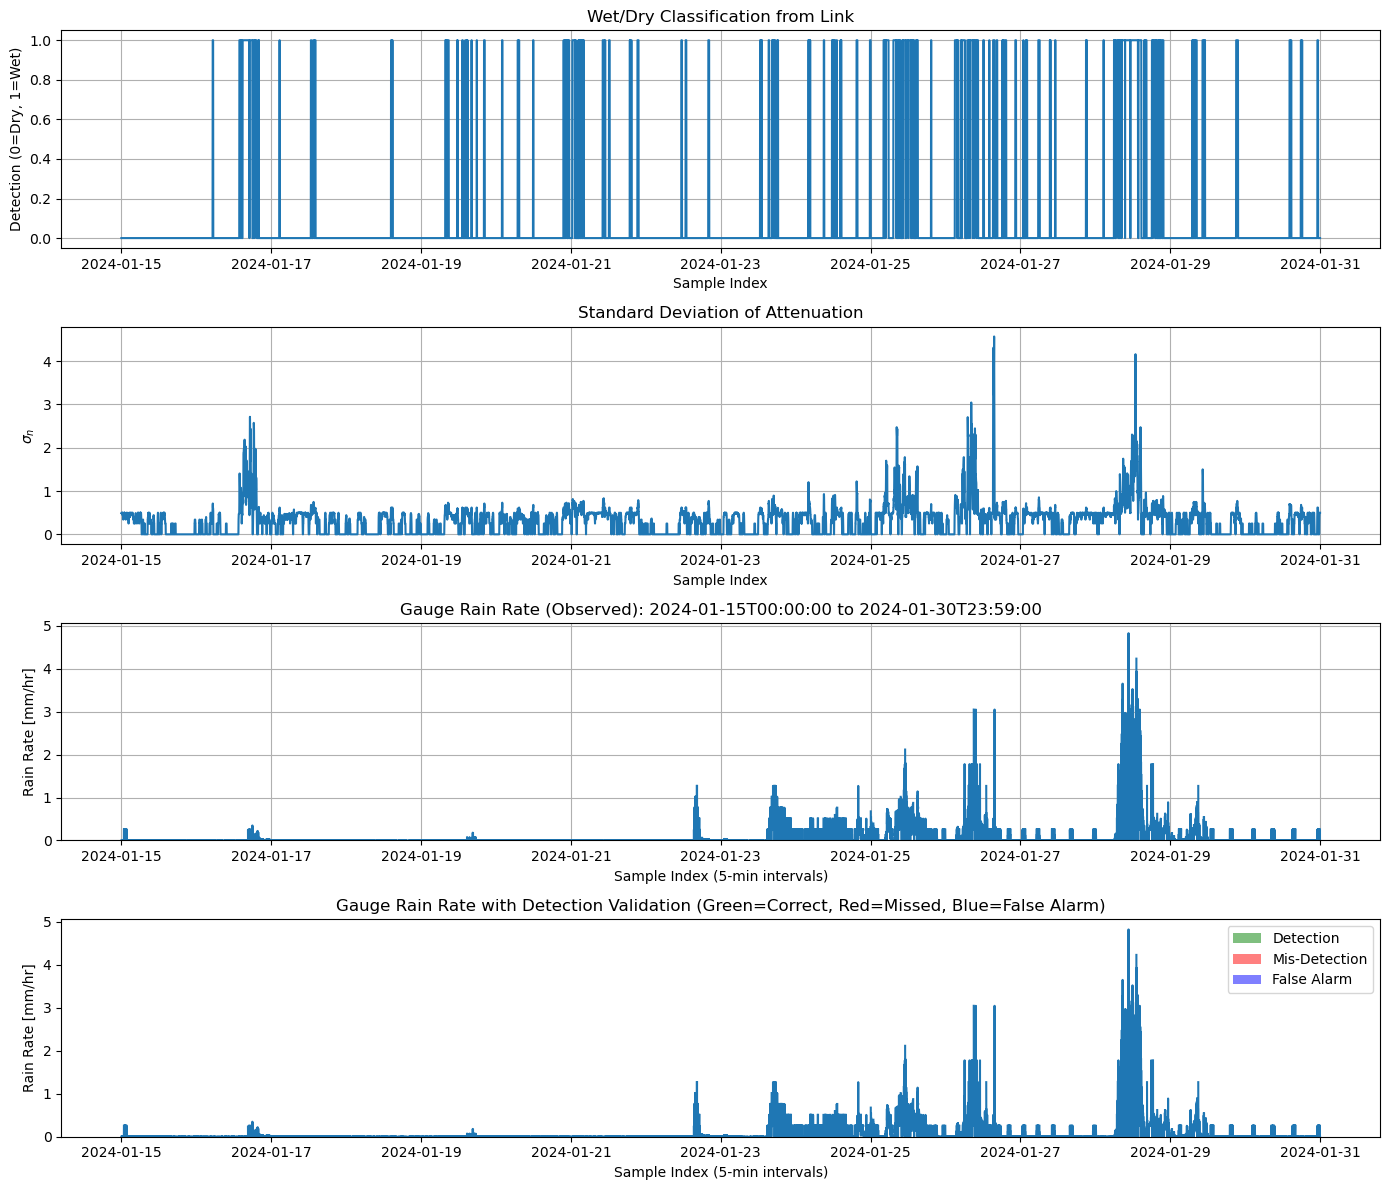


📊 Detection Performance:
  True Positives (correctly detected rain): 541
  True Negatives (correctly detected dry): 7547
  False Positives (false alarms): 676
  False Negatives (missed rain): 1343
  Positive detection: 0.28715498938428874
  Negative detection: 0.9177915602578135
  Accuracy: 61.58%


In [138]:
classification_plot(link_set.get_link(2),15,0.58)

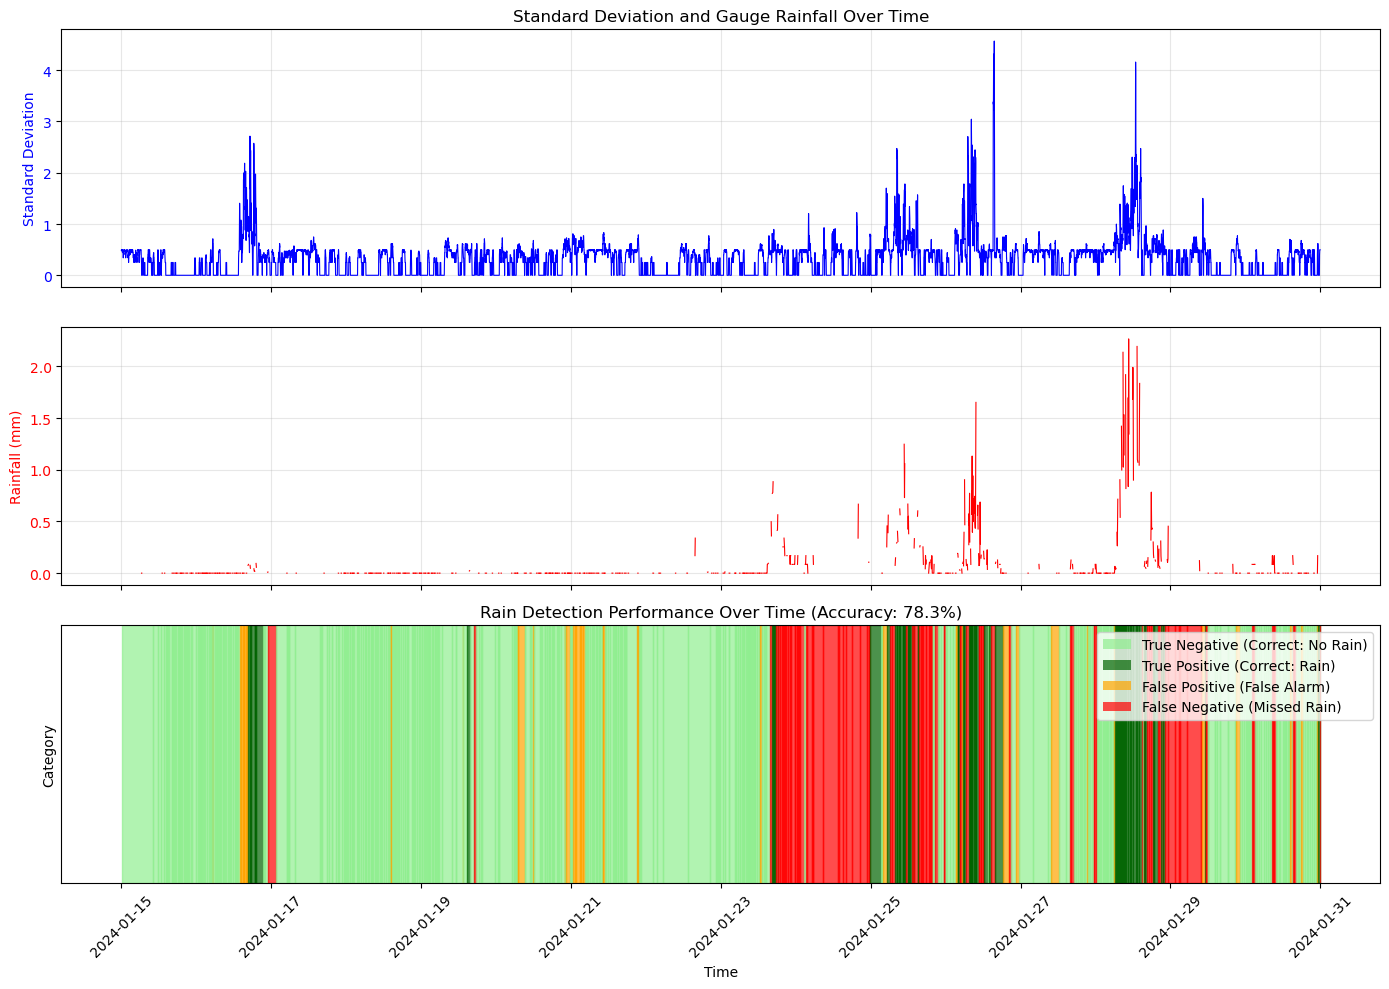

{'accuracy': 0.7828125,
 'positive_acc': 0.4418604651162791,
 'negative_acc': 0.9081196581196581,
 'categories': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0,


In [139]:
rain_detection(link_set.get_link(2), 0.58, 15, True, False)

### Detection for every high-frequency sublink between 07/01 and 16/01
### std threshold = 0.59

link frequency: 68.04


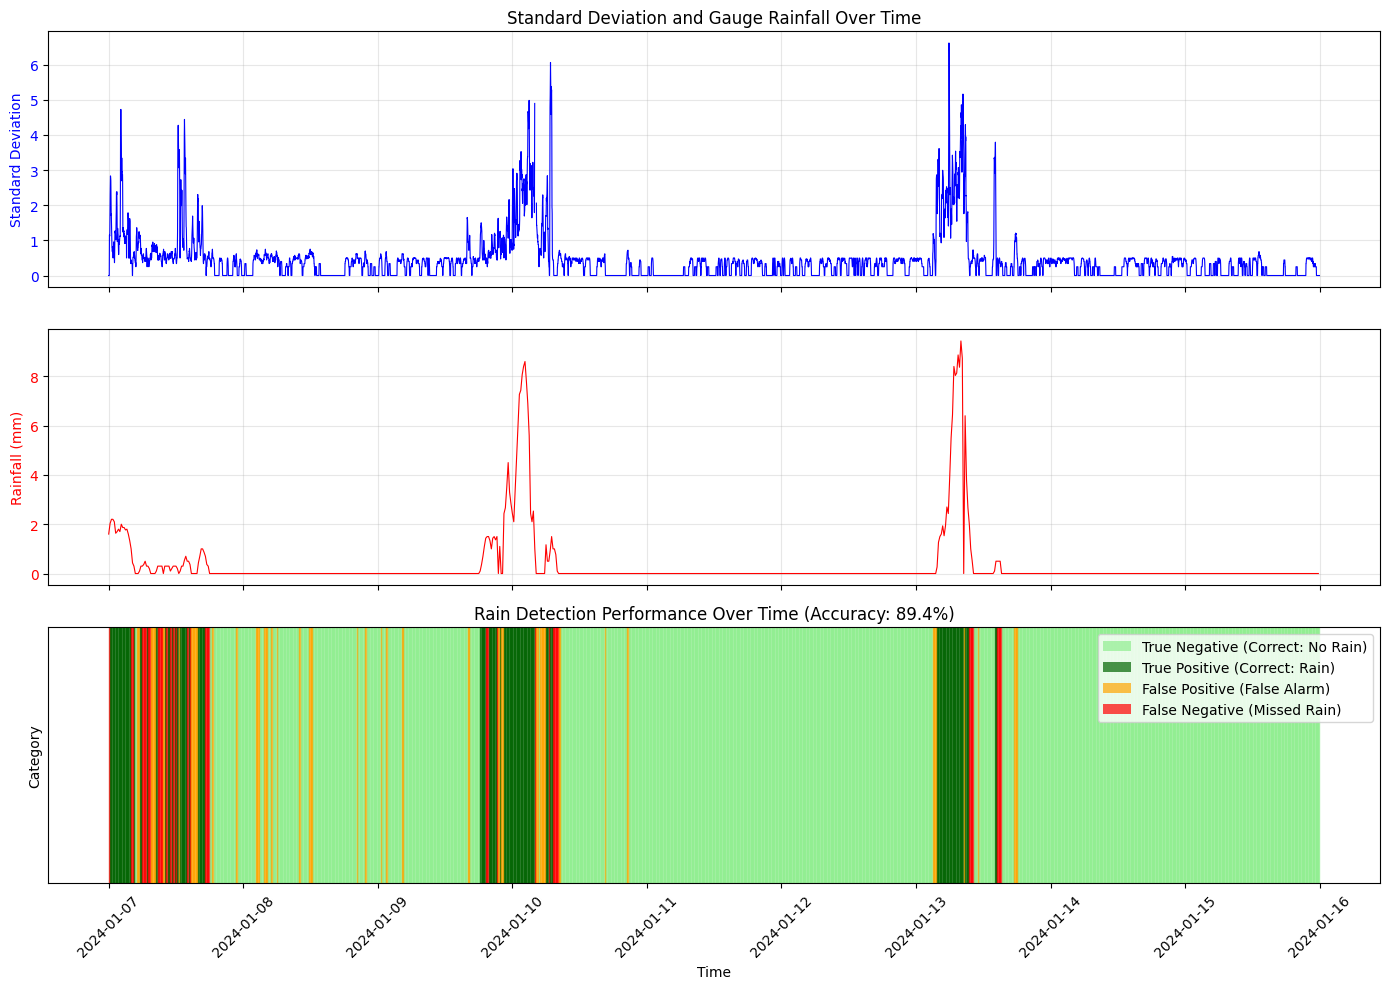

link frequency: 68.04


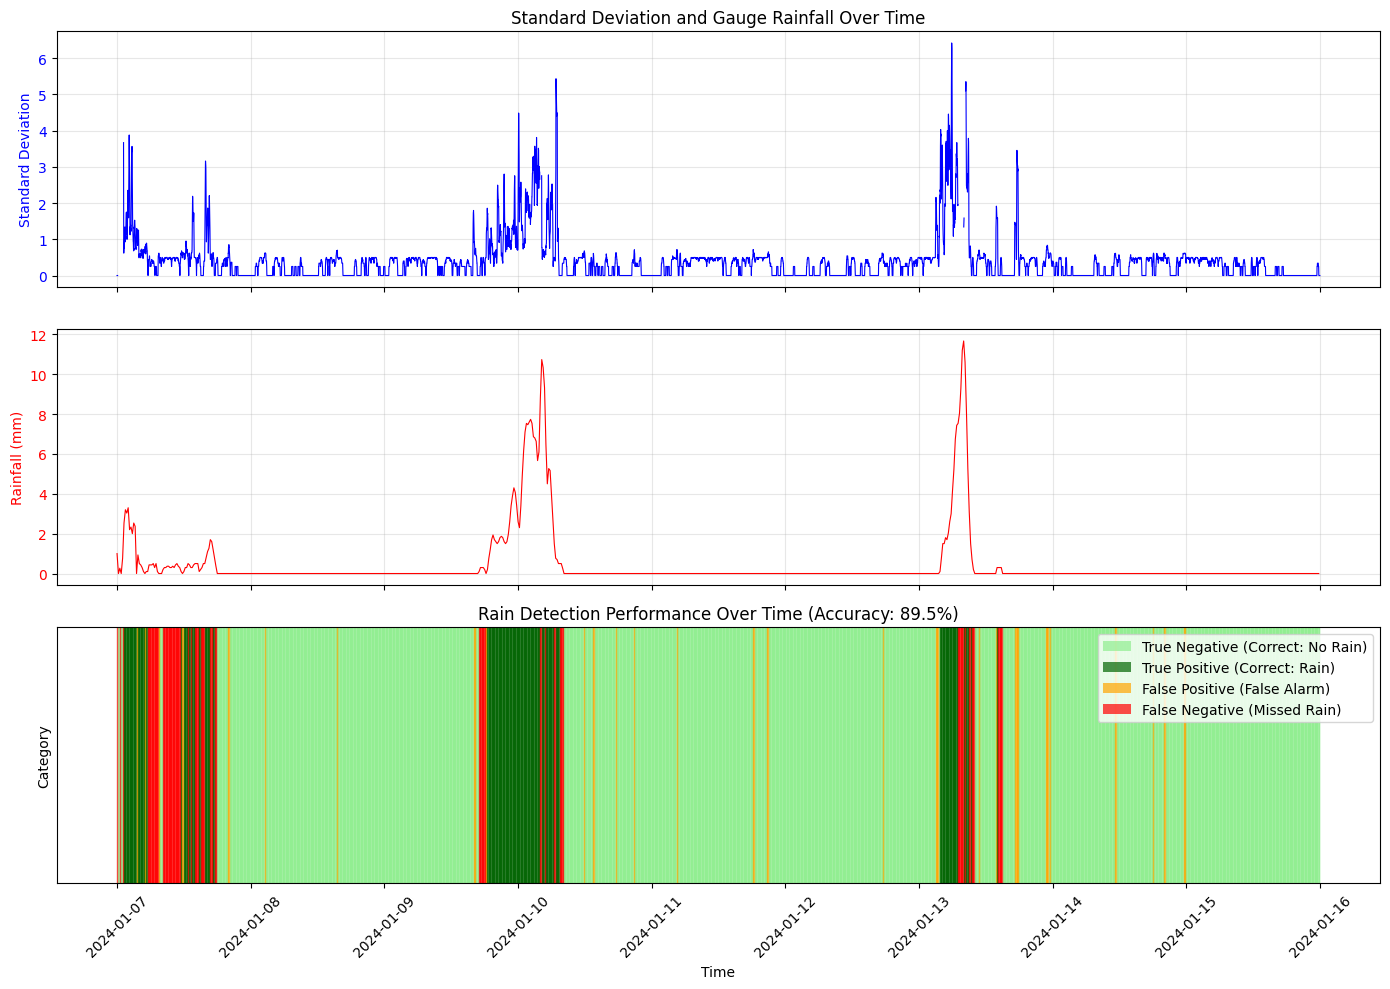

link frequency: 68.04


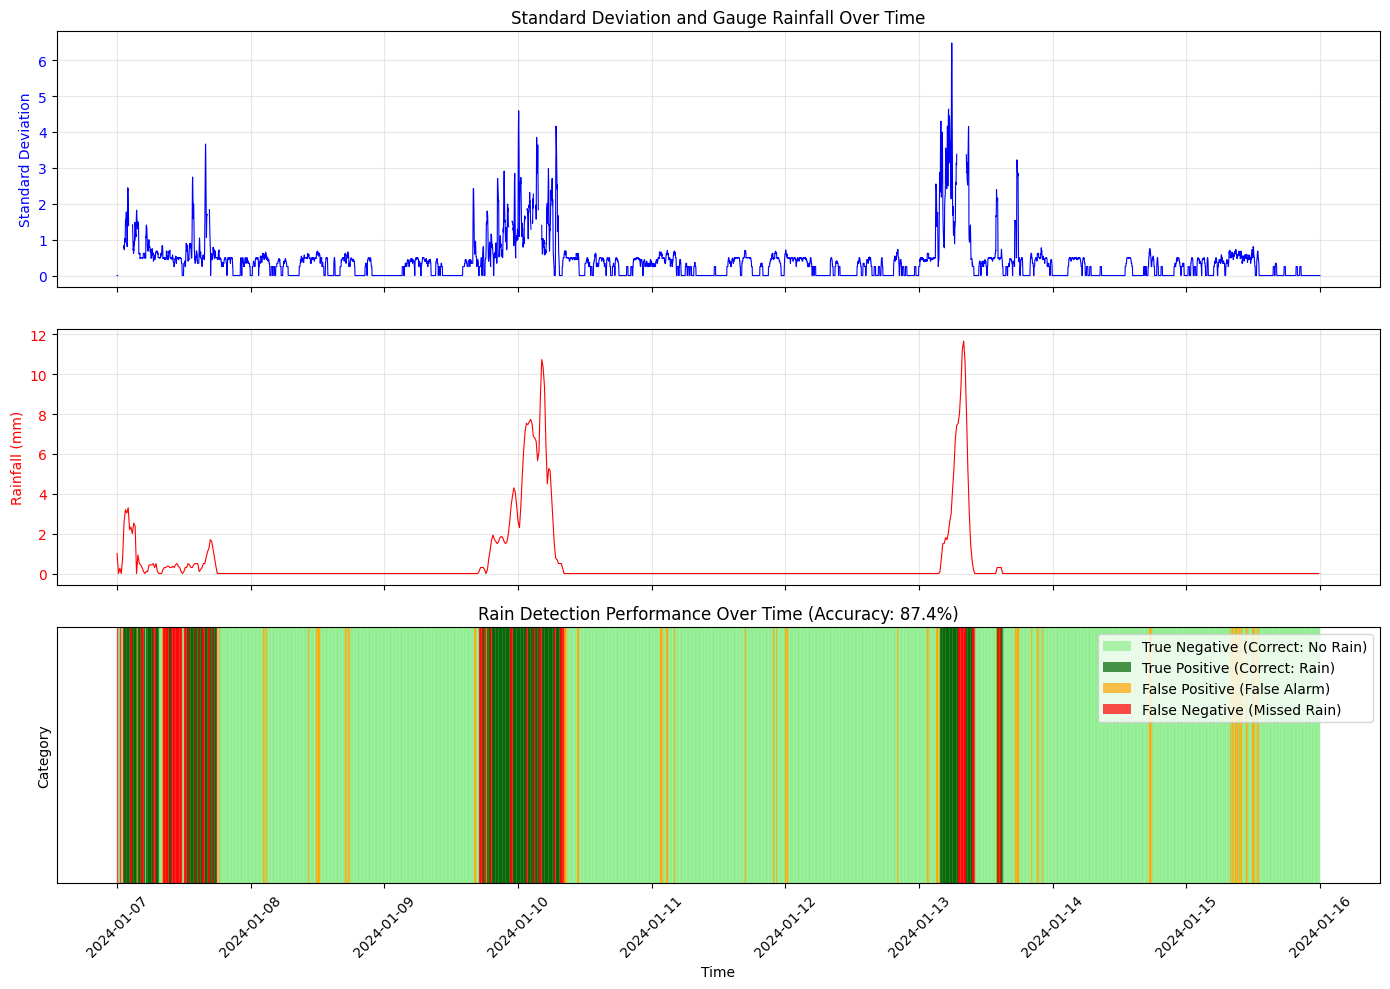

link frequency: 68.04


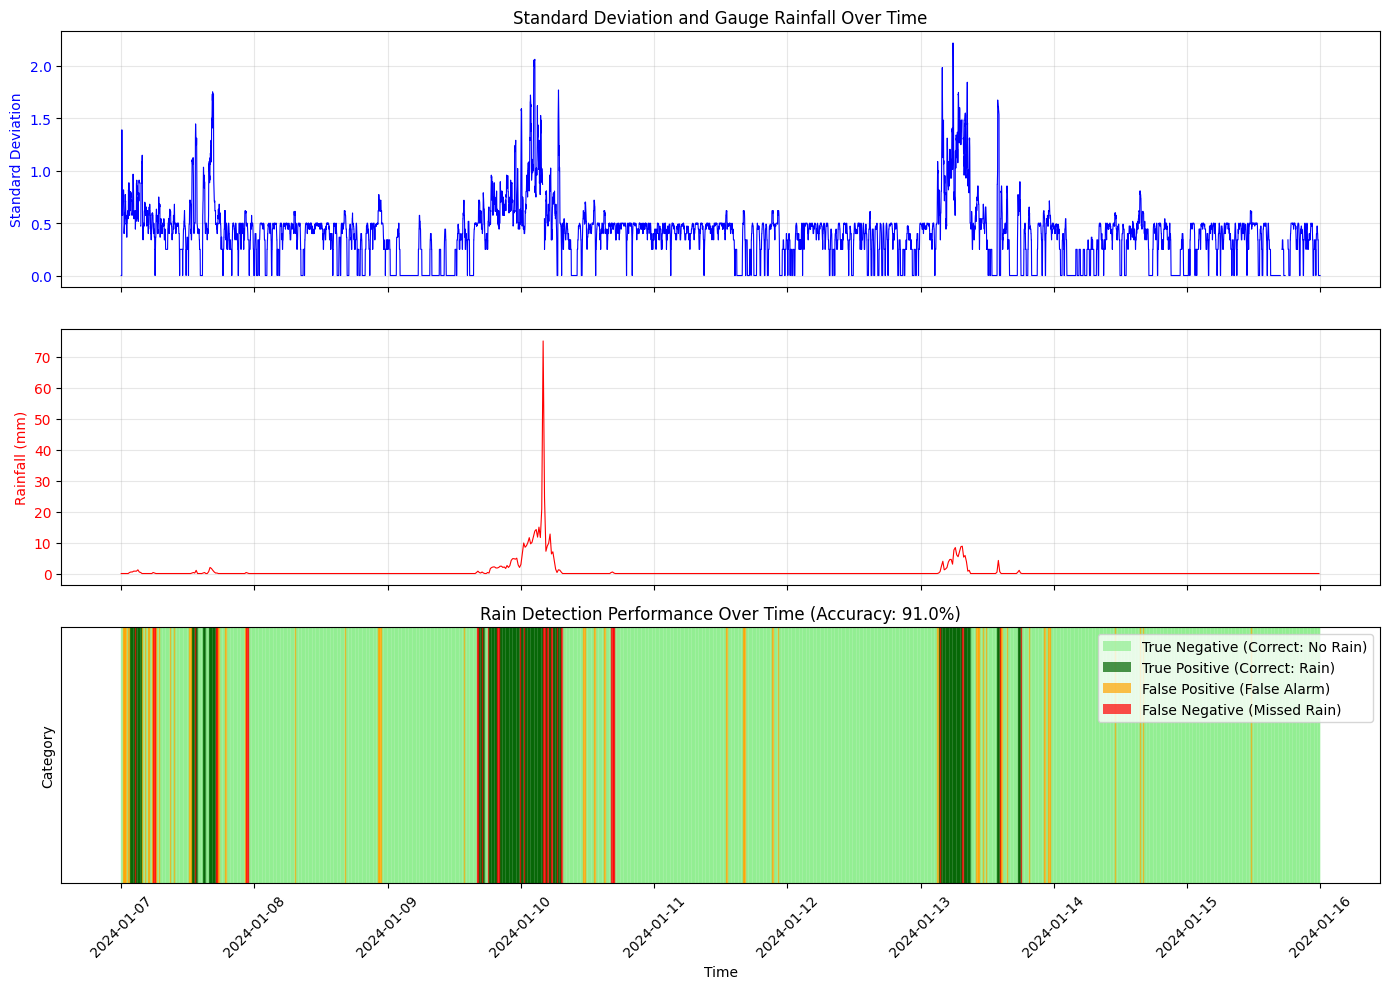

link frequency: 69.12


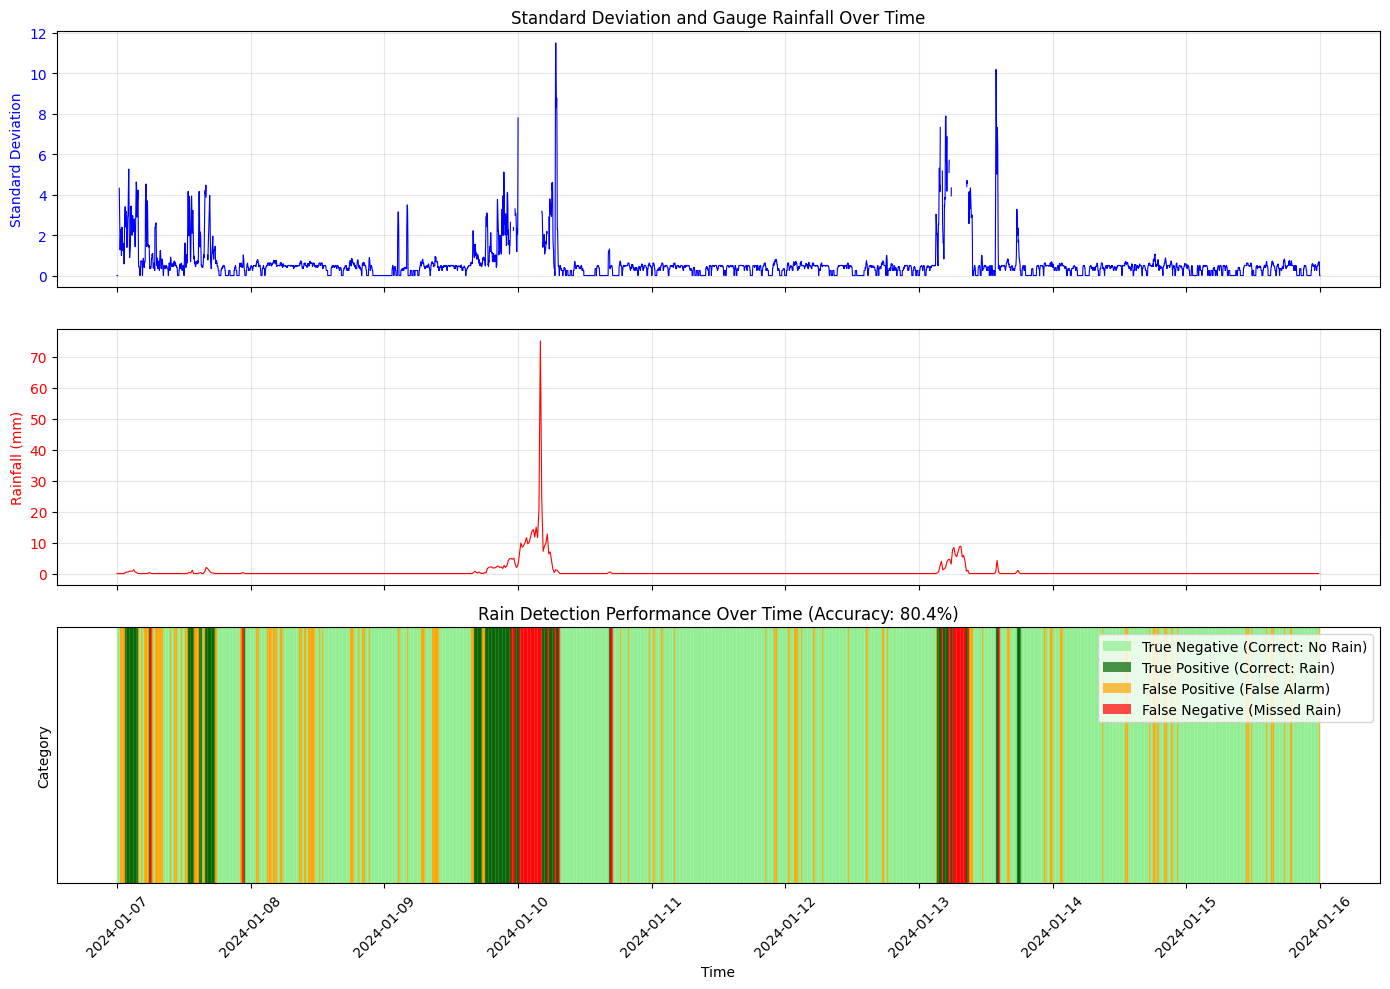

link frequency: 69.12


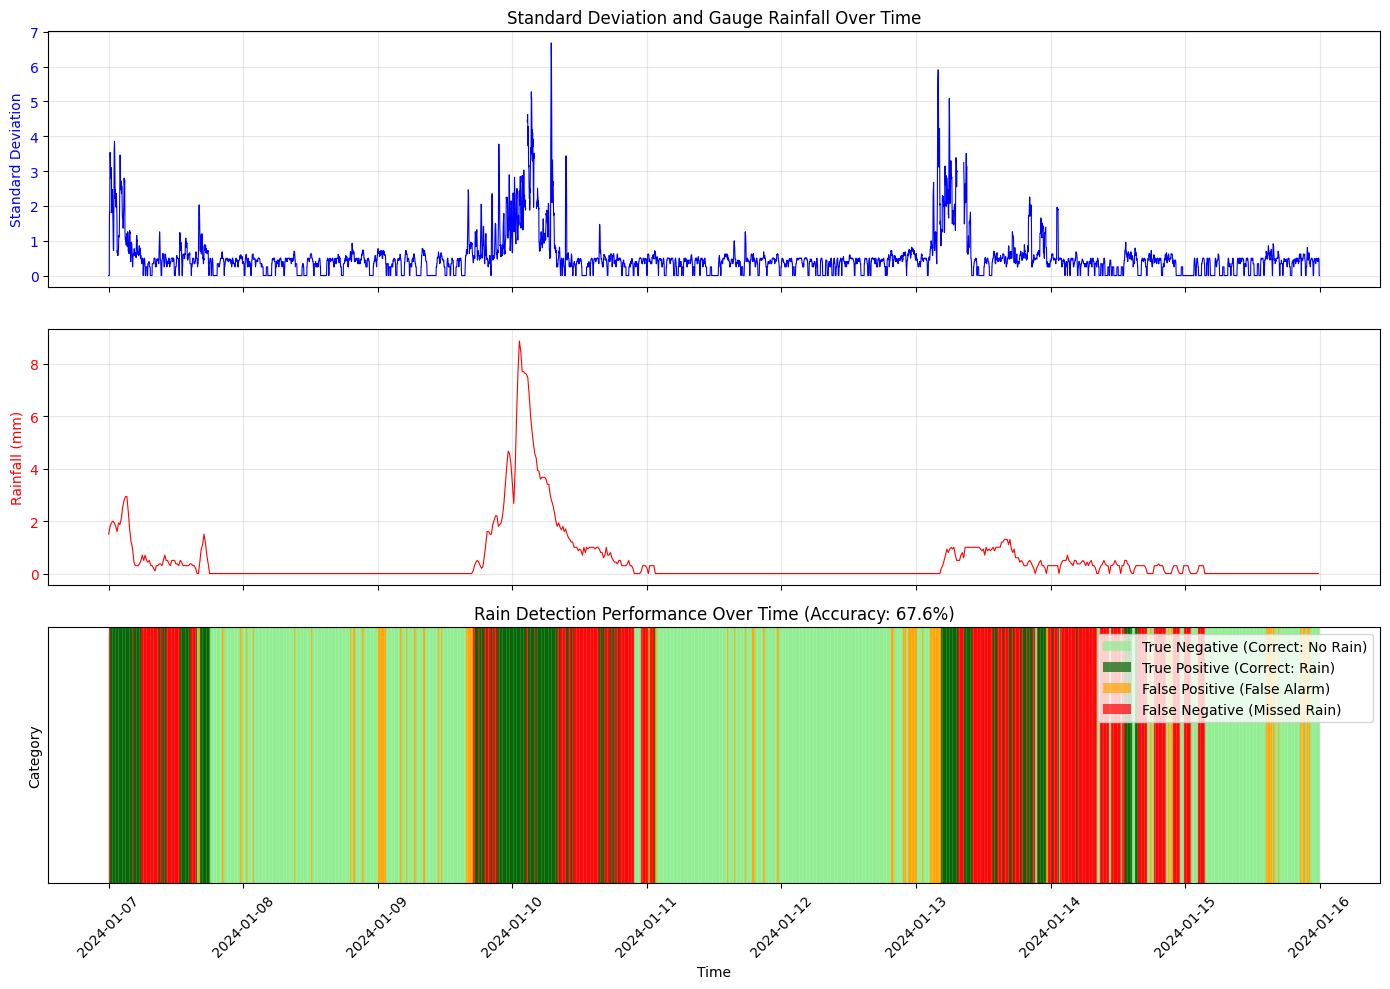

link frequency: 68.04


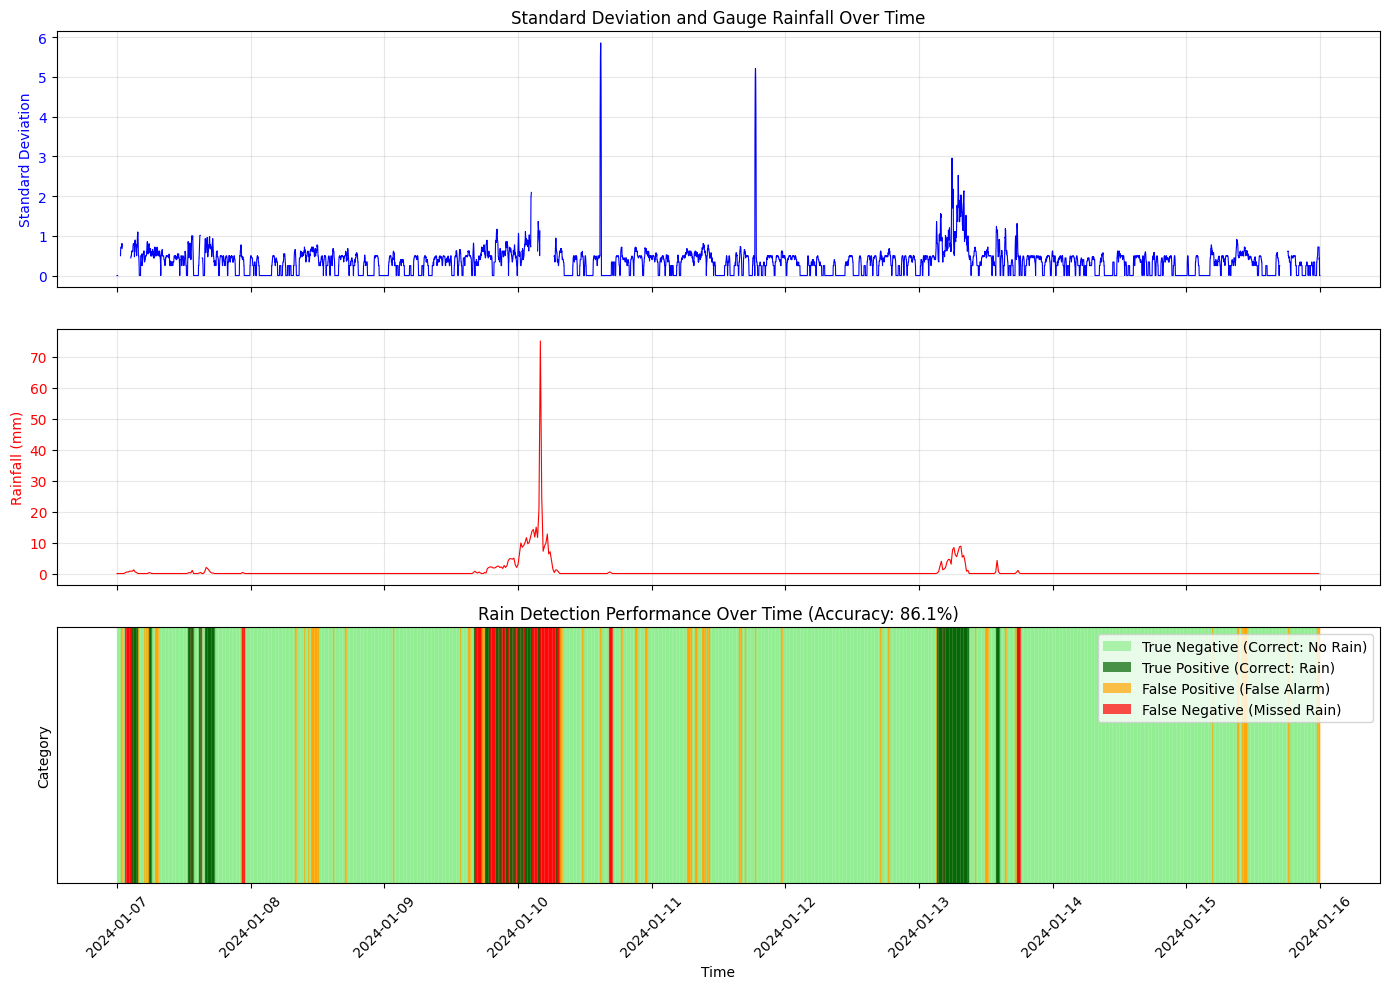

link frequency: 68.04


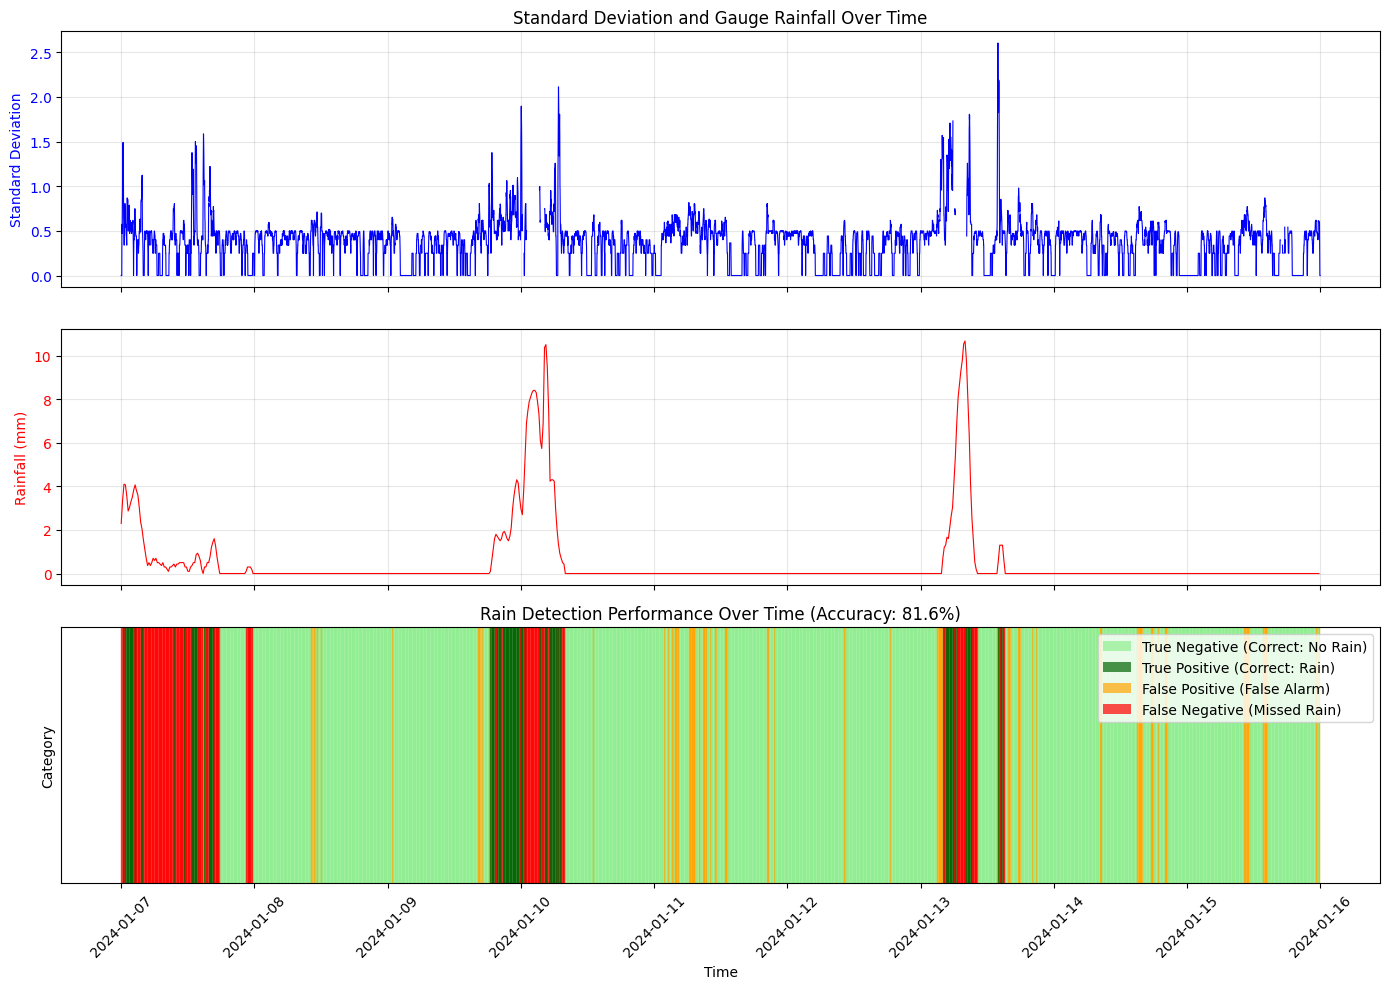

link frequency: 68.04


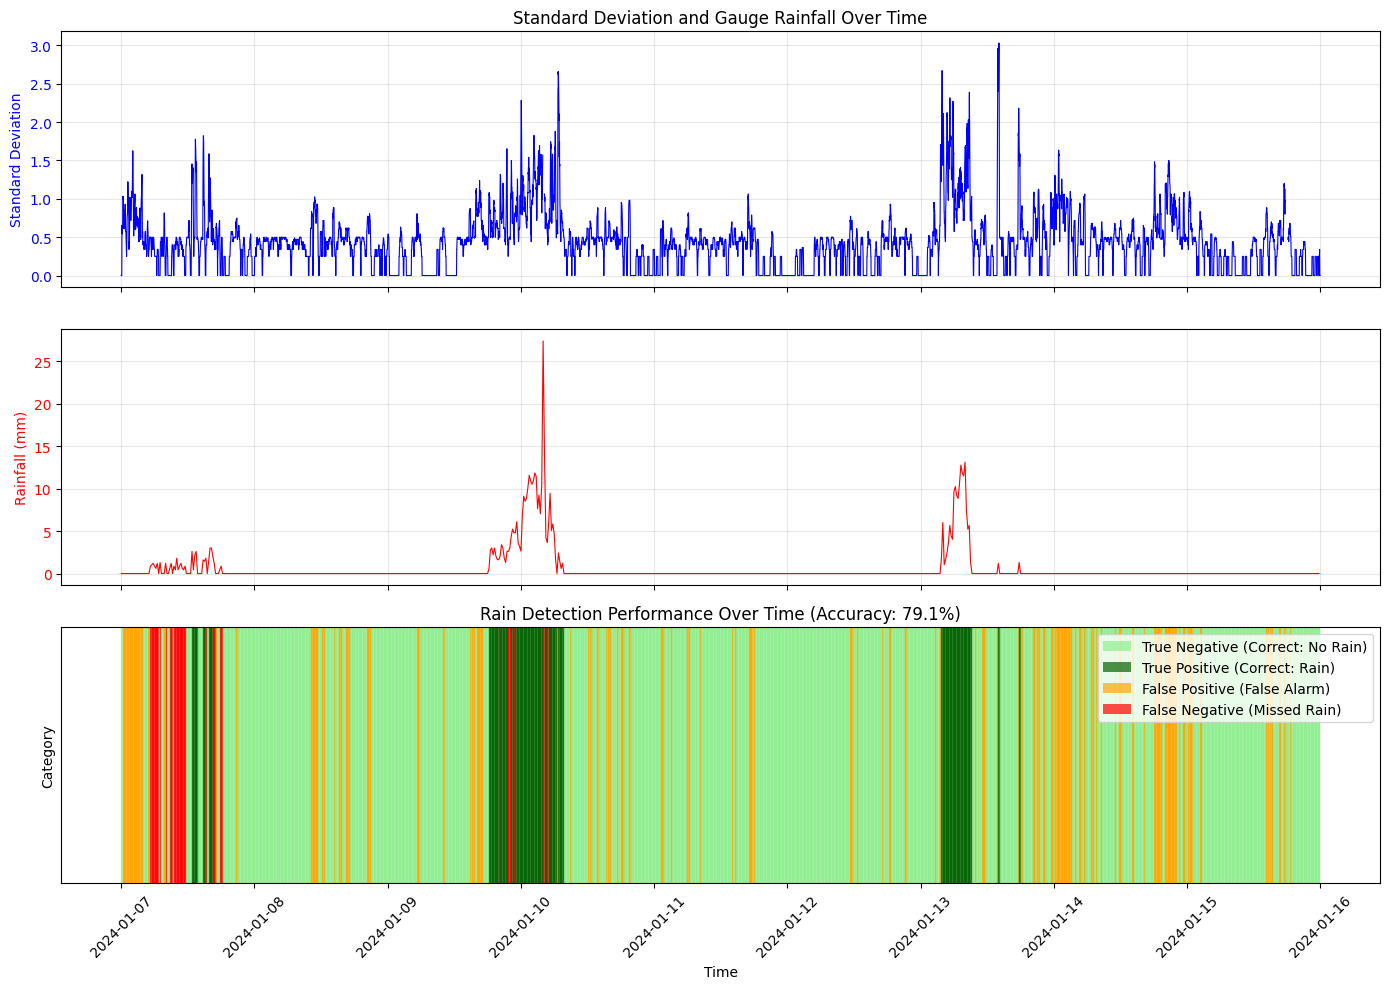

link frequency: 68.04


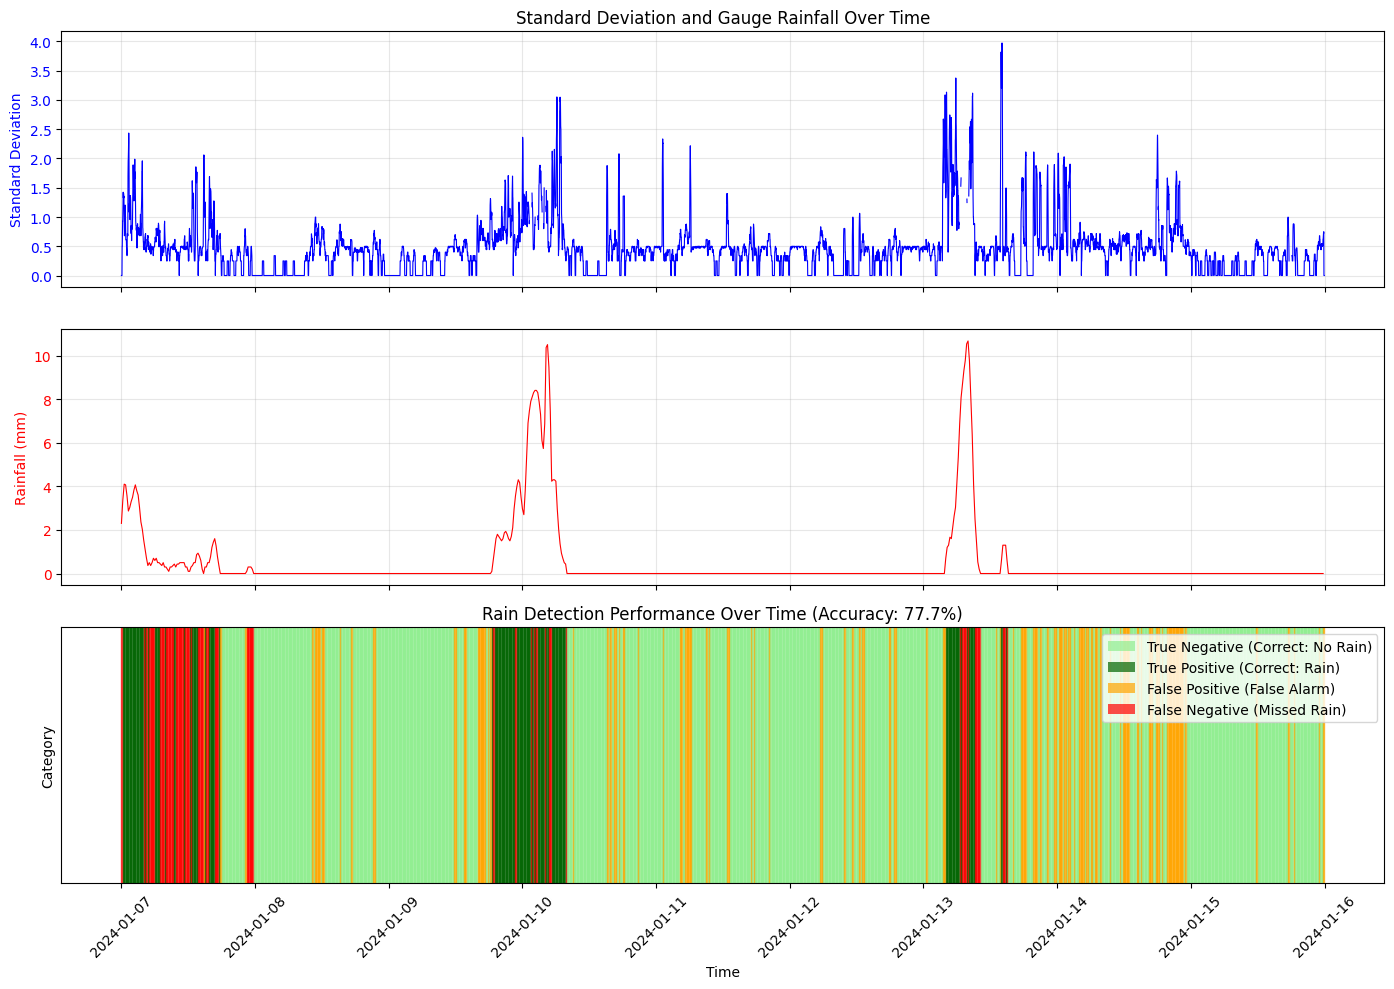

link frequency: 68.04


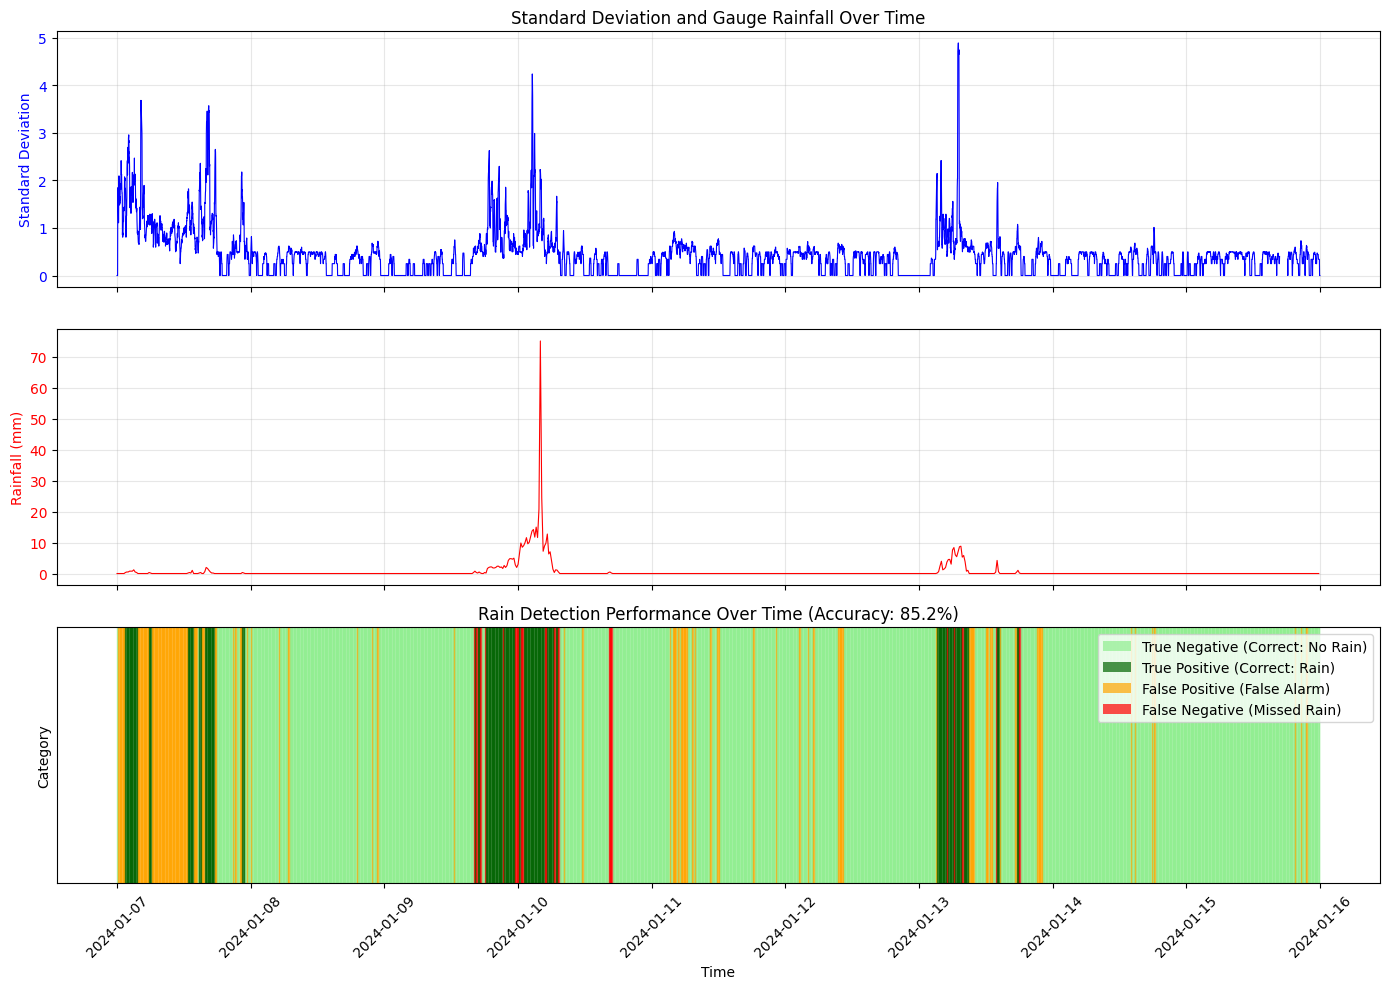

link frequency: 68.04


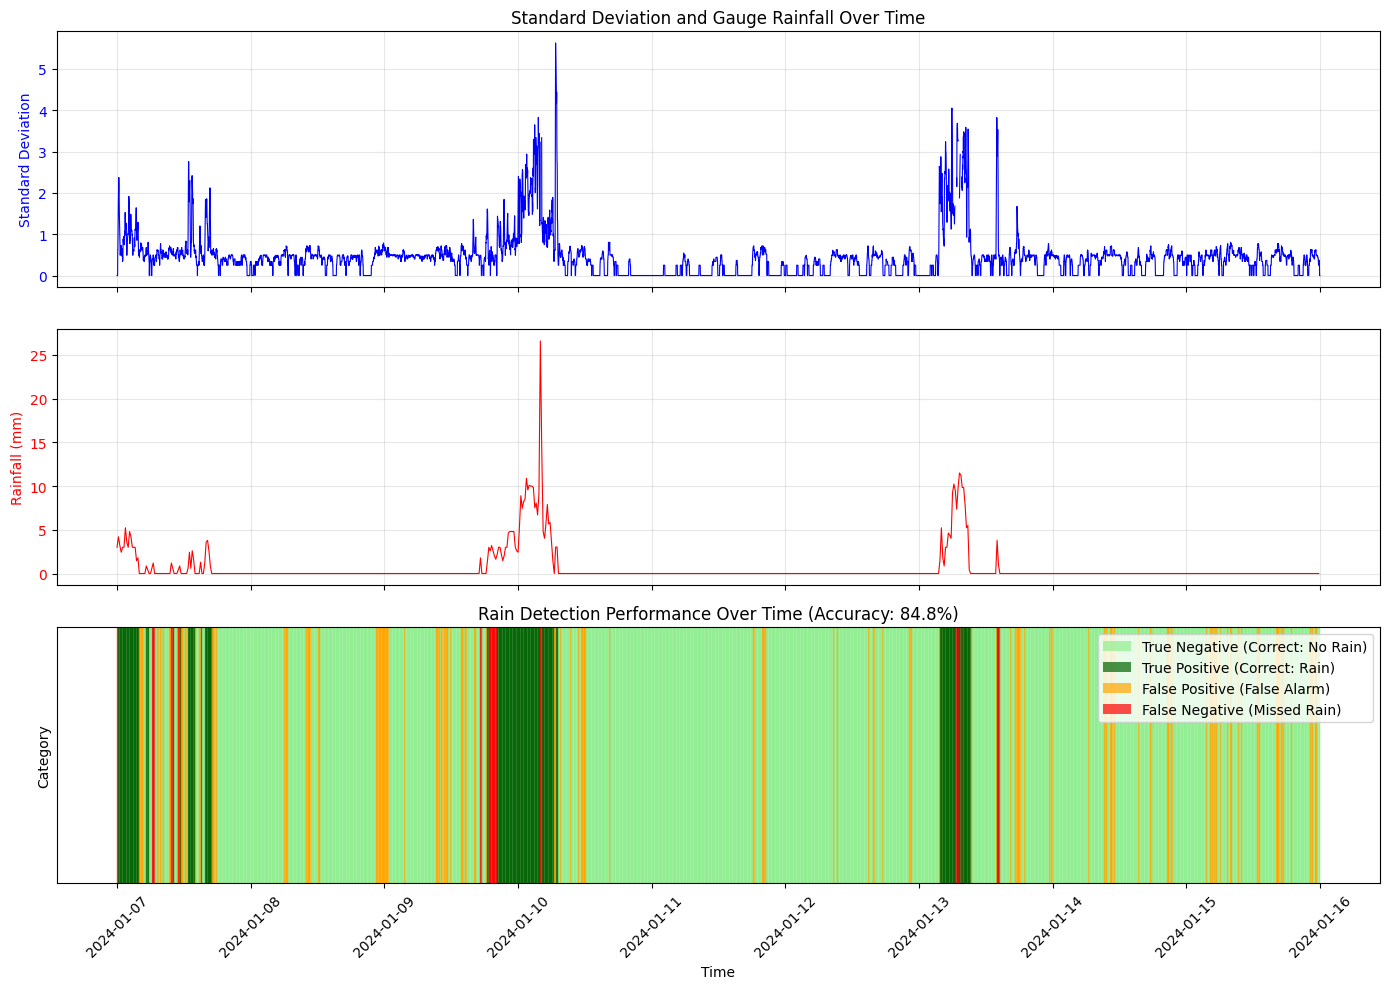

link frequency: 68.04


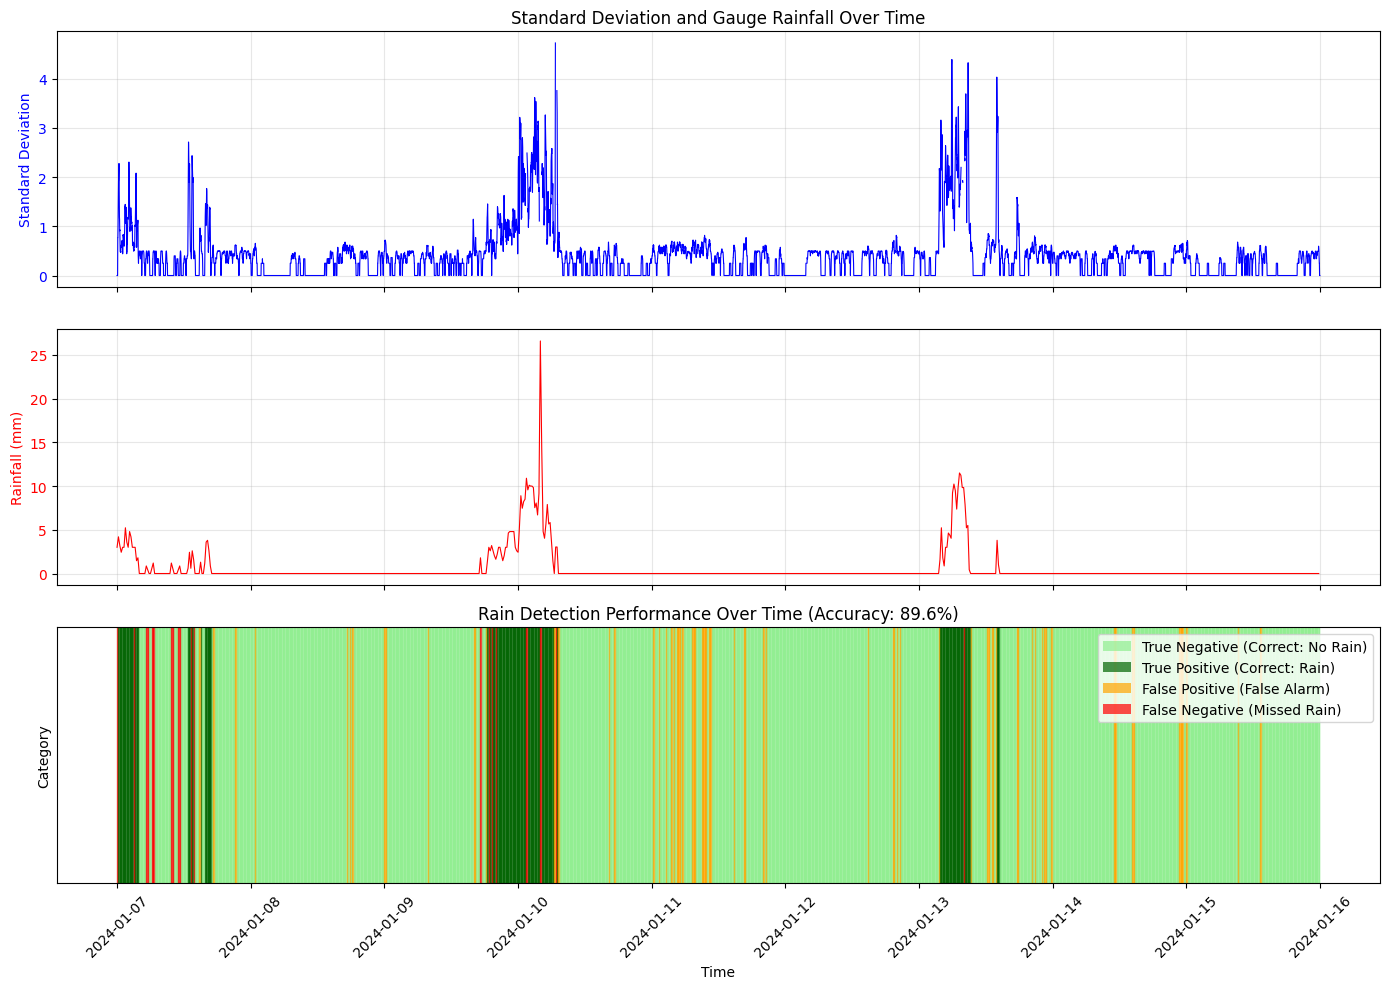

link frequency: 68.04


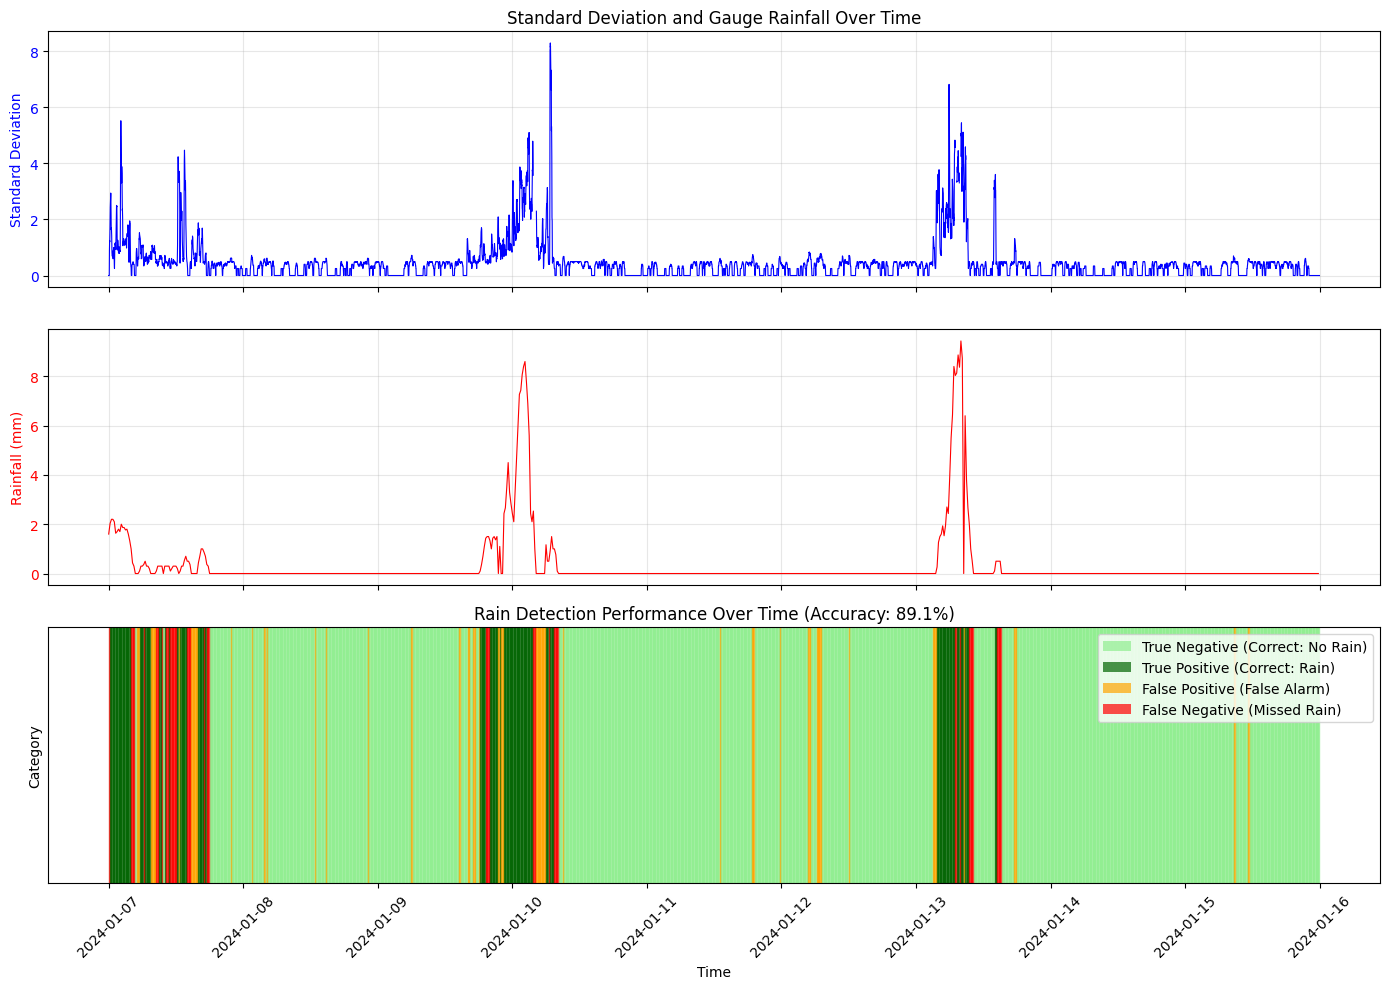

link frequency: 68.04


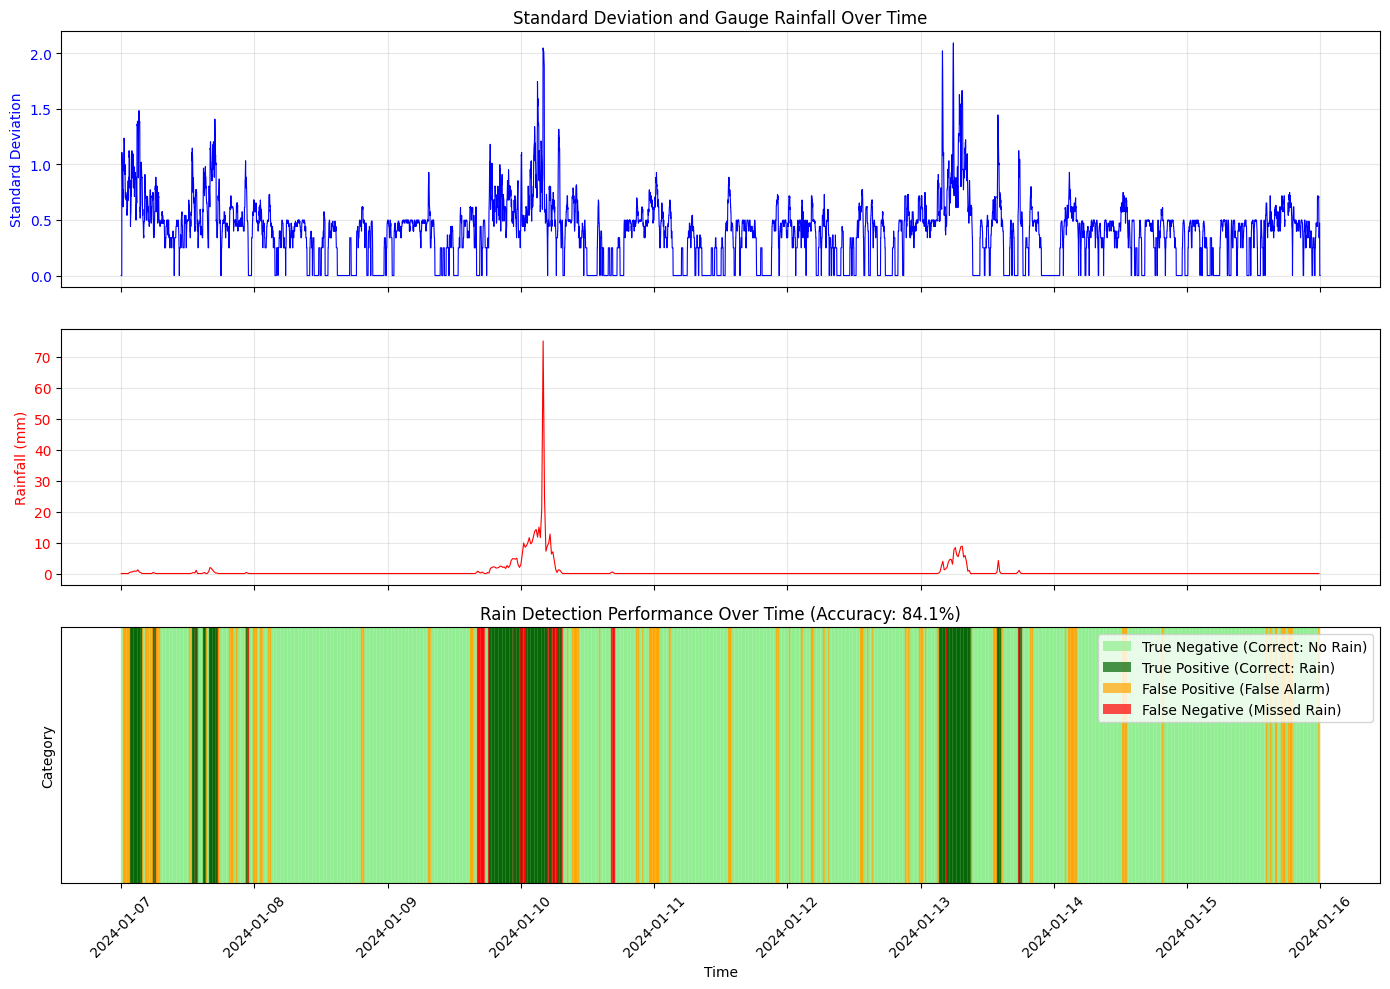

link frequency: 68.04


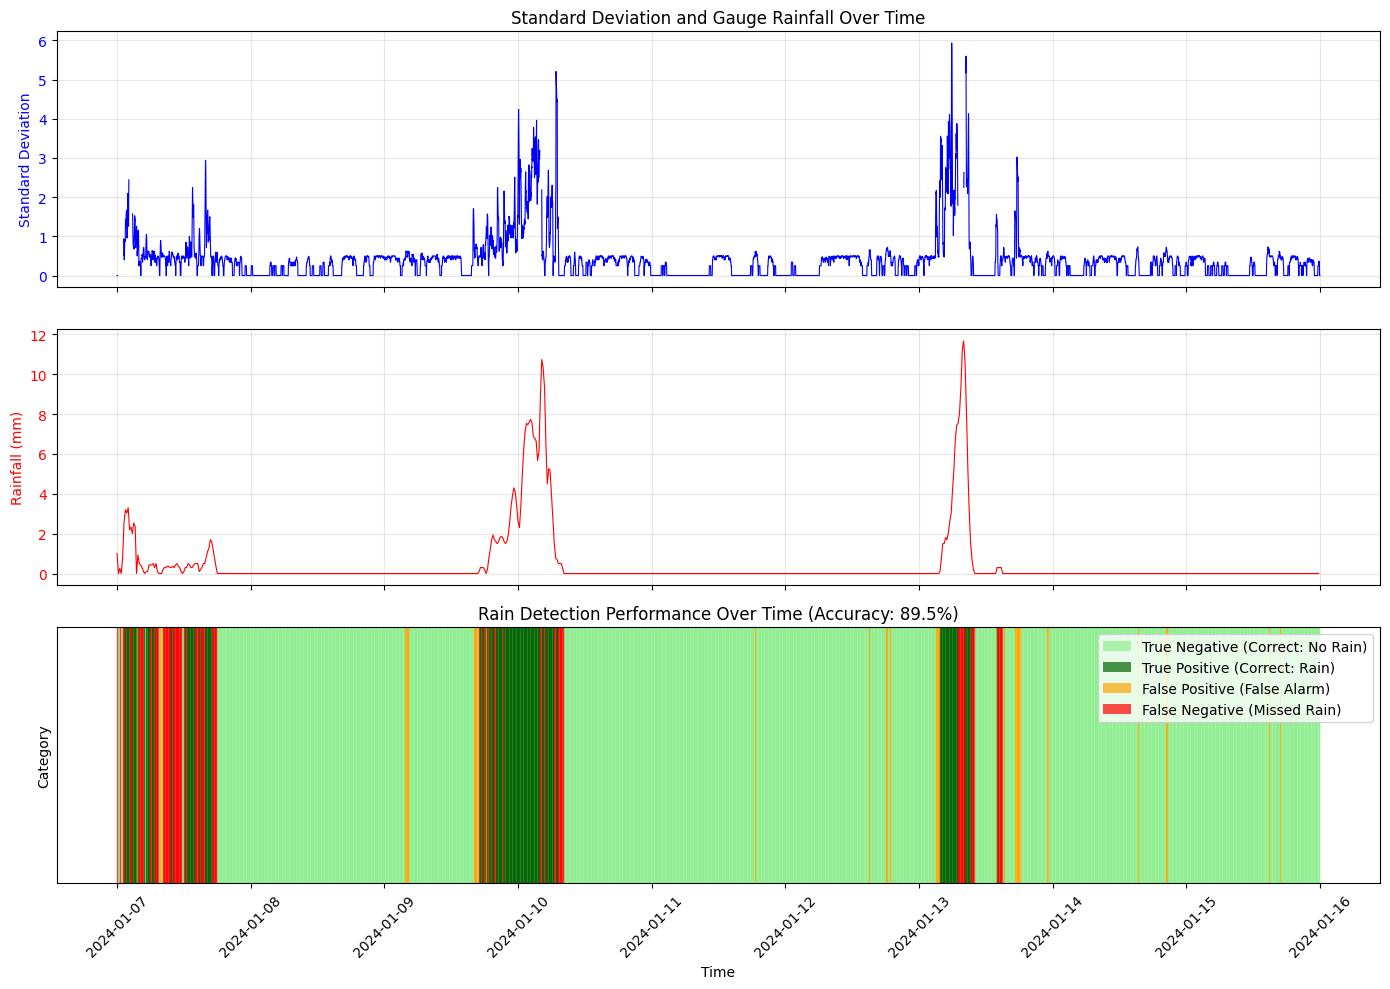

In [ ]:
for i in highfreqID:
    print(f'link frequency: {link_set_short.get_link(i).meta_data.frequency}')
    rain_detection(link_set.get_link(i), 0.59, 15, True, False)

Between 22/03/2024 and 30/03/2024 (9 days)

In [503]:
ds_short2 = ds.sel(time=slice('2024-03-22', '2024-03-30'))
link_set_short2 = patched_xarray2link_with_gauges(ds_short2, ps, max_distance=5000)

Processing sublinks: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


Processing Summary:
  ✅ Valid links created: 100
  ⚠️  Skipped (missing coordinates): 122
  ⚠️  Skipped (no RSL data): 3
  📊 Total processed: 225



In [508]:
highfreq2 = [
    link
    for link in link_set_short.link_list
    if link.meta_data.frequency > 68.0
]

highfreqID2 = []
for i in range(0,len(link_set_short2)):
    if link_set_short2.get_link(i).meta_data.frequency >= 68:
        highfreqID2.append(i)

Overlap period: 2024-03-22T00:00:00 to 2024-03-30T23:59:00
Link WD data points: 12958
Gauge data points: 2592
Interpolated detection length: 2592


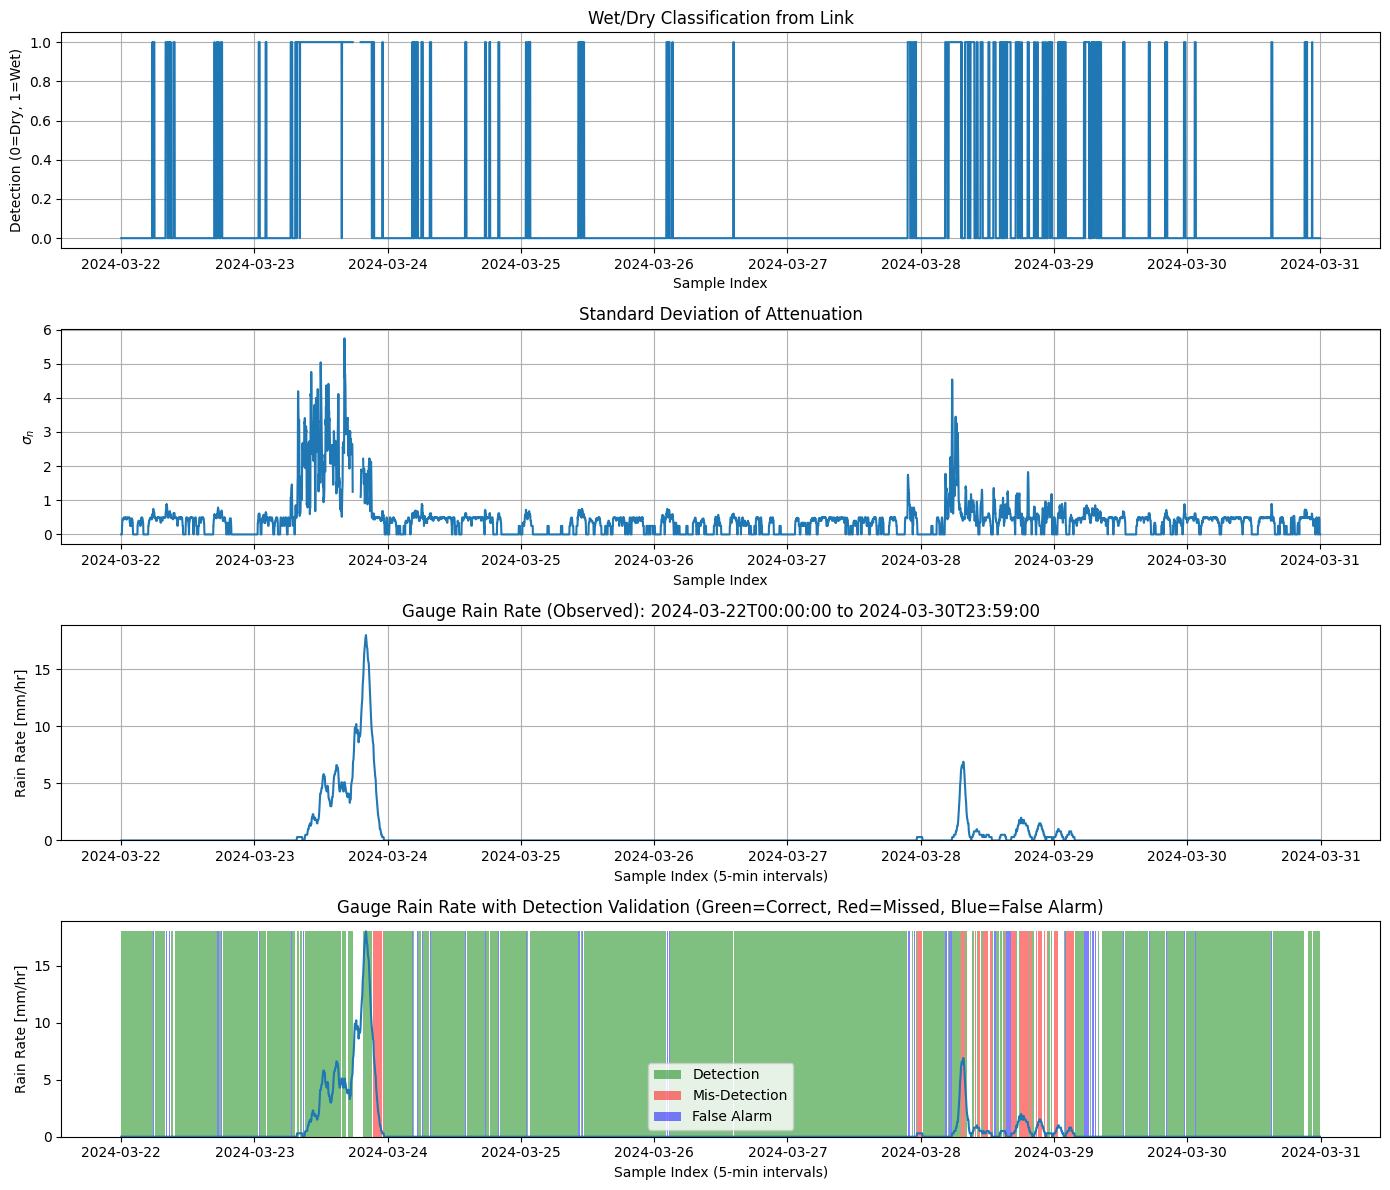


📊 Detection Performance:
  True Positives (correctly detected rain): 216
  True Negatives (correctly detected dry): 2002
  False Positives (false alarms): 174
  False Negatives (missed rain): 176
  Positive detection: 0.5510204081632653
  Negative detection: 0.9200367647058824
  Accuracy: 85.57%


In [505]:
classification_plot(link_set_short2.get_link(highfreqID2[1]),15,0.58)

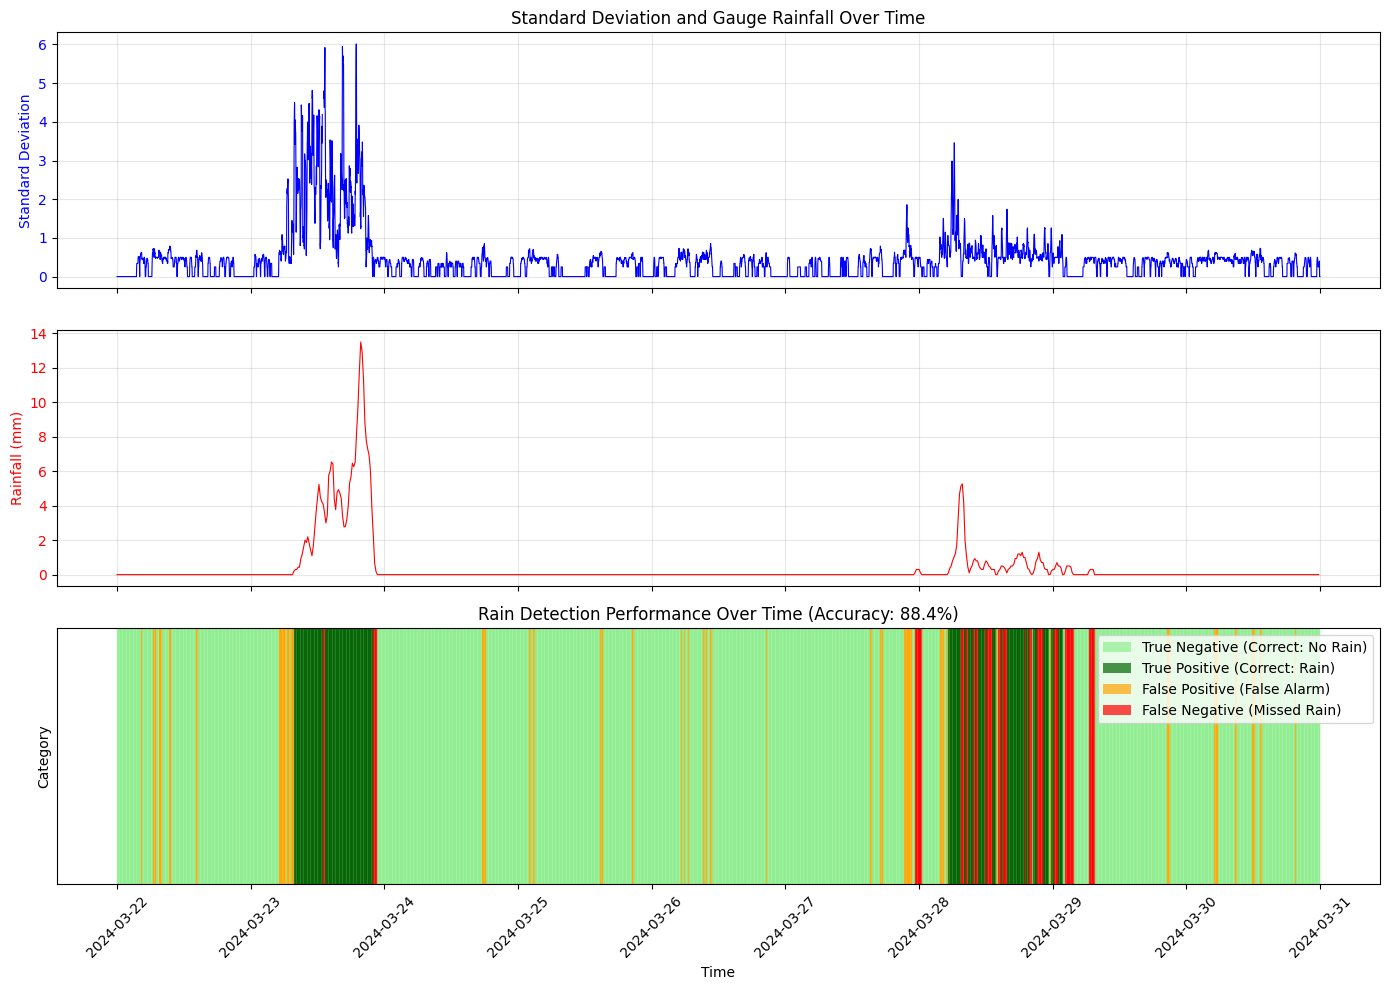

{'accuracy': 0.8842592592592593,
 'positive_acc': 0.7171052631578947,
 'negative_acc': 0.9199438202247191,
 'categories': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [506]:
rain_detection(link_set_short2.get_link(highfreqID2[0]), 0.59, 15, True, False)

### Detection for every high-frequency sublink between 07/01 and 16/01
### std threshold = 0.62

link frequency: 68.04


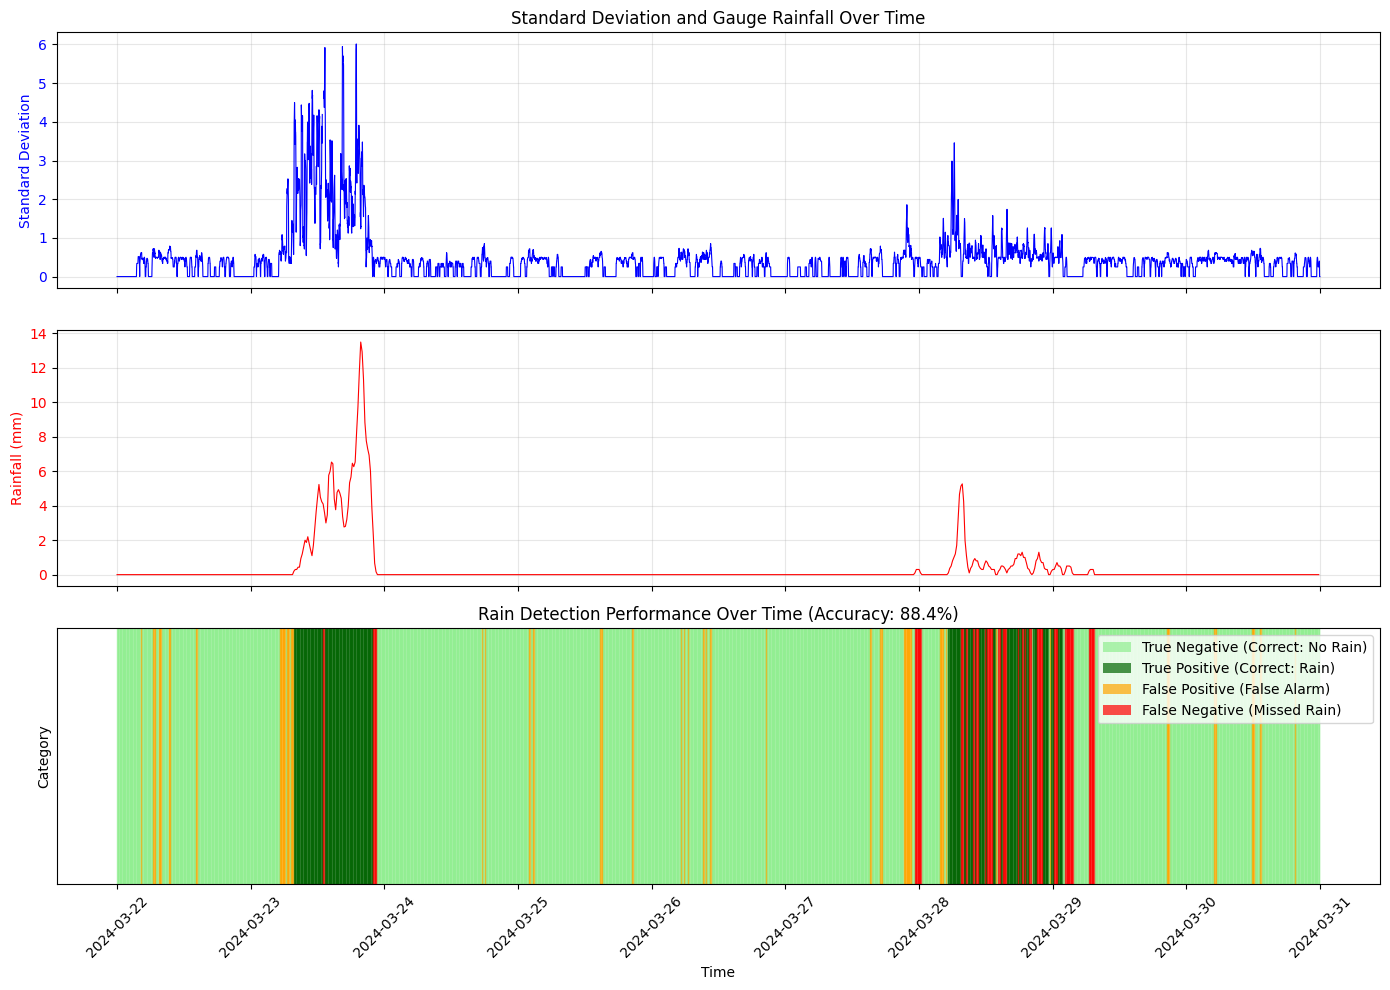

link frequency: 68.04


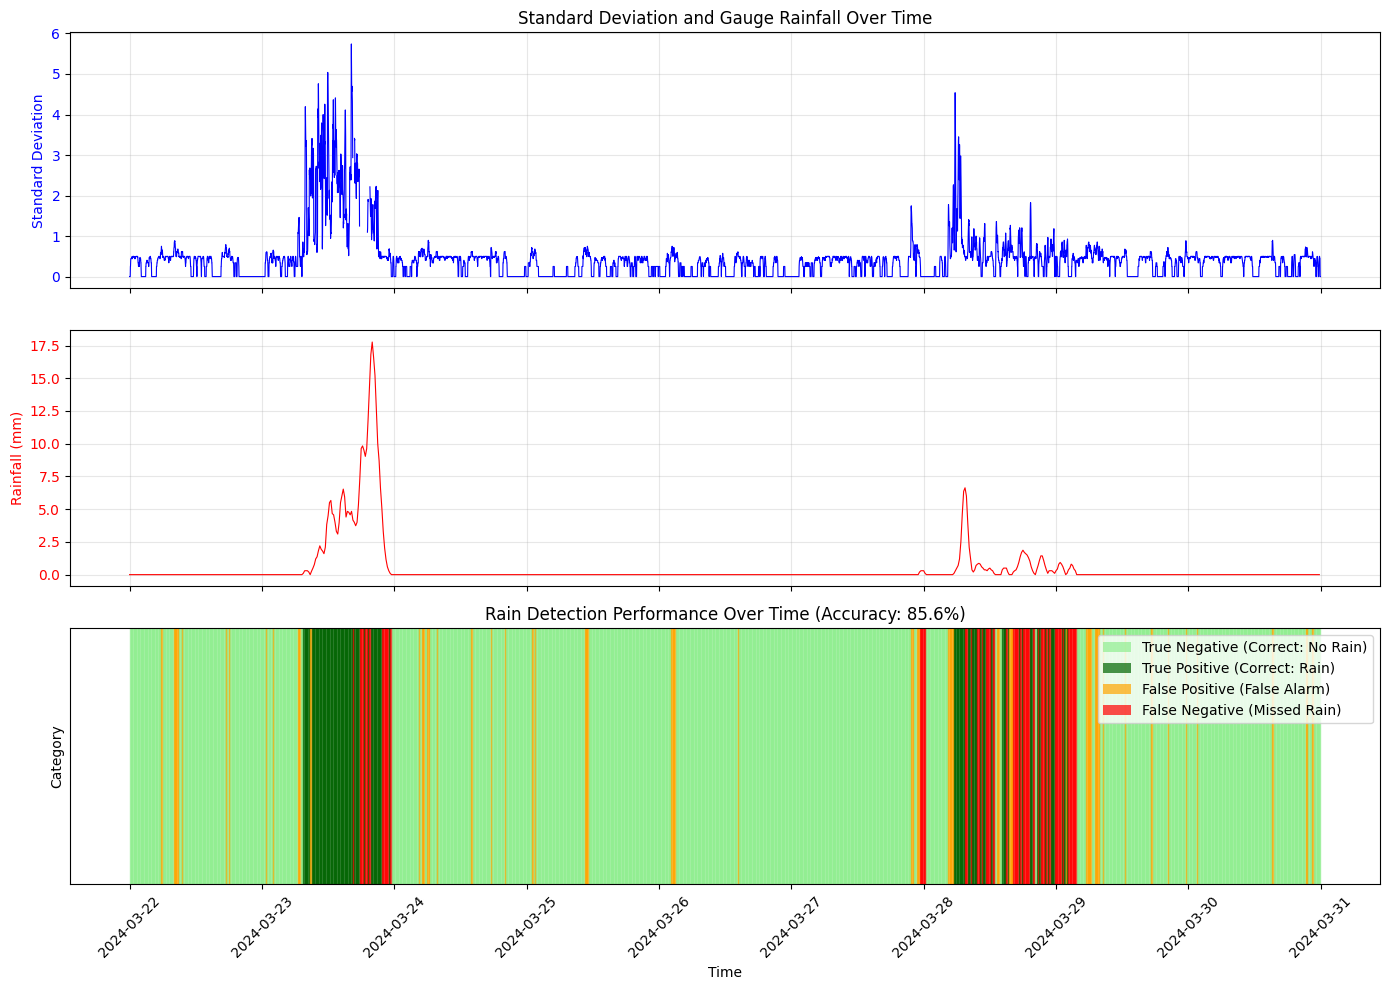

link frequency: 68.04


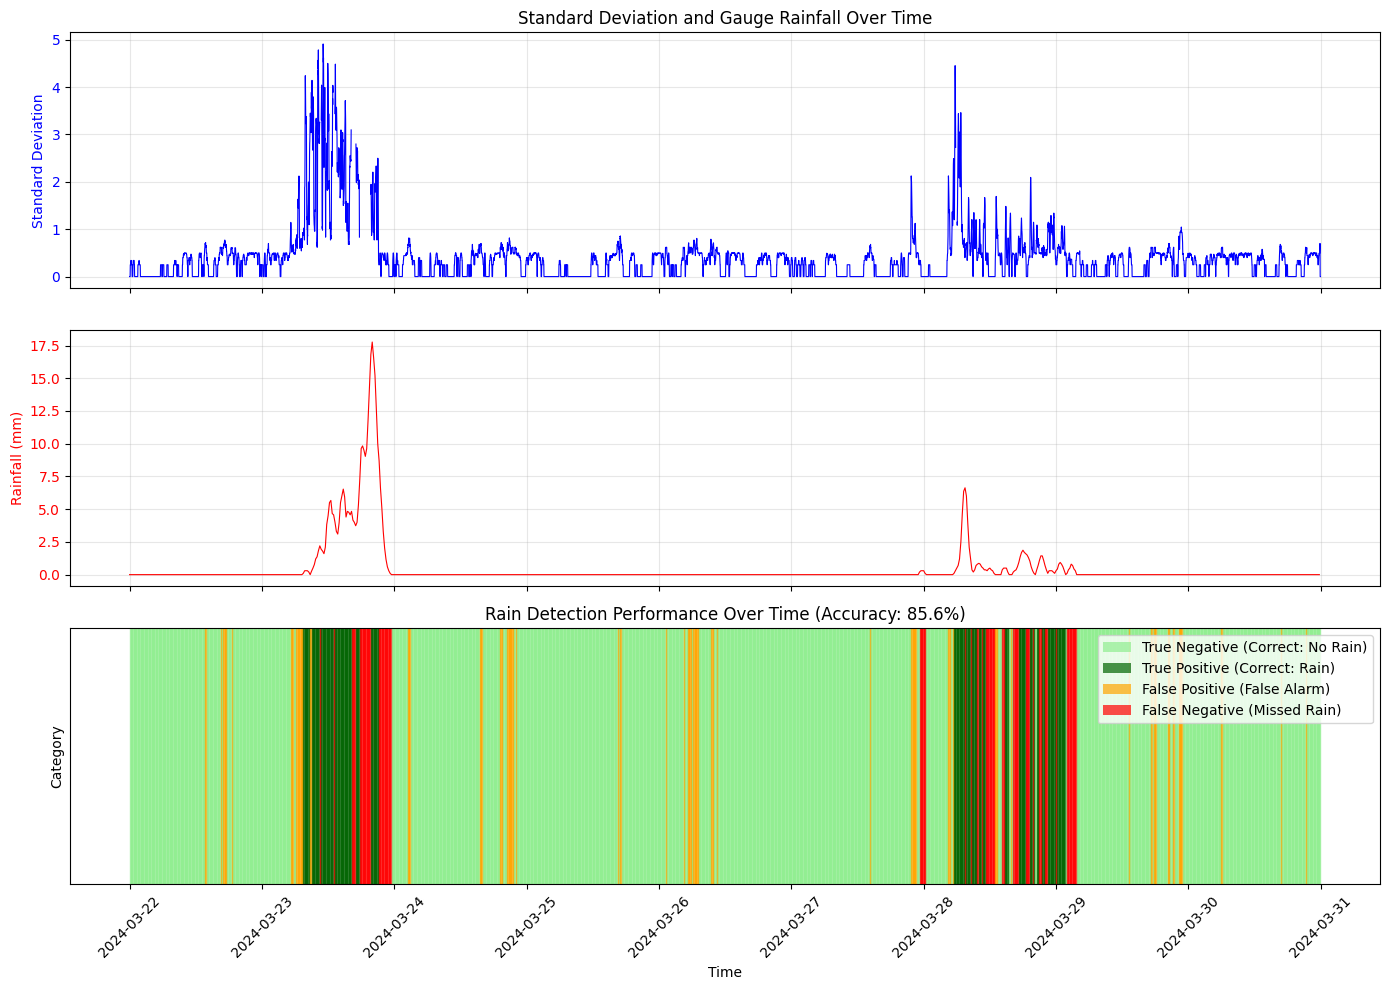

link frequency: 68.04


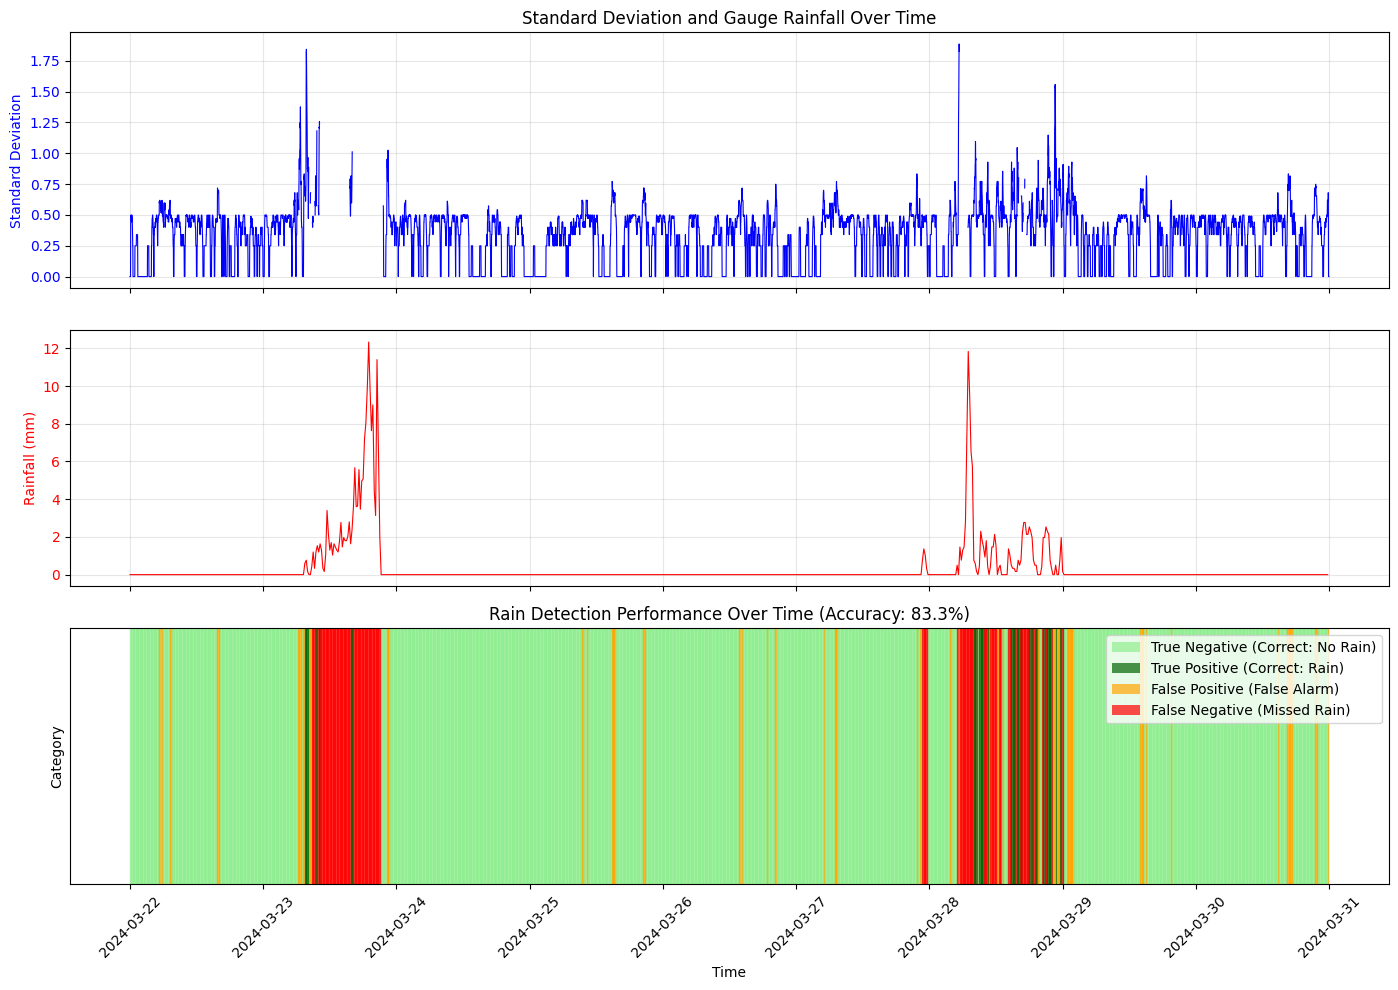

link frequency: 69.12


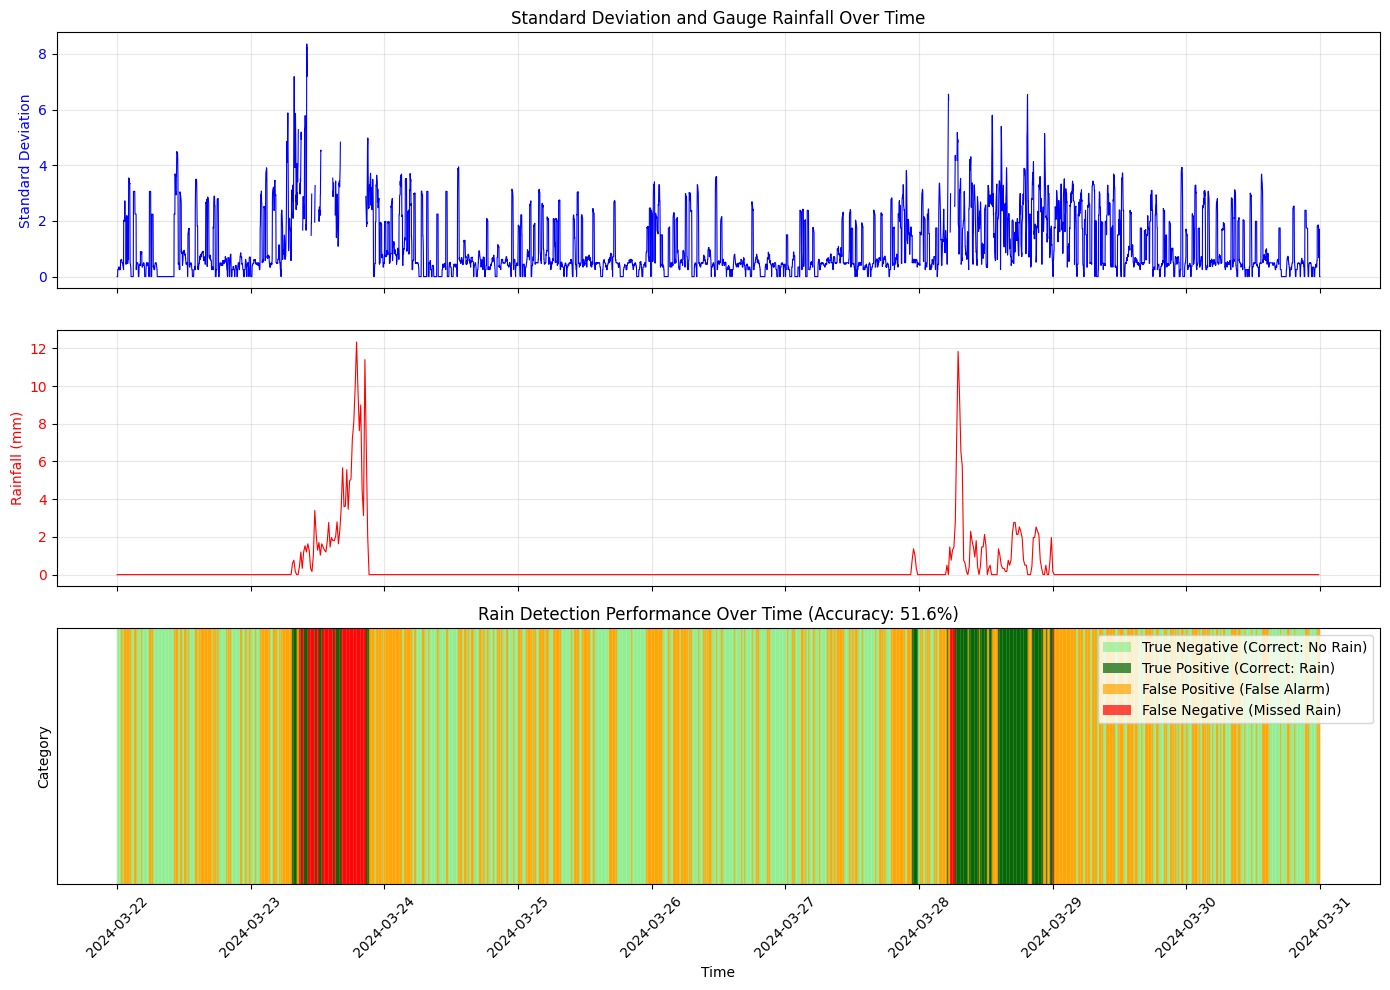

link frequency: 69.12


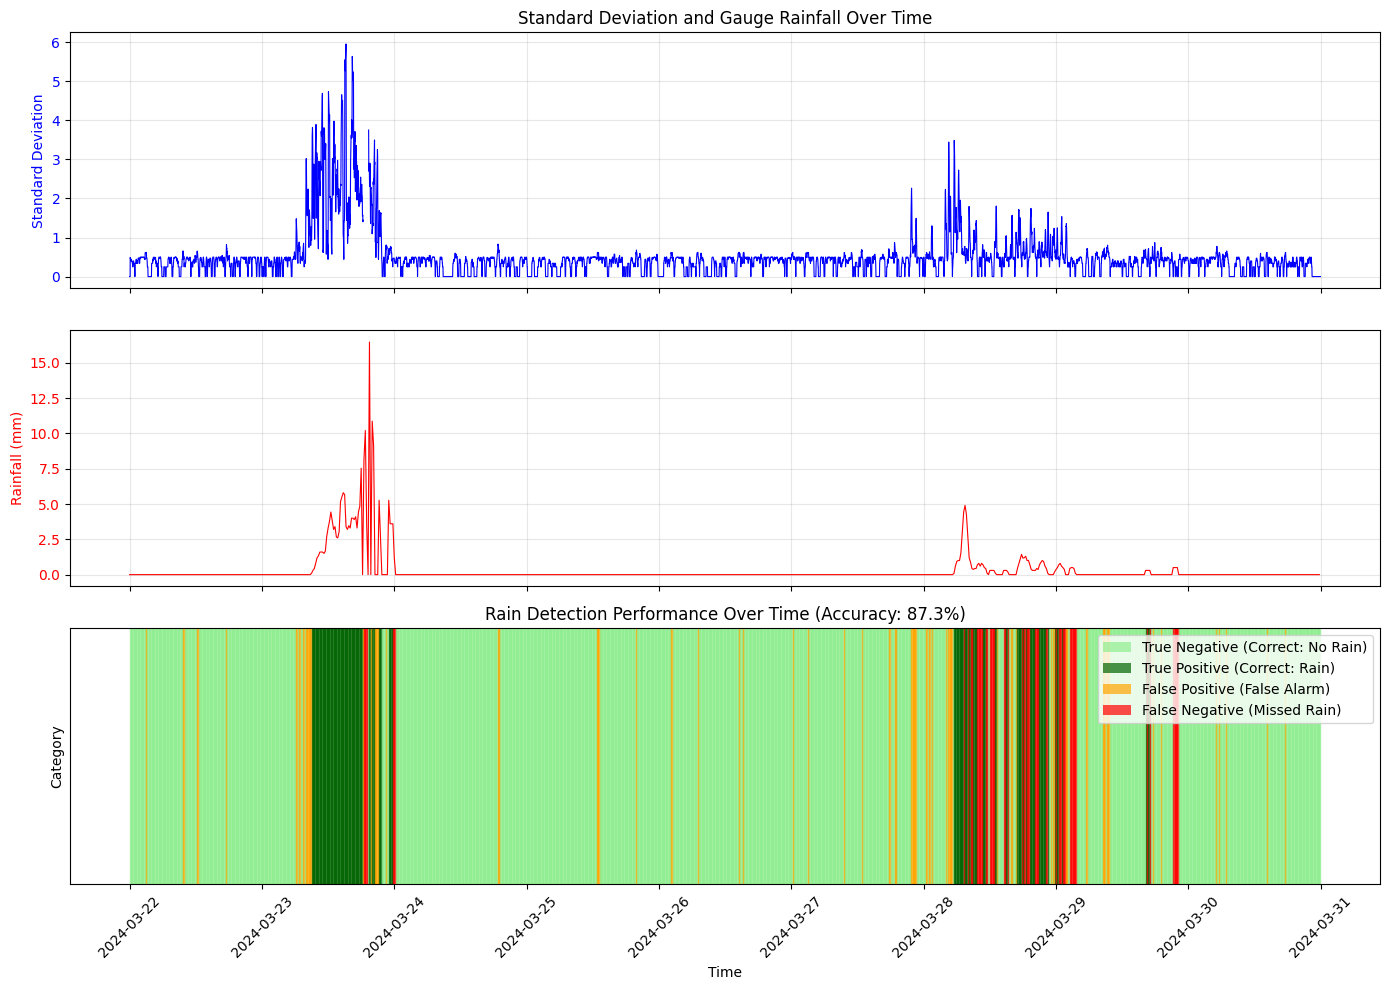

link frequency: 68.04


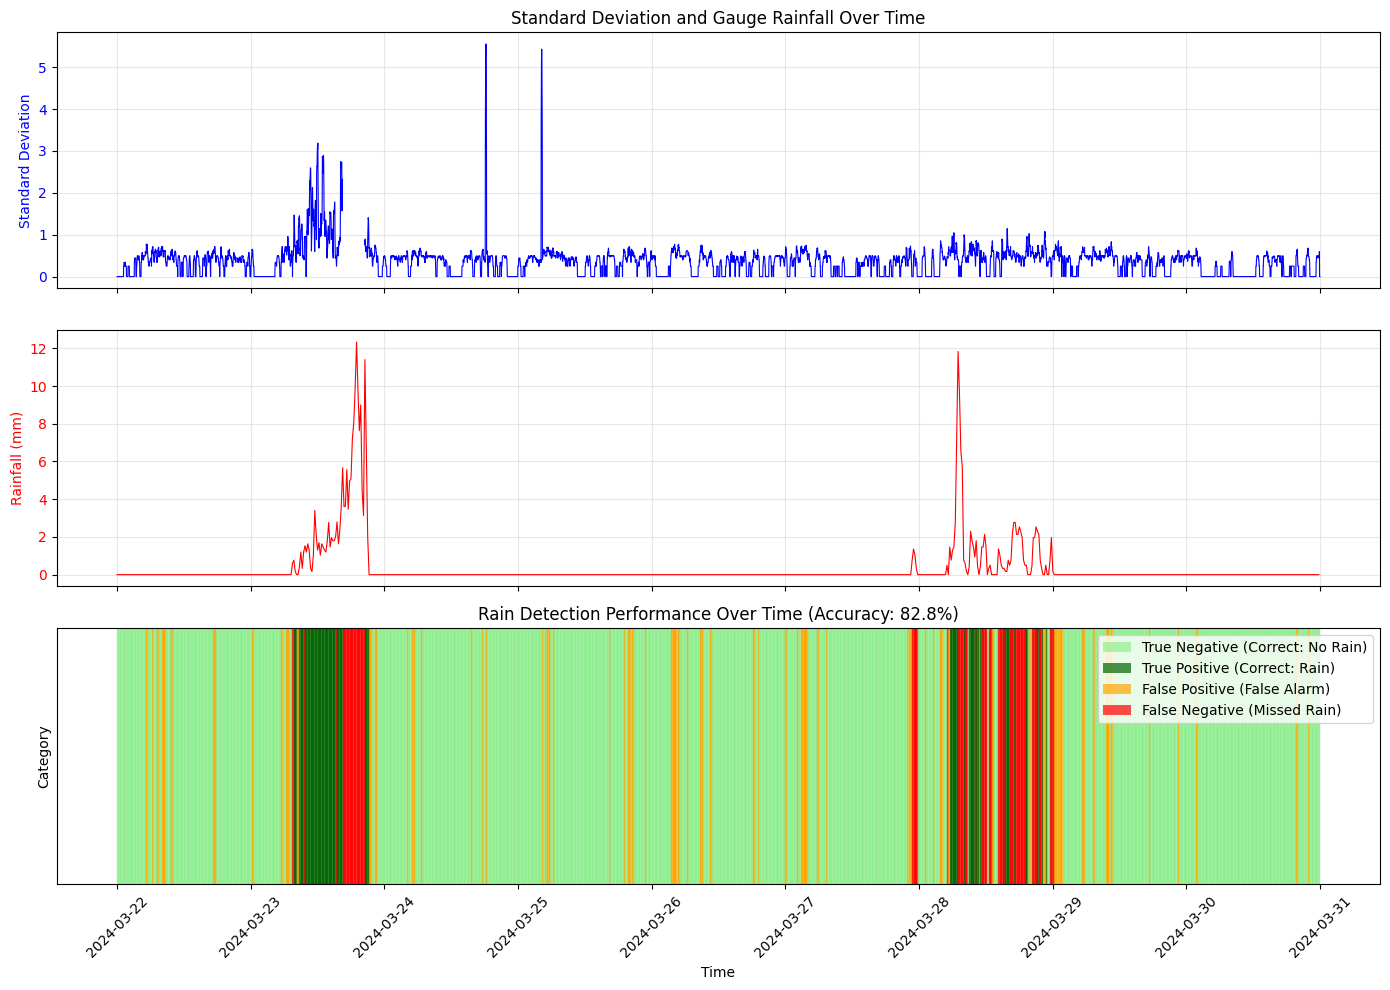

link frequency: 68.04


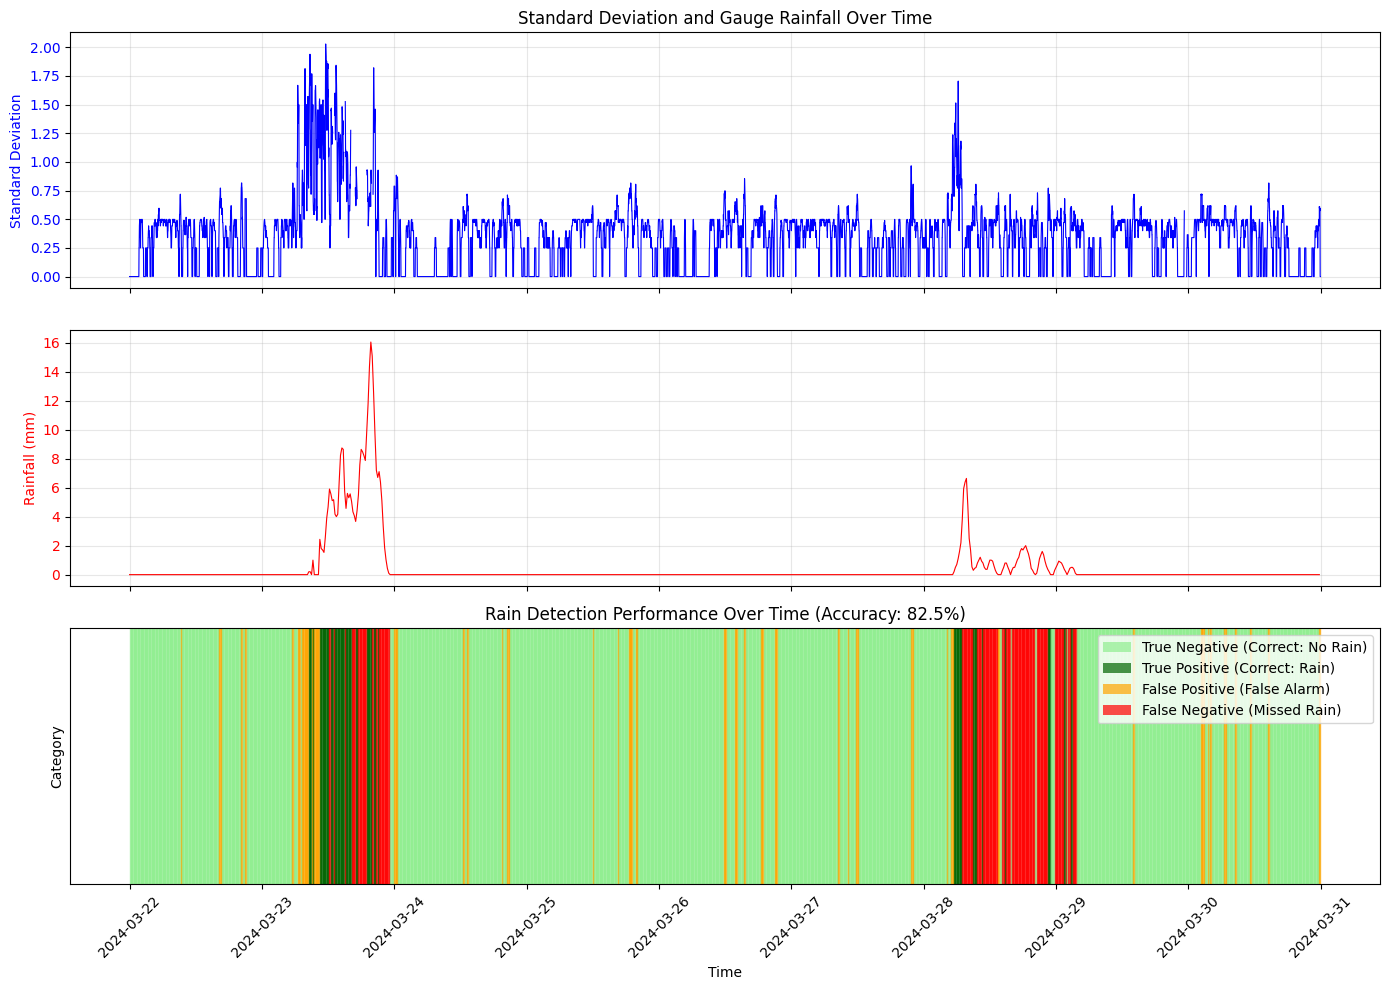

link frequency: 68.04


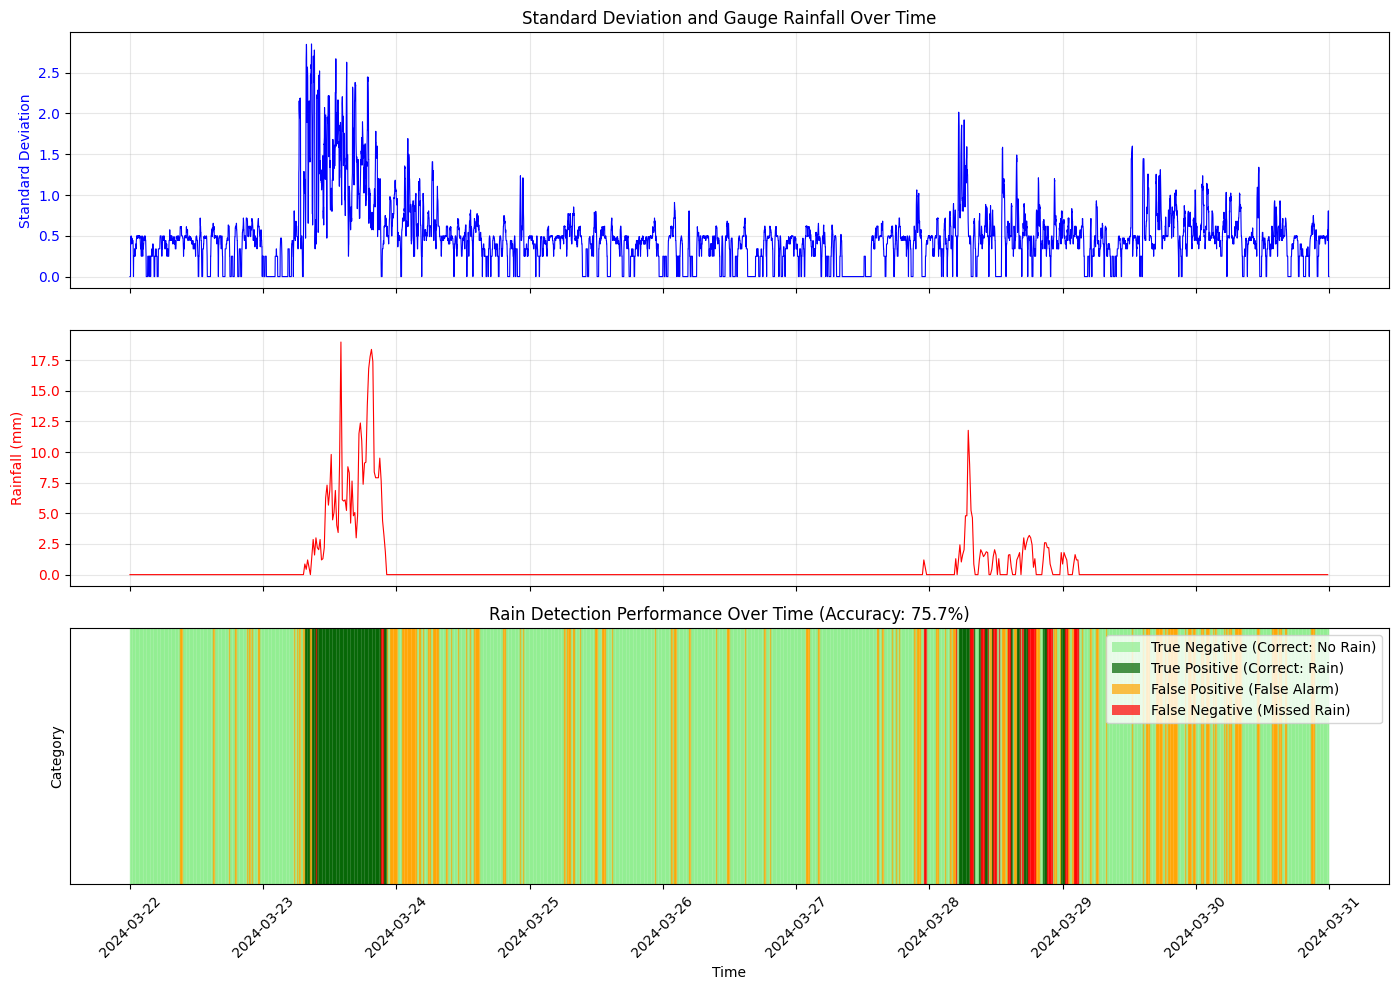

link frequency: 68.04


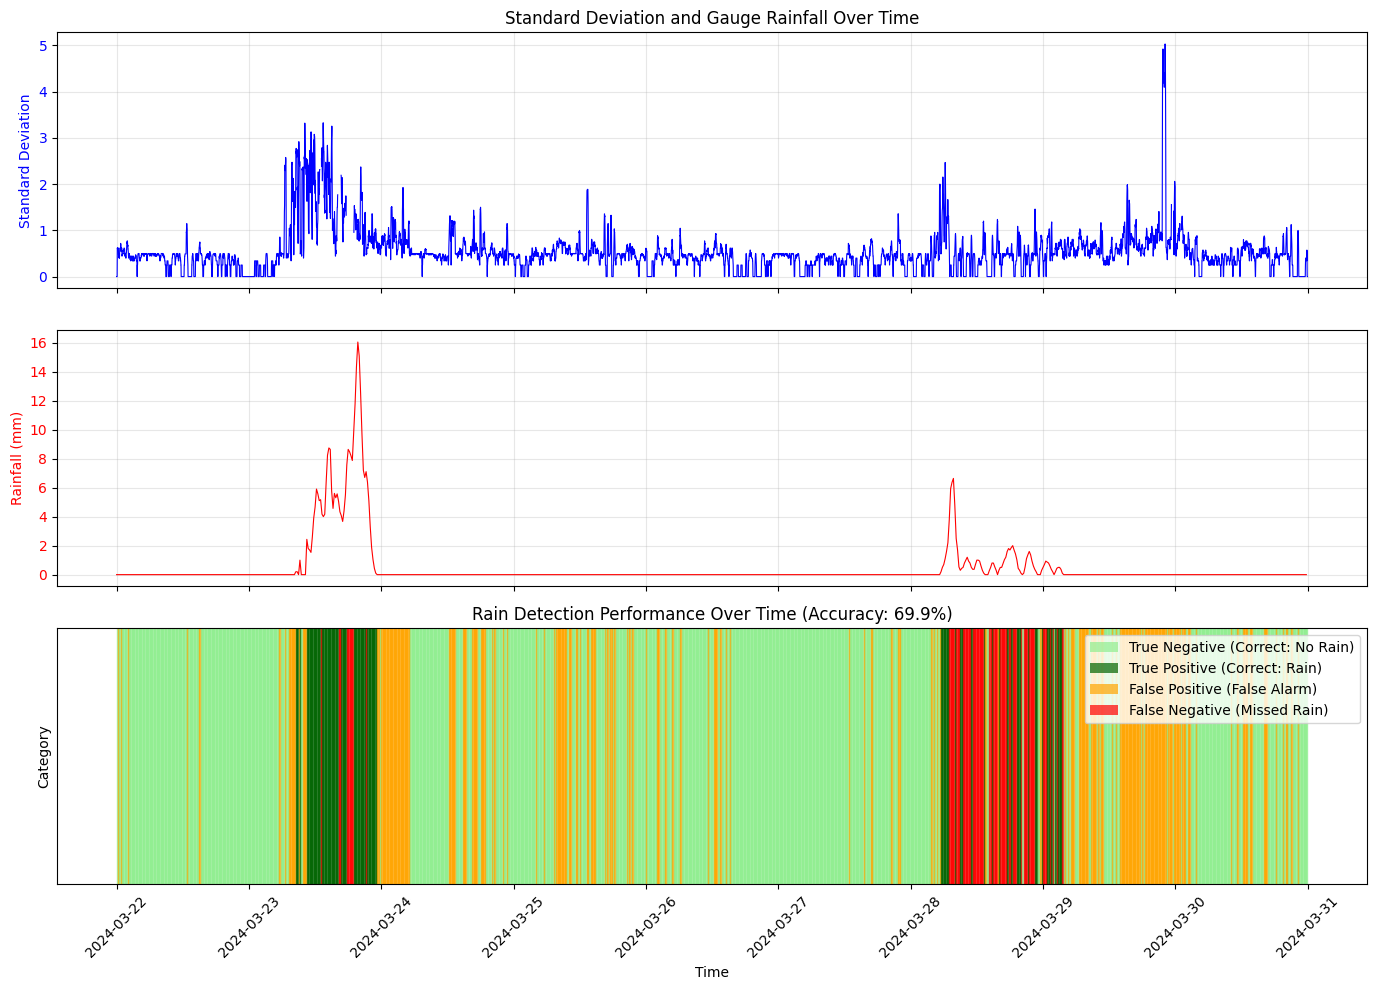

link frequency: 68.04


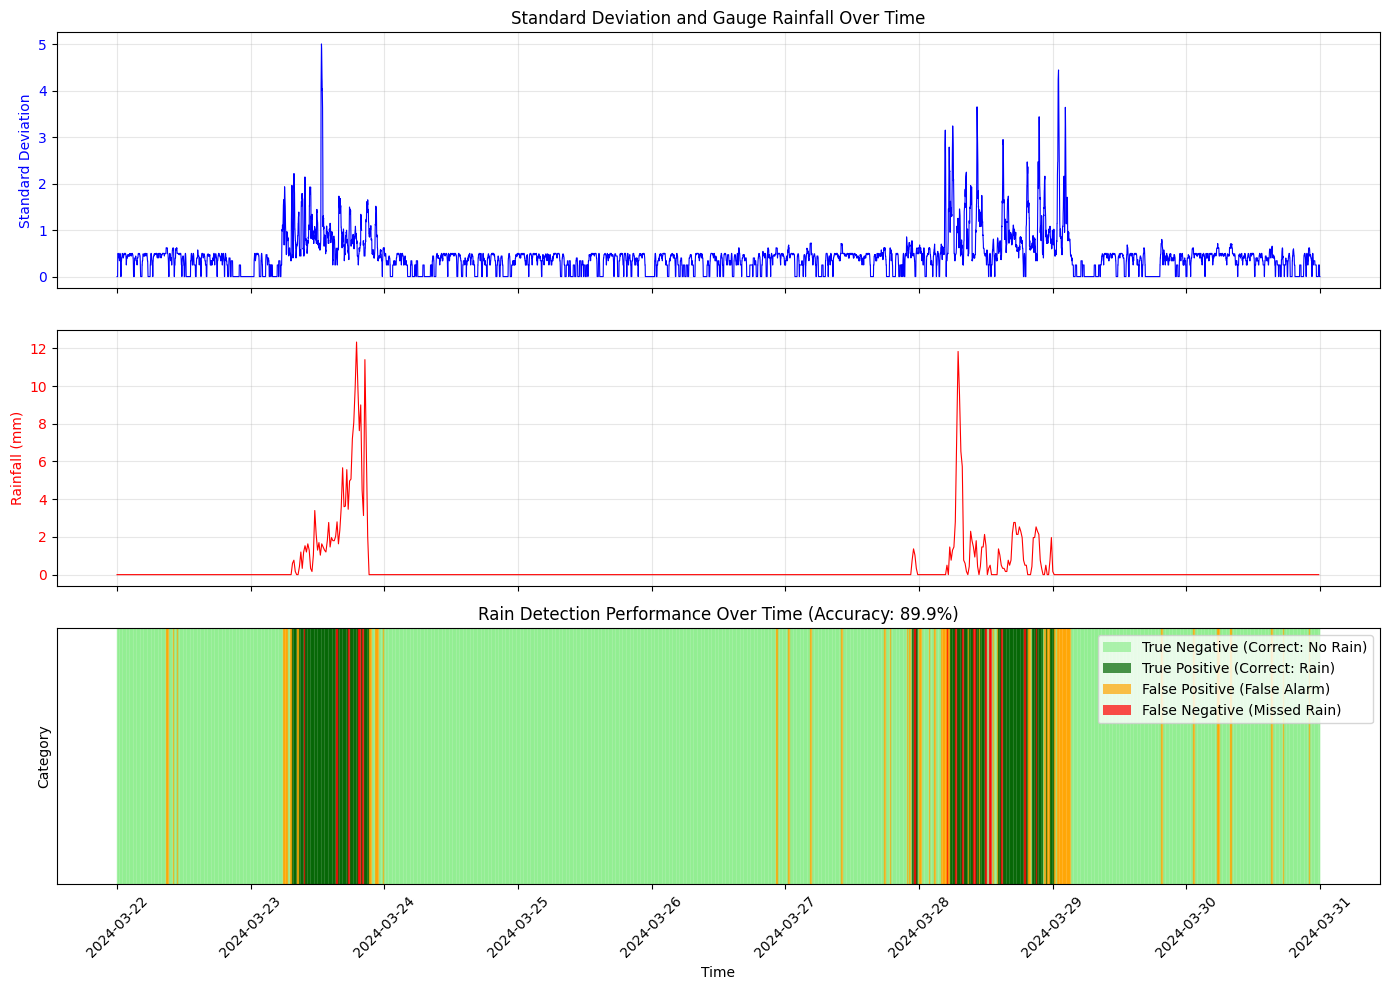

link frequency: 68.04


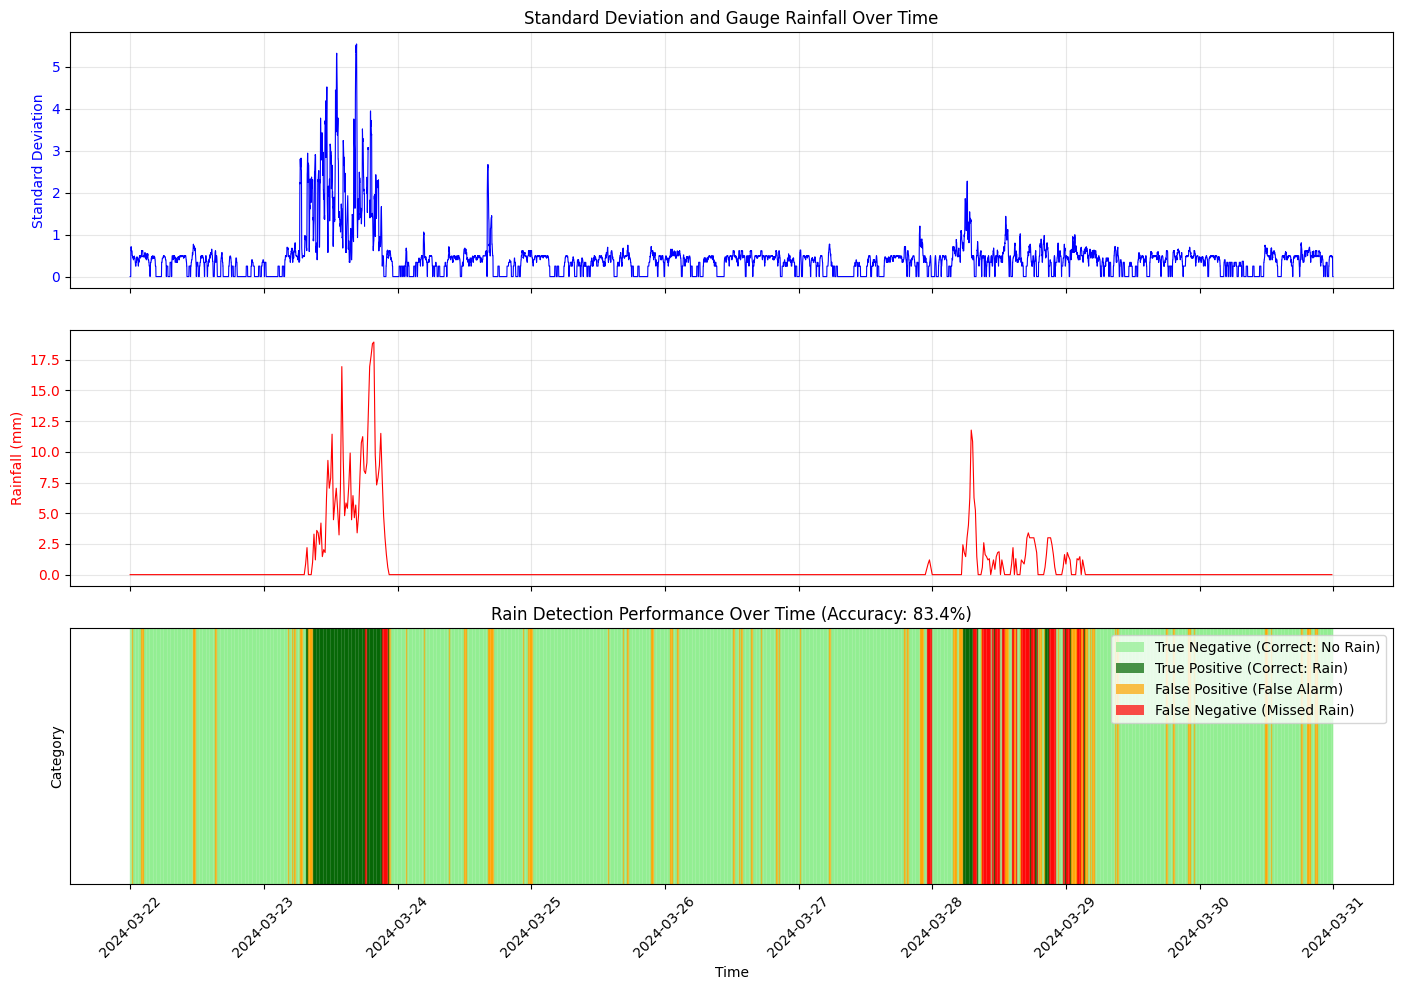

link frequency: 68.04


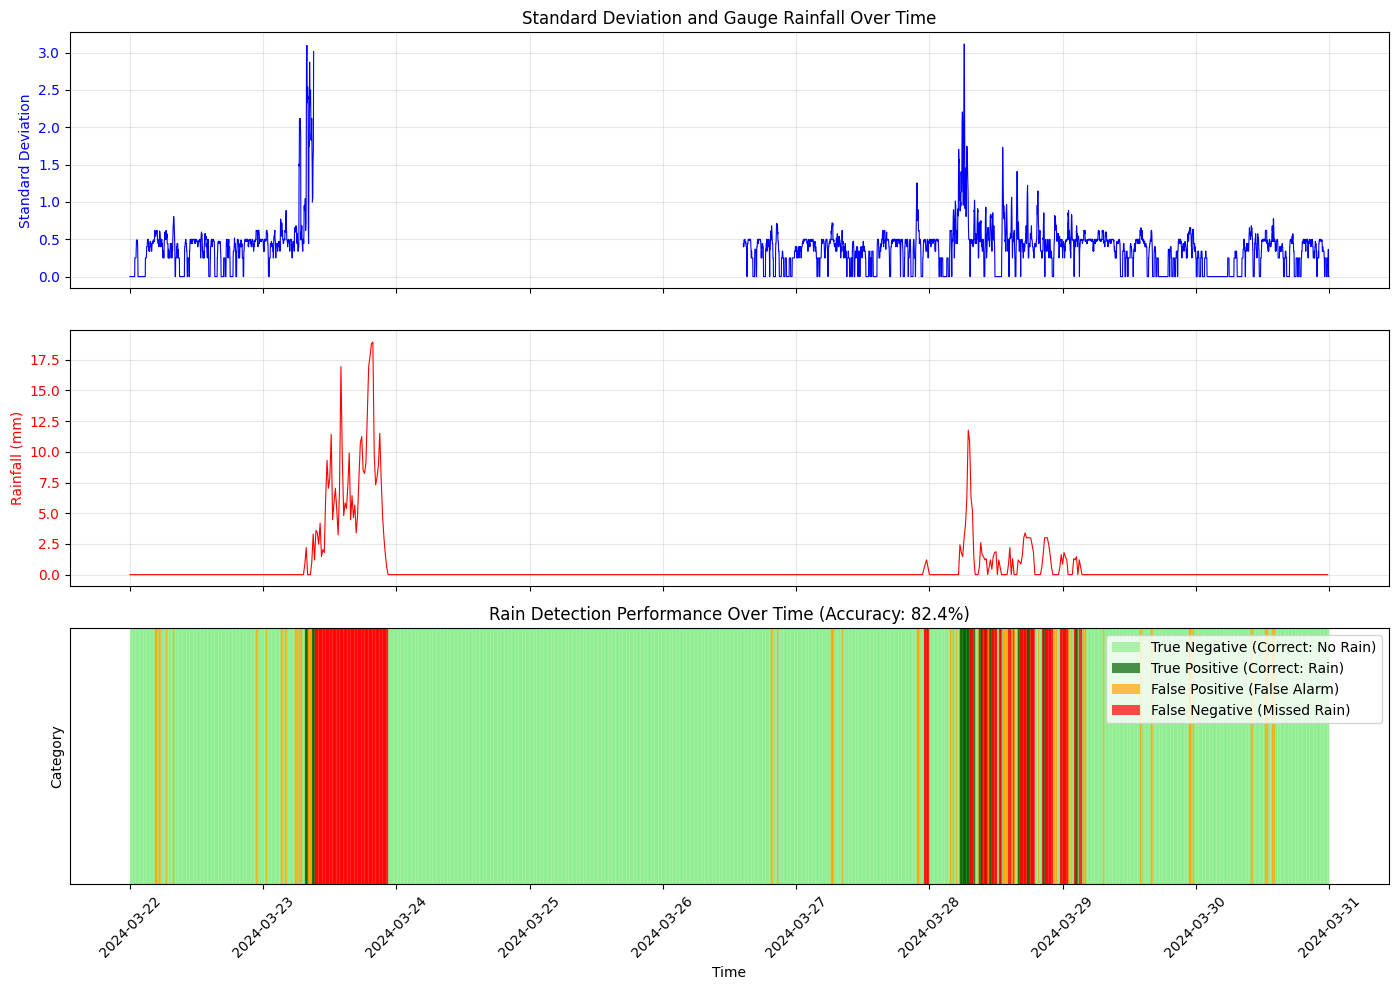

link frequency: 68.04


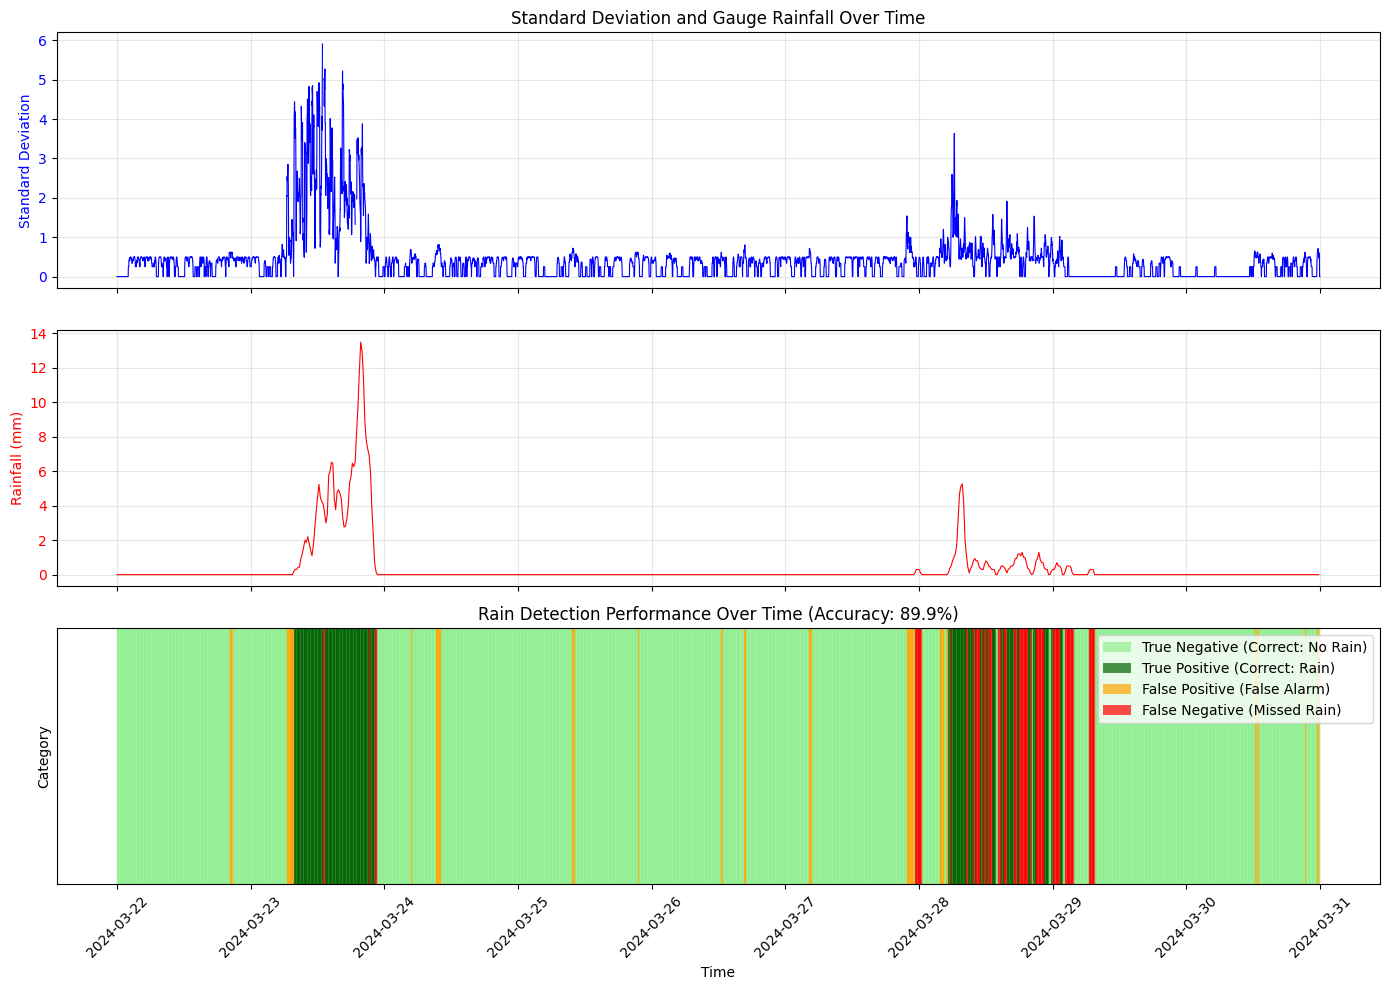

link frequency: 68.04


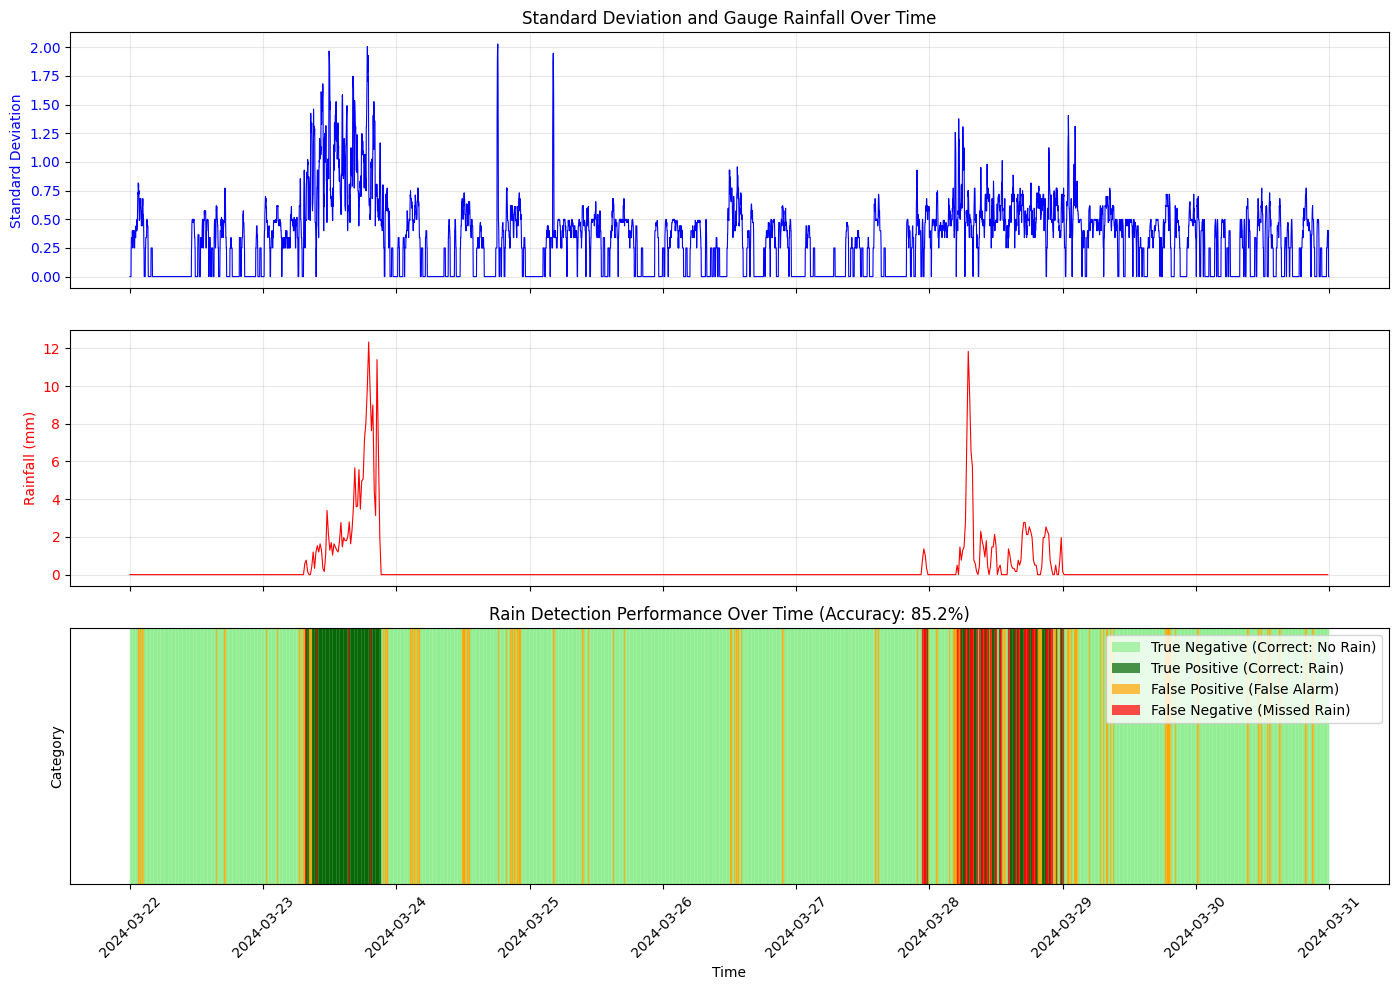

link frequency: 68.04


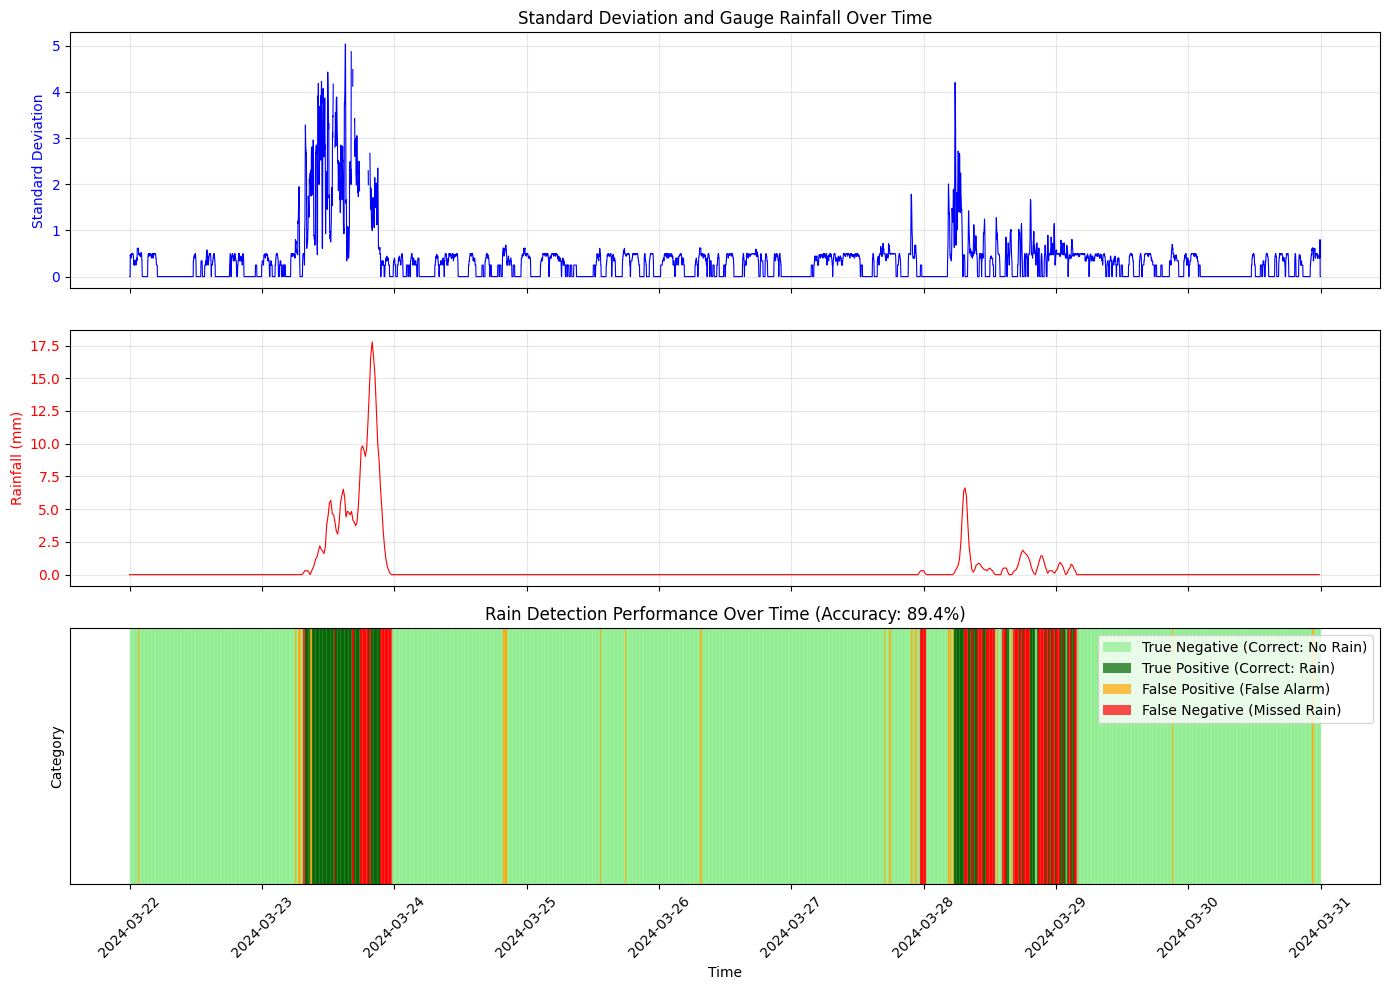

In [512]:
for i in highfreqID2:
    print(f'link frequency: {link_set_short2.get_link(i).meta_data.frequency}')
    rain_detection(link_set_short2.get_link(i), 0.6, 15, True, False)

    Function to check alignment between links and rain gauge

In [470]:
def CheckAlignment(links, indexes, begin, end):
    for i in indexes:
        link = links.get_link(i)
        gauge_time = link.gauge_ref[0].time_array.astype('datetime64[s]')
        gauge_mask = (gauge_time >= np.datetime64(begin)) & (gauge_time <= np.datetime64(end))
        time_filtered_gauge = gauge_time[gauge_mask]
        gauge_filtered = link.gauge_ref[0].data_array[gauge_mask]

        link_time = link.time().astype("datetime64[s]")
        link_mask = (link_time >= np.datetime64(begin)) & (link_time <= np.datetime64(end))
        time_filtered_link = link_time[link_mask]
        rsl_filtered = link.link_rsl[link_mask]

        import matplotlib.pyplot as plt

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot gauge rainfall
        ax1.plot(time_filtered_gauge, gauge_filtered, 'b-', linewidth=2, label='Gauge rainfall')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Rainfall (mm/hr)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.grid(True, alpha=0.3)
        
        # Plot link RSL on second y-axis (inverted)
        ax2 = ax1.twinx()
        ax2.plot(time_filtered_link, rsl_filtered, 'r-', alpha=0.7, label='Link RSL')
        ax2.set_ylabel('RSL (dBm)', color='r')
        ax2.invert_yaxis()  # Invert so drops go up
        ax2.tick_params(axis='y', labelcolor='r')
        
        plt.title(f'Gauge Rainfall vs Link RSL (Link {i})')
        fig.tight_layout()
        plt.show()

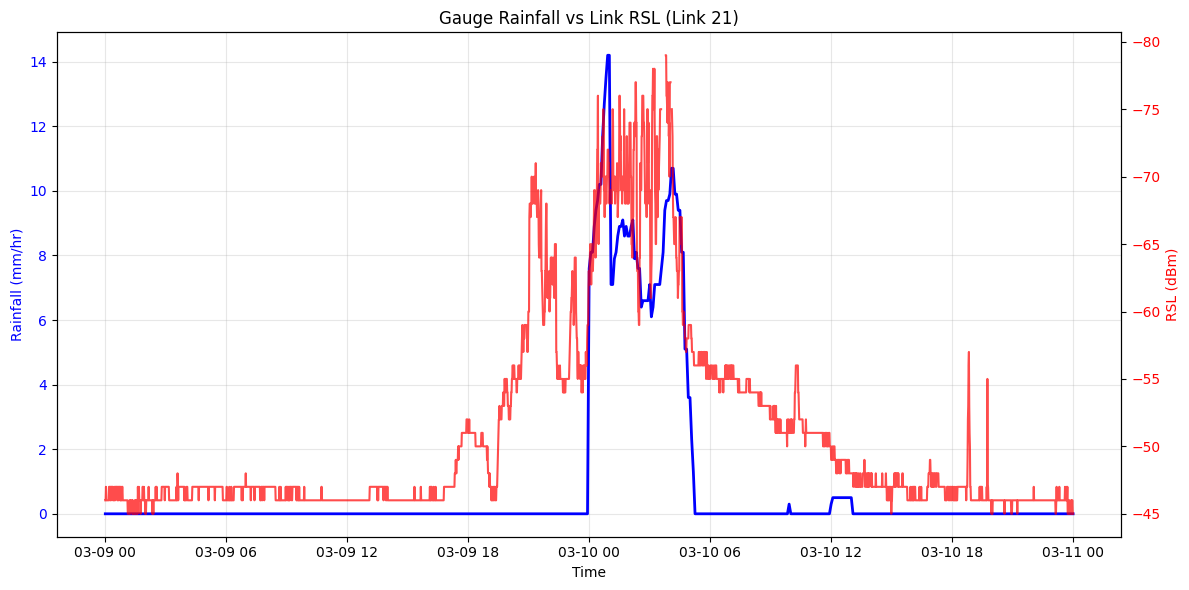

In [480]:
CheckAlignment(link_set, [highfreqID[5]], '2024-03-09', '2024-03-11')